**Matched-filtering техника и генерирање на податочното множество од официјалните настани**

Ќе се користи PyCBC библиотеката, која се применува за проучување на гравитациони бранови од компактни бинарни системи, за наоѓање на соодветните астрофизички извори и проучување на нивните параметри, како и LALSuite библиотеката за симулирање на гравитациони бранови.

In [1]:
! pip install -q 'lalsuite==7.11' 'PyCBC==2.0.5'

In [2]:
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
import pycbc.catalog
import numpy as np
import pandas as pd
from pycbc.waveform import get_td_waveform
import pycbc.catalog
from pycbc.types import TimeSeries
from pycbc.psd import interpolate, inverse_spectrum_truncation
import os
from pycbc.filter import matched_filter
from pycbc.filter import sigma

Поделба на имињата на настаните во засебни низи кои соодветствуваат на каталогот во кој конкретните настани припаѓаат 

In [3]:
GWTC1_events = ["GW150914", "GW151012", "GW151226", "GW170104", "GW170608", "GW170729", "GW170809", "GW170814", "GW170817",
               "GW170818", "GW170823"]

In [4]:
GWTC2_1_events = ["GW190403_051519", "GW190408_181802", "GW190412", "GW190413_052954", "GW190413_134308", "GW190421_213856",
                 "GW190425", "GW190426_190642", "GW190503_185404", "GW190512_180714", "GW190513_205428", "GW190514_065416",
                 "GW190517_055101", "GW190519_153544", "GW190521", "GW190521_074359", "GW190527_092055", "GW190602_175927",
                 "GW190620_030421", "GW190630_185205", "GW190701_203306", "GW190706_222641", "GW190707_093326",
                 "GW190708_232457", "GW190719_215514", "GW190720_000836", "GW190725_174728", "GW190727_060333",
                 "GW190728_064510", "GW190731_140936", "GW190803_022701", "GW190805_211137", "GW190814", "GW190828_063405",
                 "GW190828_065509", "GW190910_112807", "GW190915_235702", "GW190916_200658", "GW190917_114630", "GW190924_021846",
                 "GW190925_232845", "GW190926_050336", "GW190929_012149", "GW190930_133541"]

In [5]:
GWTC3_events = ["GW191103_012549", "GW191105_143521", "GW191109_010717", "GW191113_071753", "GW191126_115259", "GW191127_050227",
               "GW191129_134029", "GW191204_110529", "GW191204_171526", "GW191215_223052", "GW191216_213338", "GW191219_163120",
               "GW191222_033537", "GW191230_180458", "GW200112_155838", "GW200115_042309", "GW200128_022011", "GW200129_065458",
               "GW200202_154313", "GW200208_130117", "GW200208_222617", "GW200209_085452", "GW200210_092254", "GW200216_220804",
               "GW200219_094415", "GW200220_061928", "GW200220_124850", "GW200224_222234", "GW200225_060421", "GW200302_015811",
               "GW200306_093714", "GW200308_173609", "GW200311_115853", "GW200316_215756", "GW200322_091133"]

In [6]:
strain_H_data = []
strain_L_data = []
strain_V_data = []

In [7]:
# nizi vo koi kje se chuvaat samo iminjata na nastanite detektirani kaj soodvetniot detektor
events_H = []
events_L = []
events_V = []

In [8]:
for gwtc1_event in GWTC1_events:
    merger = pycbc.catalog.Merger(gwtc1_event, source='gwtc-1')
    strain_H = merger.strain('H1')
    strain_L = merger.strain('L1')
    
    strain_H = highpass(strain_H, 15.0)
    strain_H = resample_to_delta_t(strain_H, 1.0/2048)
    strain_L = highpass(strain_L, 15.0)
    strain_L = resample_to_delta_t(strain_L, 1.0/2048)
    
    if gwtc1_event in ["GW150914", "GW151012", "GW151226", "GW170104", "GW170608", "GW170823"]: #za ovie nastani nema raboteno Virgo detektorot
        strain_V_array = np.full(65536, np.nan)
        strain_V_data.append(strain_V_array)
    else:
        strain_V = merger.strain('V1')
        strain_V = highpass(strain_V, 15.0)
        strain_V = resample_to_delta_t(strain_V, 1.0/2048)
        strain_V_array = strain_V.numpy()
        strain_V_data.append(strain_V_array)
        events_V.append(gwtc1_event)
    
    strain_H_array = strain_H.numpy()
    strain_H_data.append(strain_H_array)
    strain_L_array = strain_L.numpy()
    strain_L_data.append(strain_L_array)
    events_H.append(gwtc1_event)
    events_L.append(gwtc1_event)

In [9]:
for gwtc2_1_event in GWTC2_1_events:
    merger = pycbc.catalog.Merger(gwtc2_1_event, source='gwtc-2.1')
    
    if gwtc2_1_event in ["GW190425", "GW190620_030421", "GW190630_185205", "GW190708_232457",
                        "GW190910_112807"]:
        strain_H_array = np.full(65536, np.nan)
        strain_H_data.append(strain_H_array)
    else:
        strain_H = merger.strain('H1')
        strain_H = highpass(strain_H, 15.0)
        strain_H = resample_to_delta_t(strain_H, 1.0/2048)
        strain_H_array = strain_H.numpy()
        strain_H_data.append(strain_H_array)
        events_H.append(gwtc2_1_event)
        
    if gwtc2_1_event in ["GW190925_232845"]:
        strain_L_array = np.full(65536, np.nan)
        strain_L_data.append(strain_L_array)
    else:
        strain_L = merger.strain('L1')
        strain_L = highpass(strain_L, 15.0)
        strain_L = resample_to_delta_t(strain_L, 1.0/2048)
        strain_L_array = strain_L.numpy()
        strain_L_data.append(strain_L_array)
        events_L.append(gwtc2_1_event)
        
    if gwtc2_1_event in ["GW190403_051519", "GW190413_052954", "GW190421_213856", "GW190426_190642", "GW190514_065416", "GW190521_074359",
                        "GW190527_092055", "GW190707_093326", "GW190719_215514", "GW190731_140936",
                        "GW190805_211137", "GW190930_133541"]:
        strain_V_array = np.full(65536, np.nan)
        strain_V_data.append(strain_V_array)
    else:
        strain_V = merger.strain('V1')
        strain_V = highpass(strain_V, 15.0)
        strain_V = resample_to_delta_t(strain_V, 1.0/2048)
        strain_V_array = strain_V.numpy()
        strain_V_data.append(strain_V_array)
        events_V.append(gwtc2_1_event)

In [10]:
for gwtc3_event in GWTC3_events:
    merger = pycbc.catalog.Merger(gwtc3_event, source='gwtc-3')
    
    if gwtc3_event in ["GW200112_155838"]:
        strain_H_array = np.full(65536, np.nan)
        strain_H_data.append(strain_H_array)
    else:
        strain_H = merger.strain('H1')
        strain_H = highpass(strain_H, 15.0)
        strain_H = resample_to_delta_t(strain_H, 1.0/2048)
        strain_H_array = strain_H.numpy()
        strain_H_data.append(strain_H_array)
        events_H.append(gwtc3_event)
    
    if gwtc3_event in ["GW191216_213338", "GW200302_015811"]:
        strain_L_array = np.full(65536, np.nan)
        strain_L_data.append(strain_L_array)
    else:
        strain_L = merger.strain('L1')
        strain_L = highpass(strain_L, 15.0)
        strain_L = resample_to_delta_t(strain_L, 1.0/2048)
        strain_L_array = strain_L.numpy()
        strain_L_data.append(strain_L_array)
        events_L.append(gwtc3_event)
    
    if gwtc3_event in ["GW191103_012549", "GW191109_010717", "GW191126_115259", "GW191129_134029",
                      "GW191204_110529", "GW191204_171526", "GW191222_033537", "GW200128_022011",
                      "GW200220_124850", "GW200225_060421", "GW200306_093714"]:
        strain_V_array = np.full(65536, np.nan)
        strain_V_data.append(strain_V_array)
    else:
        strain_V = merger.strain('V1')
        strain_V = highpass(strain_V, 15.0)
        strain_V = resample_to_delta_t(strain_V, 1.0/2048)
        strain_V_array = strain_V.numpy()
        strain_V_data.append(strain_V_array)
        events_V.append(gwtc3_event)

In [11]:
# primer H data za prviot nastan GW150914
df = pd.DataFrame({'Strain Hanford': strain_H_data[0]})
print(df)

       Strain Hanford
0        1.453261e-19
1        1.320747e-19
2       -1.742559e-20
3       -5.972212e-21
4       -1.466701e-20
...               ...
65531   -3.342500e-20
65532   -1.772582e-20
65533   -4.777186e-20
65534    6.208833e-20
65535    7.413966e-20

[65536 rows x 1 columns]


In [12]:
# onamu kade shto soodvetniot detektor nema detektirano podatoci nema vrednosti (pr. Virgo za GW150914)
df = pd.DataFrame({'Strain Virgo': strain_V_data[0]})
print(df)

       Strain Virgo
0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
...             ...
65531           NaN
65532           NaN
65533           NaN
65534           NaN
65535           NaN

[65536 rows x 1 columns]


За понатамошната анализа потребно е да се отстранат сите NaN елементи

In [13]:
# broj na NaN vrednosti kaj sekoj detektor 
total_nan_count_H = 0

for array in strain_H_data:
    nan_count = np.isnan(array).sum()
    total_nan_count_H += nan_count
    
print("Total NaN values for Hanford:", total_nan_count_H)

Total NaN values for Hanford: 393216


In [14]:
total_nan_count_L = 0

for array in strain_L_data:
    nan_count = np.isnan(array).sum()
    total_nan_count_L += nan_count
    
print("Total NaN values for Livingston:", total_nan_count_L)

Total NaN values for Livingston: 196608


In [15]:
total_nan_count_V = 0

for array in strain_V_data:
    nan_count = np.isnan(array).sum()
    total_nan_count_V += nan_count
    
print("Total NaN values for Virgo:", total_nan_count_V)

Total NaN values for Virgo: 1966080


Очекувано, Virgo детекторот има најголем број на NaN вредности, а Livingston најмал. Ова се должи на фактот што Virgo има најмала, а Livingston најголема чувствителност и исто така Virgo подоцна се има приклучено во детектирањето на гравитациони бранови и е подложен на почести периоди на проверки и дополнителни инсталации.

In [16]:
# otstranuvanje na NaN vrednostite kaj sekoj detektor
strain_H_data = [array for array in strain_H_data if not np.isnan(array).any()]
strain_L_data = [array for array in strain_L_data if not np.isnan(array).any()]
strain_V_data = [array for array in strain_V_data if not np.isnan(array).any()]

In [17]:
# primer pechatenje na prvata niza od strain_V_data (prethodno imashe NaN vrednosti bidejkji se odnesuvashe na GW150914, sega ima strain vrednosti bidejkji prvata niza se odnesuva na prviot detektiran nastan od Virgo - GW170729)
df = pd.DataFrame({'Strain Virgo': strain_V_data[0]})
print(df)

       Strain Virgo
0      5.062847e-20
1      4.969471e-20
2      8.943258e-20
3      8.467210e-20
4      4.074078e-20
...             ...
65531 -4.674303e-19
65532 -4.840258e-19
65533 -4.947237e-19
65534 -4.258690e-19
65535 -2.186044e-19

[65536 rows x 1 columns]


Следниот дел се однесува на примена на matched-filtering техниката која претставува оптимален метод за екстрахирање на настанот во Гаусов, стационарен шум, дури и кога параметрите на сигналот не се познати. Целта на matched-filtering техниката е да се увиди дали податокот содржи сигнал кој е сличен со некој член од template bank. Со оглед на тоа што template bank содржи голем број на креирани типови на сигнали со различни параметри, се очекува доколку во податокот има силен сигнал (SNR>=6) дека истиот ќе биде детектиран. Во овој код се земаат параметрите на настанот како познати за да избегне огромната потреба за пресметковна моќ и време во изминувањето на сите примероци од template bank, со тоа што се избира најсоодветниот примерок од template bank и се пребарува низ податоците од детекторите, се наоѓа делот каде е настанот врз база на SNR max и се извлекуваат strain вредностите од пронајдениот сигнал-настан.  

In [18]:
#za chuvanje na strain+labels od sekoj detektor (labels mozhe da se noise; noise+BBH; noise+BNS; noise+NSBH)
label_H = []
label_L = []
label_V = []

In [19]:
#GW150914
#Hanford
strain_H_event = TimeSeries(strain_H_data[0], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 36
m2 = 31
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

A signal was found at 15.42431640625s with SNR 17.500555192780887


In [20]:
#raspredelba na snr vrednostite po vreme
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [21]:
#so ovoj kod se gleda deka posledovatelni se vrednostite so snr>=5 koi soodv. na shum+signal
outer_index = 0
for outer_index, label_data in enumerate(label_H):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)


Outer Index: 0 Inner Index: 11102 Value: 7.321302780751619e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11103 Value: -1.7116590847526058e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11104 Value: 4.8509888351912674e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11105 Value: -1.8135905710248954e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11106 Value: 6.746491599546971e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11107 Value: -1.3500522154112512e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11108 Value: 4.562777784926023e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11109 Value: -1.3789431082746903e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11110 Value: 3.714024168385841e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11111 Value: -8.31047938732483e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11112 Value: 3.1896166320371166e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11113 Value: -8.058548179101926e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 1

In [22]:
#zachuvuvanje kako .npy file
data = label_H[0]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW150914_H_data.npy', structured_array)

In [23]:
data = np.load('GW150914_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0  6.975710e-21  noise
1  1.815957e-20  noise
2  5.570806e-21  noise
3  1.858670e-20  noise
4  1.142330e-21  noise


In [24]:
#GW150914
#Livingston
strain_L_event = TimeSeries(strain_L_data[0], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 36
m2 = 31
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

A signal was found at 15.41748046875s with SNR 13.253644112812966


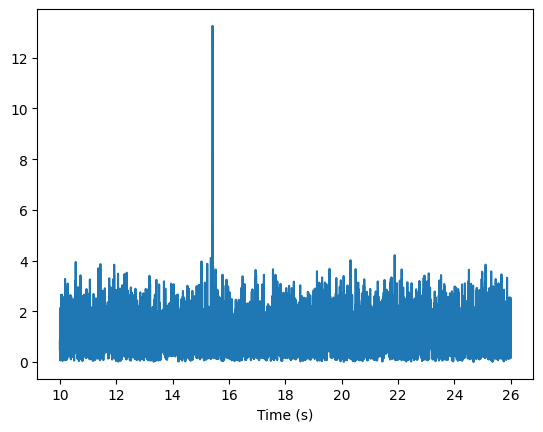

In [25]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [26]:
outer_index = 0
for outer_index, label_data in enumerate(label_L):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 0 Inner Index: 11088 Value: 6.292604230899734e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11089 Value: 8.351103453029199e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11090 Value: 6.307825692254379e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11091 Value: 2.3294770844308187e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11092 Value: 6.707721112278376e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11093 Value: 8.459772204651213e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11094 Value: 6.529991068876726e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11095 Value: 2.6203006265391668e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11096 Value: 7.064900086930717e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11097 Value: 8.203941049029816e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11098 Value: 6.202433590227676e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11099 Value: 2.4919405469294073e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11100 Val

In [27]:
data = label_L[0]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW150914_L_data.npy', structured_array)

In [28]:
data = np.load('GW150914_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -1.205366e-20  noise
1 -8.894034e-22  noise
2  7.719217e-20  noise
3  3.894113e-20  noise
4 -1.083988e-20  noise


In [29]:
#GW151012
#H
strain_H_event = TimeSeries(strain_H_data[1], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 23
m2 = 14
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 11.1083984375s with SNR 4.553130746983982


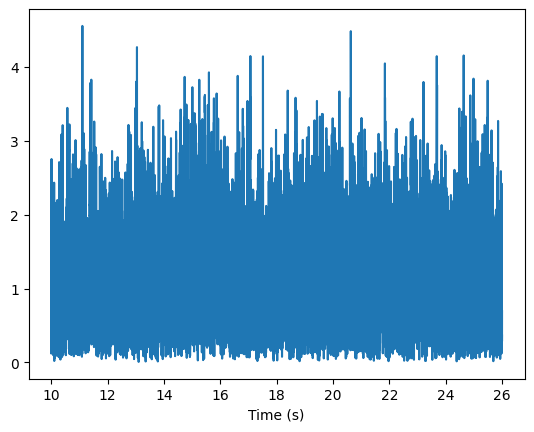

In [30]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [31]:
#GW151012
#L
strain_L_event = TimeSeries(strain_L_data[1], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 23
m2 = 14
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.44482421875s with SNR 4.979671385574757


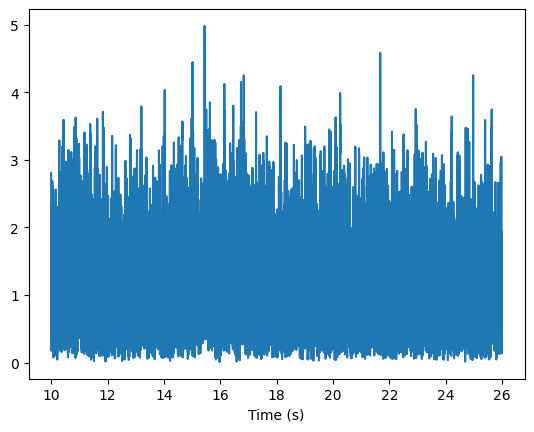

In [32]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Овој настан е тешко да се означи со оглед на слабата вредност на SNR.

In [33]:
#GW151226
#H
strain_H_event = TimeSeries(strain_H_data[2], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 14
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.64794921875s with SNR 7.188898032077319


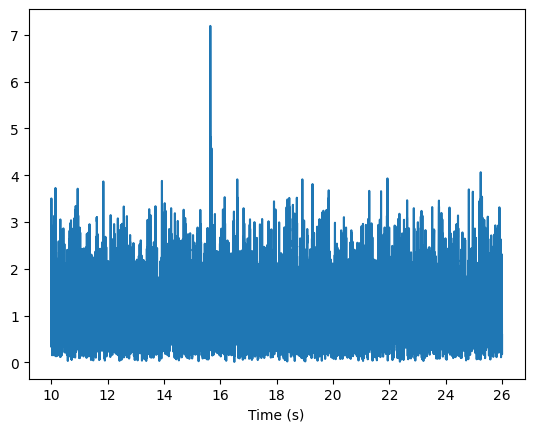

In [34]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [35]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [36]:
data = label_H[1]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW151226_H_data.npy', structured_array)

In [37]:
data = np.load('GW151226_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0  1.099157e-20  noise
1 -4.348023e-21  noise
2  8.725198e-21  noise
3  3.051041e-21  noise
4  1.276135e-20  noise


In [38]:
#GW151226
#L
strain_L_event = TimeSeries(strain_L_data[2], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 14
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.646484375s with SNR 6.081954574534834


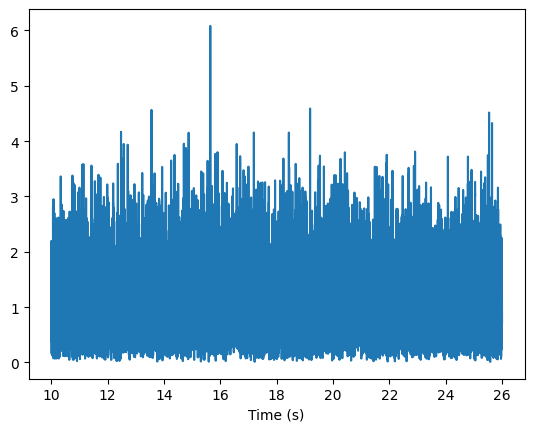

In [39]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [40]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [41]:
data = label_L[1]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW151226_L_data.npy', structured_array)

In [42]:
data = np.load('GW151226_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0  4.688523e-20  noise
1  6.779541e-20  noise
2 -4.303392e-20  noise
3 -5.668465e-20  noise
4  4.408176e-20  noise


In [43]:
#GW170104
#H
strain_H_event = TimeSeries(strain_H_data[3], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 31
m2 = 20
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.59619140625s with SNR 7.029116460855521


In [44]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [45]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [46]:
data = label_H[2]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW170104_H_data.npy', structured_array)

In [47]:
data = np.load('GW170104_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0  1.614668e-20  noise
1 -5.266533e-22  noise
2  1.551490e-20  noise
3  1.244295e-21  noise
4  1.419411e-20  noise


In [48]:
#GW170104
#L
strain_L_event = TimeSeries(strain_L_data[3], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 31
m2 = 20
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.59765625s with SNR 6.727796602773837


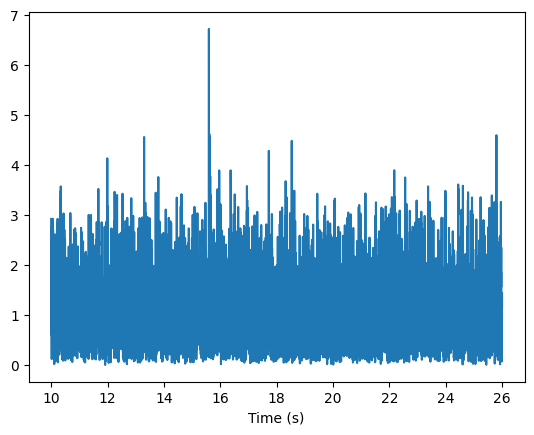

In [49]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [50]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [51]:
data = label_L[2]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW170104_L_data.npy', structured_array)

In [52]:
data = np.load('GW170104_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -1.091683e-20  noise
1  1.254557e-21  noise
2  1.572155e-20  noise
3  3.243756e-21  noise
4 -1.142426e-20  noise


In [53]:
#GW170608
#H
strain_H_event = TimeSeries(strain_H_data[4], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 11
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.5205078125s with SNR 6.819185916931616


In [54]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [55]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [56]:
outer_index = 0
for outer_index, label_data in enumerate(label_H):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 0 Inner Index: 11102 Value: 7.321302780751619e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11103 Value: -1.7116590847526058e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11104 Value: 4.8509888351912674e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11105 Value: -1.8135905710248954e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11106 Value: 6.746491599546971e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11107 Value: -1.3500522154112512e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11108 Value: 4.562777784926023e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11109 Value: -1.3789431082746903e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11110 Value: 3.714024168385841e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11111 Value: -8.31047938732483e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11112 Value: 3.1896166320371166e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11113 Value: -8.058548179101926e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 1

In [57]:
data = label_H[3]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW170608_H_data.npy', structured_array)

In [58]:
data = np.load('GW170608_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0 -2.226541e-19  noise
1  1.041109e-20  noise
2 -2.025575e-19  noise
3 -9.909083e-21  noise
4 -2.132504e-19  noise


In [59]:
#GW170608
#L
strain_L_event = TimeSeries(strain_L_data[4], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 11
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.5s with SNR 5.619003956596518


In [60]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [61]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [62]:
for outer_index, label_data in enumerate(label_L):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 0 Inner Index: 11088 Value: 6.292604230899734e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11089 Value: 8.351103453029199e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11090 Value: 6.307825692254379e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11091 Value: 2.3294770844308187e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11092 Value: 6.707721112278376e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11093 Value: 8.459772204651213e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11094 Value: 6.529991068876726e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11095 Value: 2.6203006265391668e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11096 Value: 7.064900086930717e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11097 Value: 8.203941049029816e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11098 Value: 6.202433590227676e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11099 Value: 2.4919405469294073e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11100 Val

In [63]:
data = label_L[3]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW170608_L_data.npy', structured_array)

In [64]:
data = np.load('GW170608_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -4.692068e-21  noise
1  2.458364e-21  noise
2  2.073577e-21  noise
3 -4.914504e-21  noise
4 -5.164921e-21  noise


In [65]:
#GW170729
#H
strain_H_event = TimeSeries(strain_H_data[5], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 50
m2 = 34
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.32080078125s with SNR 5.504170860161338


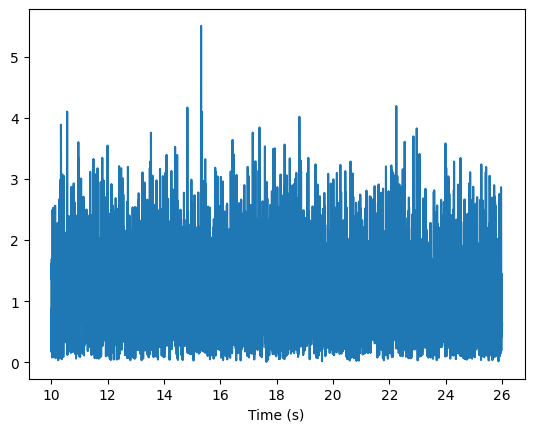

In [66]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [67]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [68]:
data = label_H[4]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW170729_H_data.npy', structured_array)

In [69]:
data = np.load('GW170729_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0  3.696562e-21  noise
1  4.121383e-21  noise
2  1.135890e-20  noise
3 -3.257087e-21  noise
4  1.812208e-20  noise


In [70]:
#GW170608
#L
strain_L_event = TimeSeries(strain_L_data[5], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 50
m2 = 34
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.318359375s with SNR 6.459694920463166


In [71]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [72]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [73]:
data = label_L[4]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW170729_L_data.npy', structured_array)

In [74]:
data = np.load('GW170729_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0  2.314629e-21  noise
1 -4.502248e-21  noise
2 -6.375361e-22  noise
3  5.191483e-21  noise
4  2.090762e-21  noise


In [75]:
#GW170729
#V
strain_V_event = TimeSeries(strain_V_data[0], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 50
m2 = 34
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 18.20849609375s with SNR 6.611659819951932


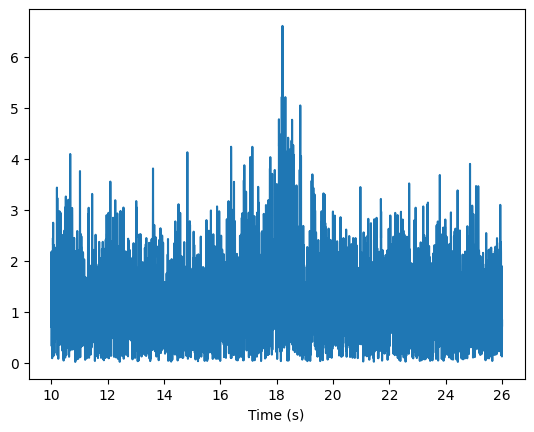

In [76]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [77]:
for value_strain, value_snr in zip(strain_V_event_array, snr_values):
    if value_snr >= 5:
        label_V_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_V_values.append((value_strain, "noise"))
label_V.append(label_V_values)

In [78]:

for outer_index, label_data in enumerate(label_V):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 0 Inner Index: 16758 Value: 1.0372883330661133e-19 Label: noise+BBH
Outer Index: 0 Inner Index: 16759 Value: 9.743693242191305e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 16760 Value: 1.0547848774832917e-19 Label: noise+BBH
Outer Index: 0 Inner Index: 16761 Value: 8.317051026397907e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 16806 Value: -6.208623897486273e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 16807 Value: -7.196252468852734e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 16808 Value: -7.608948785138831e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 16809 Value: -8.91794737365787e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 16810 Value: -7.9707541493153e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 16811 Value: -6.99532328414617e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 16812 Value: -6.794073618943719e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 16813 Value: -6.338664640215221e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 16814 

In [79]:
data = label_V[0]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_V', float), ('Label', 'U10')])
np.save('GW170729_V_data.npy', structured_array)

In [80]:
data = np.load('GW170729_V_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_V  Label
0 -1.169777e-19  noise
1 -1.031238e-19  noise
2 -8.677333e-20  noise
3 -8.213626e-20  noise
4 -9.318084e-20  noise


In [81]:
#GW170809
#H
strain_H_event = TimeSeries(strain_H_data[6], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 35
m2 = 24
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.7509765625s with SNR 5.981966749082758


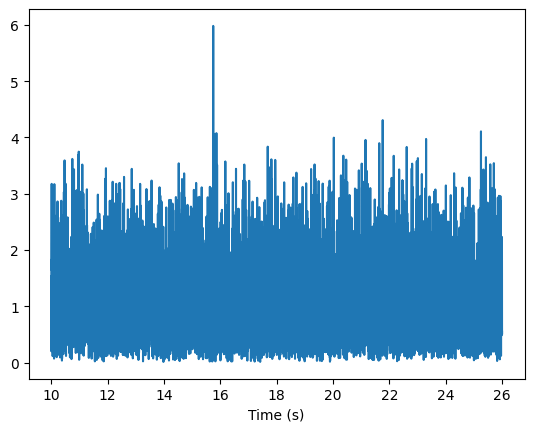

In [82]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [83]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [84]:
data = label_H[5]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW170809_H_data.npy', structured_array)

In [85]:
data = np.load('GW170809_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0  2.231555e-20  noise
1 -2.039605e-21  noise
2  2.118639e-20  noise
3  8.359893e-22  noise
4  1.658872e-20  noise


In [86]:
#GW170809
#L
strain_L_event = TimeSeries(strain_L_data[6], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 35
m2 = 24
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.74267578125s with SNR 6.38653656120859


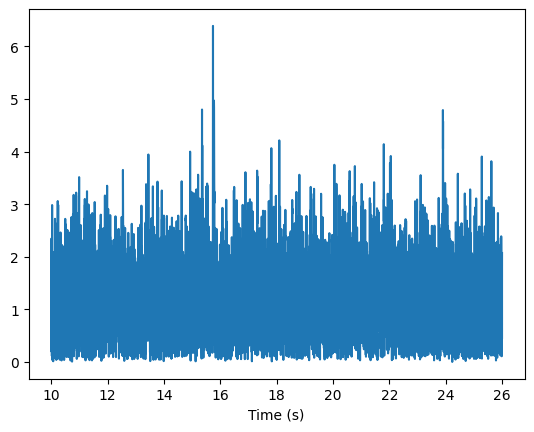

In [87]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [88]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [89]:
data = label_L[5]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW170809_L_data.npy', structured_array)

In [90]:
data = np.load('GW170809_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -3.309938e-21  noise
1 -4.190306e-21  noise
2 -1.831784e-21  noise
3 -4.526390e-22  noise
4 -3.162759e-21  noise


In [91]:
#GW170809
#V
strain_V_event = TimeSeries(strain_V_data[1], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 35
m2 = 24
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 18.845703125s with SNR 4.831472539323209


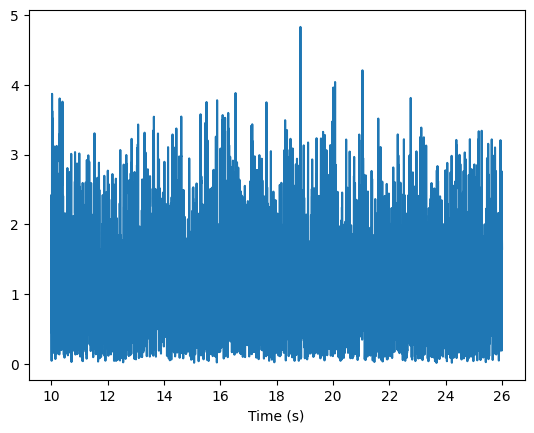

In [92]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла поради слаб SNR.

In [93]:
#GW170814
#H
strain_H_event = TimeSeries(strain_H_data[7], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 31
m2 = 25
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.53173828125s with SNR 8.59165059878178


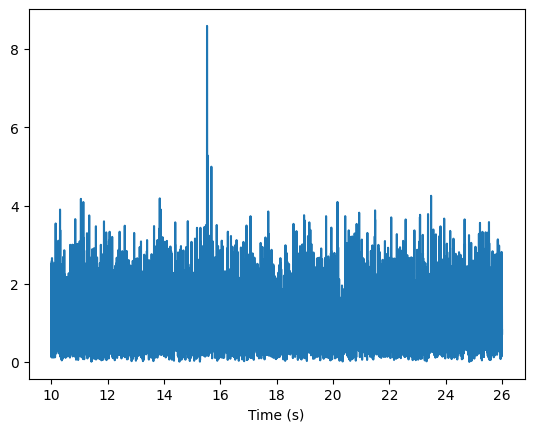

In [94]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [95]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [96]:

for outer_index, label_data in enumerate(label_H):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 0 Inner Index: 11102 Value: 7.321302780751619e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11103 Value: -1.7116590847526058e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11104 Value: 4.8509888351912674e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11105 Value: -1.8135905710248954e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11106 Value: 6.746491599546971e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11107 Value: -1.3500522154112512e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11108 Value: 4.562777784926023e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11109 Value: -1.3789431082746903e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11110 Value: 3.714024168385841e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11111 Value: -8.31047938732483e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11112 Value: 3.1896166320371166e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11113 Value: -8.058548179101926e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 1

In [97]:
data = label_H[6]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW170814_H_data.npy', structured_array)

In [98]:
data = np.load('GW170814_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0 -2.588793e-20  noise
1  3.545226e-21  noise
2 -2.706247e-20  noise
3  4.578329e-21  noise
4 -2.863639e-20  noise


In [99]:
#GW170814
#L
strain_L_event = TimeSeries(strain_L_data[7], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 31
m2 = 25
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.52392578125s with SNR 10.26675677136012


In [100]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [101]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [102]:

for outer_index, label_data in enumerate(label_L):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 0 Inner Index: 11088 Value: 6.292604230899734e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11089 Value: 8.351103453029199e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11090 Value: 6.307825692254379e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11091 Value: 2.3294770844308187e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11092 Value: 6.707721112278376e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11093 Value: 8.459772204651213e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11094 Value: 6.529991068876726e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11095 Value: 2.6203006265391668e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11096 Value: 7.064900086930717e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11097 Value: 8.203941049029816e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11098 Value: 6.202433590227676e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11099 Value: 2.4919405469294073e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11100 Val

In [103]:
data = label_L[6]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW170814_L_data.npy', structured_array)

In [104]:
data = np.load('GW170814_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0  7.281016e-22  noise
1  1.792699e-21  noise
2  3.060431e-21  noise
3  2.393586e-21  noise
4  2.027559e-22  noise


In [105]:
#GW170814
#V
strain_V_event = TimeSeries(strain_V_data[2], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 31
m2 = 25
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 22.5634765625s with SNR 4.645843483702787


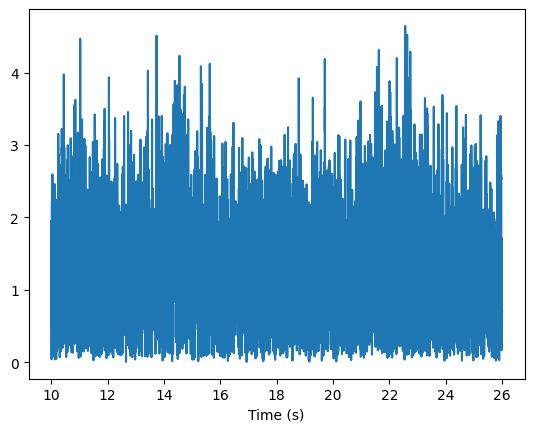

In [106]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла поради слаб SNR

In [107]:
#GW170817
#H
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 1.45
m2 = 1.3
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 16.69384765625s with SNR 3.829634913138197


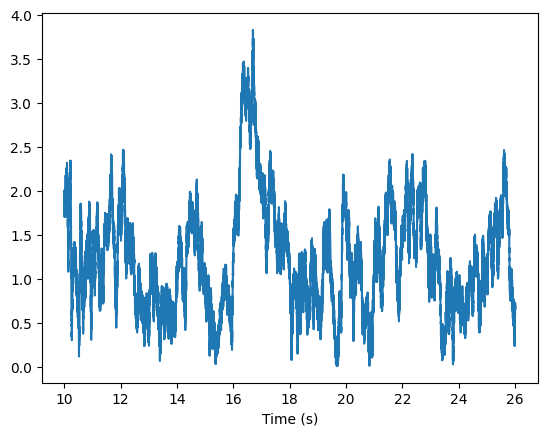

In [108]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Тука се намалува границата за SNR на 3 за да може да се долови настанот.

In [109]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 3:
        label_H_values.append((value_strain, "noise+BNS")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [110]:

for outer_index, label_data in enumerate(label_H):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BNS":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 7 Inner Index: 12847 Value: 9.214353760363995e-21 Label: noise+BNS
Outer Index: 7 Inner Index: 12888 Value: 1.5131702237911493e-20 Label: noise+BNS
Outer Index: 7 Inner Index: 12889 Value: 1.4717768416441414e-20 Label: noise+BNS
Outer Index: 7 Inner Index: 12890 Value: 1.3588077206167478e-20 Label: noise+BNS
Outer Index: 7 Inner Index: 12891 Value: 1.485976506470416e-20 Label: noise+BNS
Outer Index: 7 Inner Index: 12892 Value: 1.1307947341551595e-20 Label: noise+BNS
Outer Index: 7 Inner Index: 12893 Value: 1.578958301486942e-20 Label: noise+BNS
Outer Index: 7 Inner Index: 12894 Value: 9.429962864691897e-21 Label: noise+BNS
Outer Index: 7 Inner Index: 12895 Value: 1.6354419481161885e-20 Label: noise+BNS
Outer Index: 7 Inner Index: 12896 Value: 8.816435562363138e-21 Label: noise+BNS
Outer Index: 7 Inner Index: 12897 Value: 1.621876286429466e-20 Label: noise+BNS
Outer Index: 7 Inner Index: 12898 Value: 6.766339933903442e-21 Label: noise+BNS
Outer Index: 7 Inner Index: 12899 V

Како што е очекувано, има многу повеќе вредности на сигнал+шум во однос на претходните примери бидејќи BNS сигналите траат далеку подолго од BBH

In [111]:
data = label_H[7]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW170817_H_data.npy', structured_array)

In [112]:
data = np.load('GW170817_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0 -5.196739e-22  noise
1 -8.657016e-21  noise
2  2.851052e-21  noise
3 -8.065018e-21  noise
4  4.715748e-21  noise


In [113]:
#GW170817
#L
strain_L_event = TimeSeries(strain_L_data[8], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 1.45
m2 = 1.3
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 22.1884765625s with SNR 7.078787135662712


In [114]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Од LIGO е јавно објавено дека постои интензивен инструментален шум кој го препокрива целосно сигналот, па затоа се отфрлаат податоците од Livingston бидејќи нема точно да се обележат.

In [115]:
#GW170817
#V
strain_V_event = TimeSeries(strain_V_data[3], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 1.45
m2 = 1.3
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 23.98681640625s with SNR 3.3393415516363203


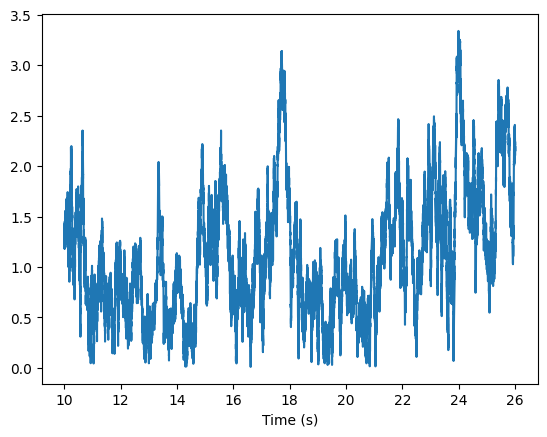

In [116]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла и од Virgo поради тоа што има голем скок и малку пред 18-та секунда и може да означи мноху точки и таму како сигнал+шум иако е само шум.

In [117]:
#GW170818
#H
strain_H_event = TimeSeries(strain_H_data[9], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 35
m2 = 27
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 16.72412109375s with SNR 5.042986406636609


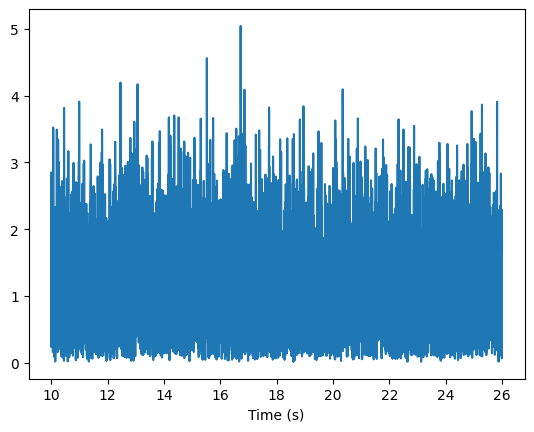

In [118]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [119]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [120]:

for outer_index, label_data in enumerate(label_H):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 0 Inner Index: 11102 Value: 7.321302780751619e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11103 Value: -1.7116590847526058e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11104 Value: 4.8509888351912674e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11105 Value: -1.8135905710248954e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11106 Value: 6.746491599546971e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11107 Value: -1.3500522154112512e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11108 Value: 4.562777784926023e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11109 Value: -1.3789431082746903e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11110 Value: 3.714024168385841e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11111 Value: -8.31047938732483e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11112 Value: 3.1896166320371166e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11113 Value: -8.058548179101926e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 1

Само една точка има сигнал+шум --> се отфрла податокот од Hanford, не носи многу корисни информации и е доста слаб.

In [121]:
del(label_H[8])

In [122]:

for outer_index, label_data in enumerate(label_H):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 0 Inner Index: 11102 Value: 7.321302780751619e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11103 Value: -1.7116590847526058e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11104 Value: 4.8509888351912674e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11105 Value: -1.8135905710248954e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11106 Value: 6.746491599546971e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11107 Value: -1.3500522154112512e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11108 Value: 4.562777784926023e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11109 Value: -1.3789431082746903e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11110 Value: 3.714024168385841e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11111 Value: -8.31047938732483e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11112 Value: 3.1896166320371166e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11113 Value: -8.058548179101926e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 1

In [123]:
#GW170818
#L
strain_L_event = TimeSeries(strain_L_data[9], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 35
m2 = 27
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.07763671875s with SNR 7.2365920679603715


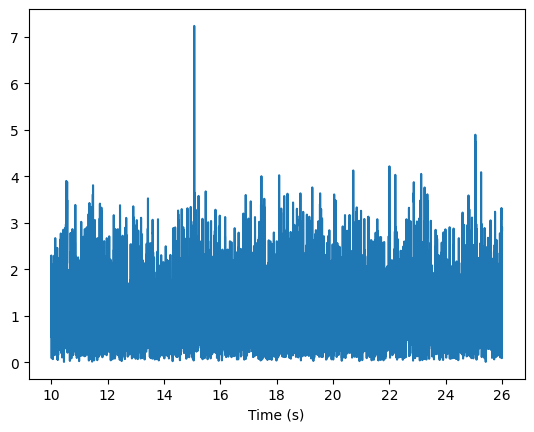

In [124]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [125]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [126]:

for outer_index, label_data in enumerate(label_L):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 0 Inner Index: 11088 Value: 6.292604230899734e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11089 Value: 8.351103453029199e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11090 Value: 6.307825692254379e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11091 Value: 2.3294770844308187e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11092 Value: 6.707721112278376e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11093 Value: 8.459772204651213e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11094 Value: 6.529991068876726e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11095 Value: 2.6203006265391668e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11096 Value: 7.064900086930717e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11097 Value: 8.203941049029816e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11098 Value: 6.202433590227676e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11099 Value: 2.4919405469294073e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11100 Val

In [127]:
data = label_L[7]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW170818_L_data.npy', structured_array)

In [128]:
data = np.load('GW170818_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0  5.190553e-22  noise
1 -1.160697e-21  noise
2  1.456234e-21  noise
3  2.753910e-21  noise
4  9.038692e-23  noise


In [129]:
#GW170818
#V
strain_V_event = TimeSeries(strain_V_data[4], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 35
m2 = 27
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 25.9833984375s with SNR 4.548429251299948


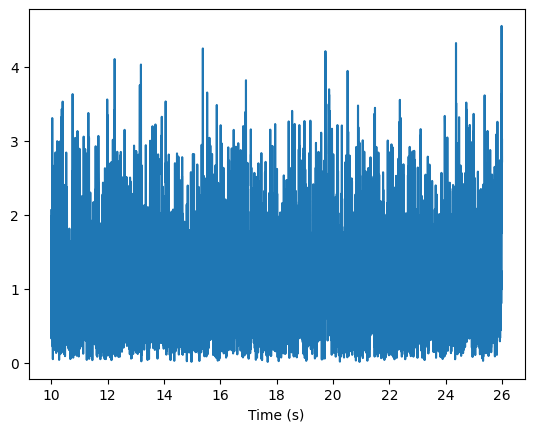

In [130]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo е слаб --> се отфрла

In [131]:
#GW170823
#H
strain_H_event = TimeSeries(strain_H_data[10], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 40
m2 = 29
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.51416015625s with SNR 6.3860914217772455


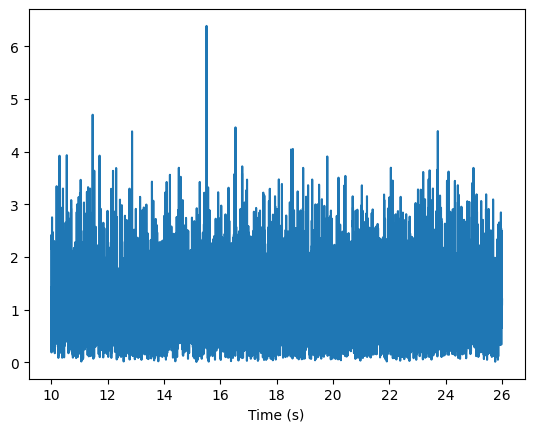

In [132]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [133]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [134]:

for outer_index, label_data in enumerate(label_H):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 0 Inner Index: 11102 Value: 7.321302780751619e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11103 Value: -1.7116590847526058e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11104 Value: 4.8509888351912674e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11105 Value: -1.8135905710248954e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11106 Value: 6.746491599546971e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11107 Value: -1.3500522154112512e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11108 Value: 4.562777784926023e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11109 Value: -1.3789431082746903e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11110 Value: 3.714024168385841e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11111 Value: -8.31047938732483e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11112 Value: 3.1896166320371166e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11113 Value: -8.058548179101926e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 1

In [135]:
data = label_H[8]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW170823_H_data.npy', structured_array)

In [136]:
data = np.load('GW170823_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0 -2.842656e-20  noise
1  1.281820e-20  noise
2 -2.874685e-20  noise
3  1.019526e-20  noise
4 -2.935241e-20  noise


In [137]:
#GW170823
#L
strain_L_event = TimeSeries(strain_L_data[10], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 40
m2 = 29
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.51611328125s with SNR 6.820277948648432


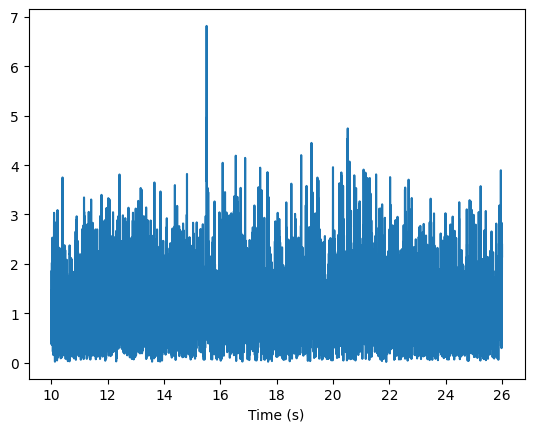

In [138]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [139]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [140]:
data = label_L[8]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW170823_L_data.npy', structured_array)

In [141]:
data = np.load('GW170823_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -1.758851e-21  noise
1 -4.231800e-21  noise
2  7.843470e-23  noise
3  2.847302e-21  noise
4 -1.488474e-21  noise


In [142]:
#GW190403_051519
#H
strain_H_event = TimeSeries(strain_H_data[11], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 85
m2 = 20
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 18.154296875s with SNR 4.021881658547856


In [143]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Hanford се отфрла поради слаба вредност на SNR.

In [144]:
#GW190403_051519
#L
strain_L_event = TimeSeries(strain_L_data[11], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 85
m2 = 20
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.20361328125s with SNR 5.287330955246434


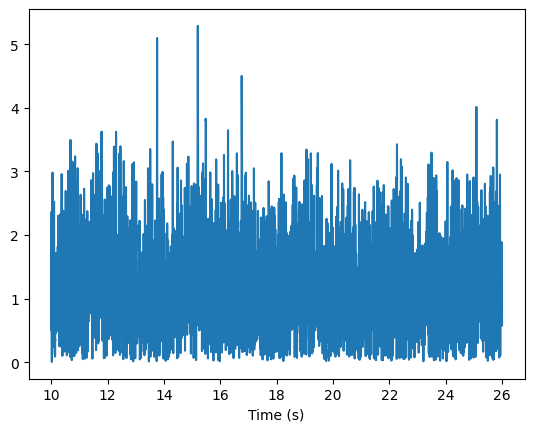

In [145]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Има изразит шум измеѓу 13s и 14s што може да доведе до голем број на грешни лабели, така да поради слабата детекција се отфрла настанот.

In [146]:
#GW190408_181802
#H
strain_H_event = TimeSeries(strain_H_data[12], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 25
m2 = 19
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.2841796875s with SNR 6.768384460340616


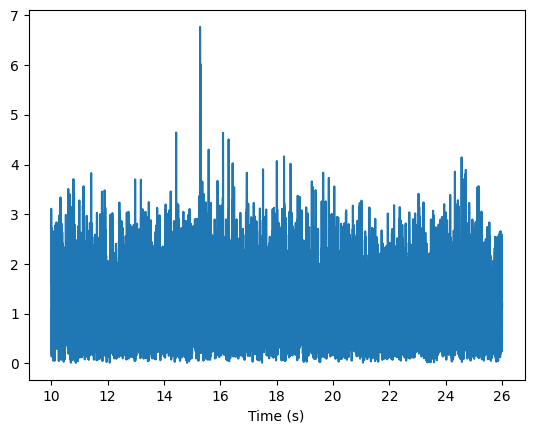

In [147]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [148]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [149]:
data = label_H[9]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190408_181802_H_data.npy', structured_array)

In [150]:
data = np.load('GW190408_181802_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0  6.955889e-21  noise
1  6.870356e-21  noise
2  4.777990e-21  noise
3  3.439824e-21  noise
4  6.425480e-21  noise


In [151]:
#GW190408_181802
#L
strain_L_event = TimeSeries(strain_L_data[12], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 25
m2 = 19
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.287109375s with SNR 6.420476622774711


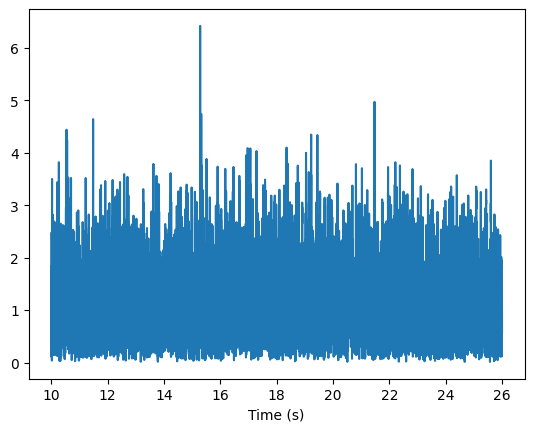

In [152]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [153]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [154]:
data = label_L[9]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190408_181802_L_data.npy', structured_array)

In [155]:
data = np.load('GW190408_181802_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0  8.866499e-21  noise
1  8.597528e-21  noise
2  1.060436e-20  noise
3  1.036455e-20  noise
4  7.917541e-21  noise


In [156]:
#GW190408_181802
#V
strain_V_event = TimeSeries(strain_V_data[5], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 25
m2 = 19
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 13.38671875s with SNR 4.184137397620475


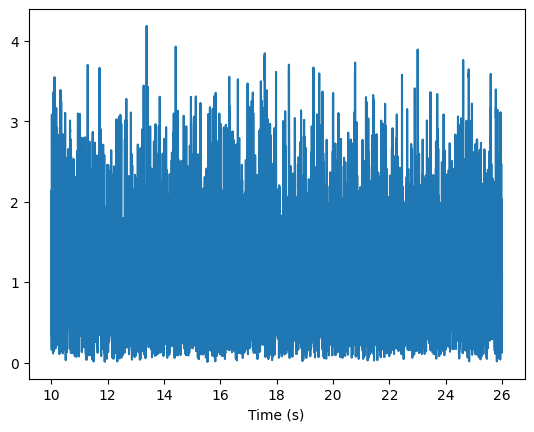

In [157]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Слаб е сигналот од Virgo --> се отфрла.

In [158]:
#GW190412
#H
strain_H_event = TimeSeries(strain_H_data[13], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 28
m2 = 9
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.166015625s with SNR 7.251335824807273


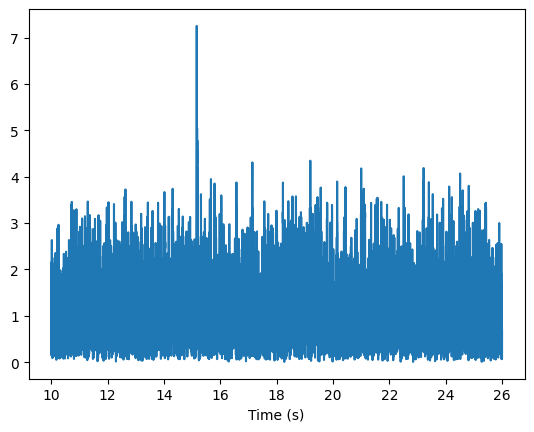

In [159]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [160]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [161]:
for outer_index, label_data in enumerate(label_H):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 0 Inner Index: 11102 Value: 7.321302780751619e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11103 Value: -1.7116590847526058e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11104 Value: 4.8509888351912674e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11105 Value: -1.8135905710248954e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11106 Value: 6.746491599546971e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11107 Value: -1.3500522154112512e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11108 Value: 4.562777784926023e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11109 Value: -1.3789431082746903e-20 Label: noise+BBH
Outer Index: 0 Inner Index: 11110 Value: 3.714024168385841e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11111 Value: -8.31047938732483e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11112 Value: 3.1896166320371166e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 11113 Value: -8.058548179101926e-21 Label: noise+BBH
Outer Index: 0 Inner Index: 1

In [162]:
data = label_H[10]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190412_H_data.npy', structured_array)

In [163]:
data = np.load('GW190412_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0  4.091573e-21  noise
1  7.873332e-21  noise
2  6.609145e-21  noise
3  9.413418e-21  noise
4  2.459218e-21  noise


In [164]:
#GW190412
#L
strain_L_event = TimeSeries(strain_L_data[13], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 28
m2 = 9
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.162109375s with SNR 9.097916266750964


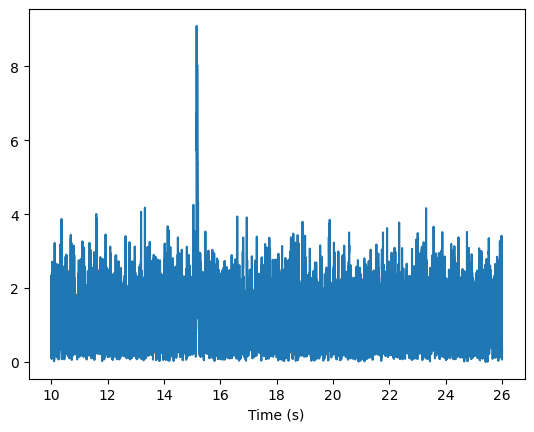

In [165]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [166]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [167]:
data = label_L[10]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190412_L_data.npy', structured_array)

In [168]:
data = np.load('GW190412_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0  1.817591e-20  noise
1  1.070266e-20  noise
2  1.015551e-20  noise
3  1.777375e-20  noise
4  1.691709e-20  noise


In [169]:
#GW190412
#V
strain_V_event = TimeSeries(strain_V_data[6], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 28
m2 = 9
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 17.736328125s with SNR 4.842104210915509


In [170]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [171]:
#GW190413_052954
#H
strain_H_event = TimeSeries(strain_H_data[14], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 38
m2 = 24
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.4990234375s with SNR 4.953068151589686


In [172]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [173]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 4.5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [174]:
data = label_H[11]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190413_052954_H_data.npy', structured_array)

In [175]:
data = np.load('GW190413_052954_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0 -7.493699e-21  noise
1 -5.662145e-21  noise
2 -1.153025e-20  noise
3 -7.347376e-21  noise
4 -7.069528e-21  noise


In [176]:
#GW190413_052954
#L
strain_L_event = TimeSeries(strain_L_data[14], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 38
m2 = 24
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 18.08984375s with SNR 4.384167046010825


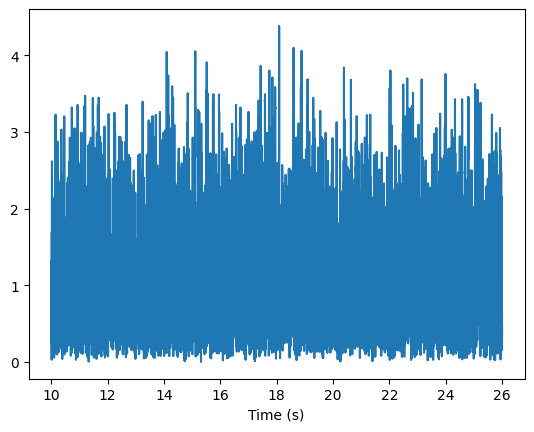

In [177]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Livingston се отфрла.

In [178]:
#GW190413_134308
#H
strain_H_event = TimeSeries(strain_H_data[15], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 51
m2 = 30
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.73486328125s with SNR 4.9136250700171376


In [179]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Hanford се отфрла.

In [180]:
#GW190413_134308
#L
strain_L_event = TimeSeries(strain_L_data[15], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 51
m2 = 30
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.7392578125s with SNR 5.552248581685155


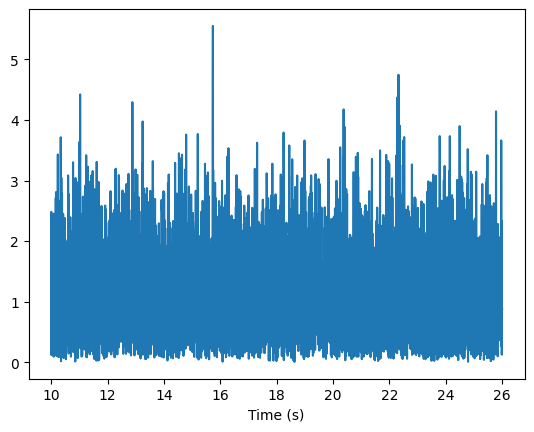

In [181]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [182]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [183]:
data = label_L[11]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190413_134308_L_data.npy', structured_array)

In [184]:
data = np.load('GW190413_134308_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -3.628277e-21  noise
1 -2.220477e-22  noise
2 -2.719825e-23  noise
3 -1.947470e-21  noise
4 -2.135545e-22  noise


In [185]:
#GW190413_134308
#V
strain_V_event = TimeSeries(strain_V_data[7], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 51
m2 = 30
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 17.751953125s with SNR 4.303477073704437


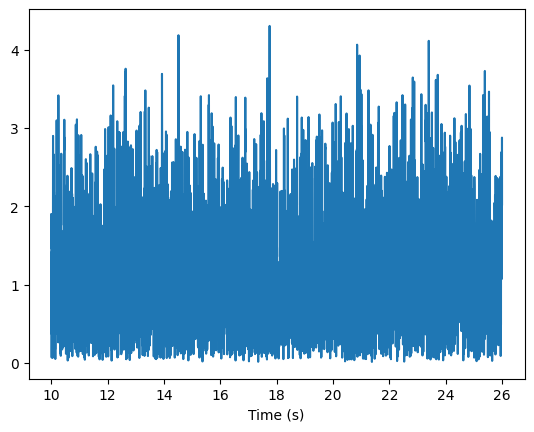

In [186]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [187]:
#GW190421_213856
#H
strain_H_event = TimeSeries(strain_H_data[16], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 42
m2 = 32
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.25830078125s with SNR 5.39851694199523


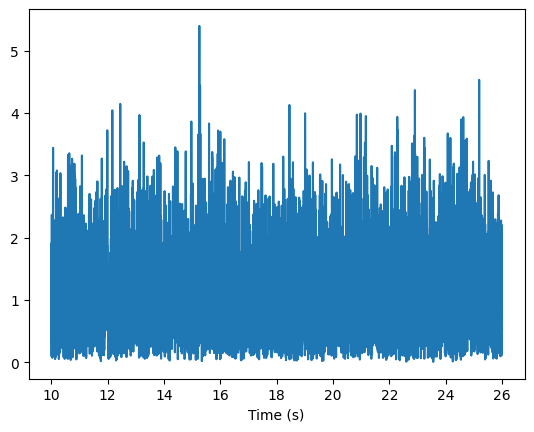

In [188]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [189]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [190]:
data = label_H[12]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190421_213856_H_data.npy', structured_array)

In [191]:
data = np.load('GW190421_213856_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0  9.057012e-21  noise
1  6.512373e-21  noise
2  3.993230e-21  noise
3  7.867410e-21  noise
4  9.252837e-21  noise


In [192]:
#GW190421_213856
#L
strain_L_event = TimeSeries(strain_L_data[16], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 42
m2 = 32
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.25048828125s with SNR 4.668738456851382


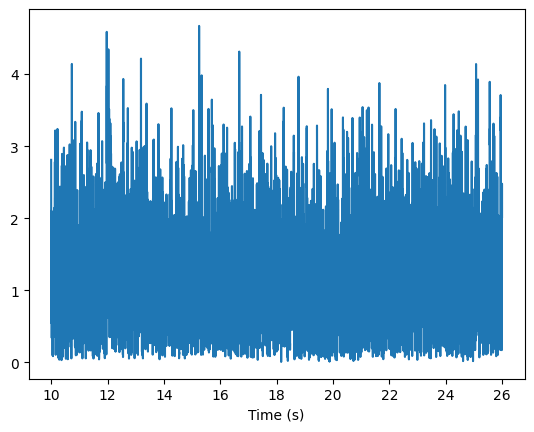

In [193]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Livingston се отфрла.

In [194]:
#GW190425
#L
strain_L_event = TimeSeries(strain_L_data[17], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 2.1
m2 = 1.3
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=30)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 17.798828125s with SNR 5.193257243669935


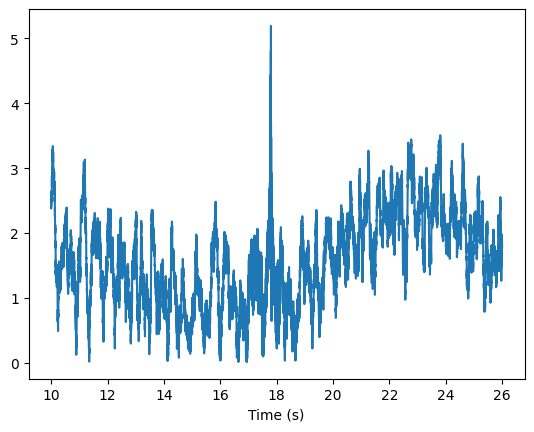

In [195]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [196]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 4:
        label_L_values.append((value_strain, "noise+BNS")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [197]:
for outer_index, label_data in enumerate(label_L):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BNS":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 12 Inner Index: 15952 Value: -1.8061760884833664e-20 Label: noise+BNS
Outer Index: 12 Inner Index: 15956 Value: -1.7143443091333086e-20 Label: noise+BNS
Outer Index: 12 Inner Index: 15960 Value: -1.7053605522586336e-20 Label: noise+BNS
Outer Index: 12 Inner Index: 15964 Value: -1.5885898852241843e-20 Label: noise+BNS
Outer Index: 12 Inner Index: 15968 Value: -1.5164956551234698e-20 Label: noise+BNS
Outer Index: 12 Inner Index: 15972 Value: -1.4197253357208946e-20 Label: noise+BNS
Outer Index: 12 Inner Index: 15973 Value: -9.84849699264166e-21 Label: noise+BNS
Outer Index: 12 Inner Index: 15975 Value: 1.4316152980350035e-21 Label: noise+BNS


In [198]:
data = label_L[12]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190425_L_data.npy', structured_array)

In [199]:
data = np.load('GW190425_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0  6.825177e-21  noise
1 -7.827804e-21  noise
2 -8.677983e-21  noise
3  5.202210e-21  noise
4  4.965666e-21  noise


In [200]:
#GW190425
#V
strain_V_event = TimeSeries(strain_V_data[8], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 2.1
m2 = 1.3
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=30)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 17.7998046875s with SNR 5.091914336251654


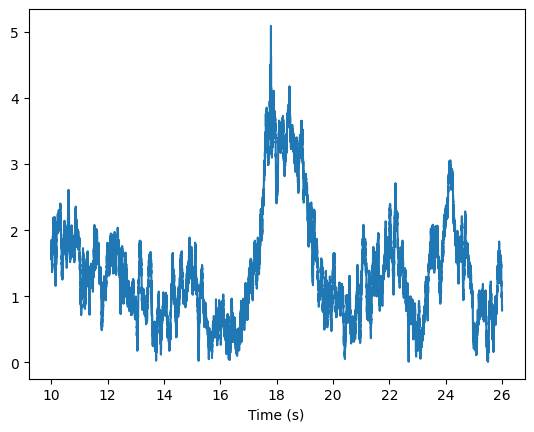

In [201]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [202]:
for value_strain, value_snr in zip(strain_V_event_array, snr_values):
    if value_snr >= 4.5:
        label_V_values.append((value_strain, "noise+BNS")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_V_values.append((value_strain, "noise"))
label_V.append(label_V_values)

In [203]:
for outer_index, label_data in enumerate(label_V):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+BNS":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 1 Inner Index: 15949 Value: 1.752827653373839e-20 Label: noise+BNS
Outer Index: 1 Inner Index: 15963 Value: 1.8098791320972378e-20 Label: noise+BNS
Outer Index: 1 Inner Index: 15970 Value: -2.6628101485209842e-20 Label: noise+BNS
Outer Index: 1 Inner Index: 15974 Value: -1.0895964432530301e-20 Label: noise+BNS
Outer Index: 1 Inner Index: 15979 Value: -2.0540489474109585e-20 Label: noise+BNS


In [204]:
data = label_V[1]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_V', float), ('Label', 'U10')])
np.save('GW190425_V_data.npy', structured_array)

In [205]:
data = np.load('GW190425_V_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_V  Label
0 -7.974577e-21  noise
1  1.266392e-20  noise
2  7.595419e-21  noise
3 -3.372798e-21  noise
4 -1.109889e-20  noise


In [206]:
#GW190426_190642
#H
strain_H_event = TimeSeries(strain_H_data[17], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 106
m2 = 76
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 12.9013671875s with SNR 4.2349590475971715


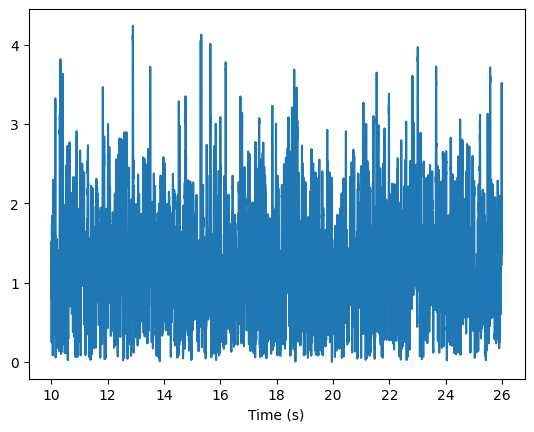

In [207]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Hanford се отфрла.

In [208]:
#GW190426_190642
#L
strain_L_event = TimeSeries(strain_L_data[18], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 106
m2 = 76
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=10)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.640625s with SNR 5.244648801833373


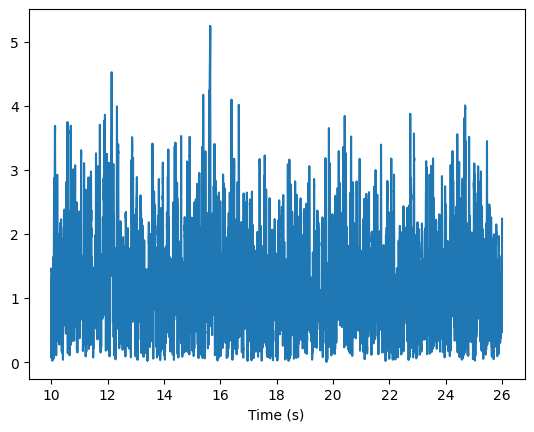

In [209]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [210]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [211]:
data = label_L[13]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190426_190642_L_data.npy', structured_array)

In [212]:
data = np.load('GW190426_190642_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0  1.459648e-20  noise
1  2.834952e-20  noise
2  1.824171e-20  noise
3  3.853706e-21  noise
4  1.364692e-20  noise


In [213]:
#GW190503_185404
#H
strain_H_event = TimeSeries(strain_H_data[18], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 41
m2 = 28
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.294921875s with SNR 7.573044613374344


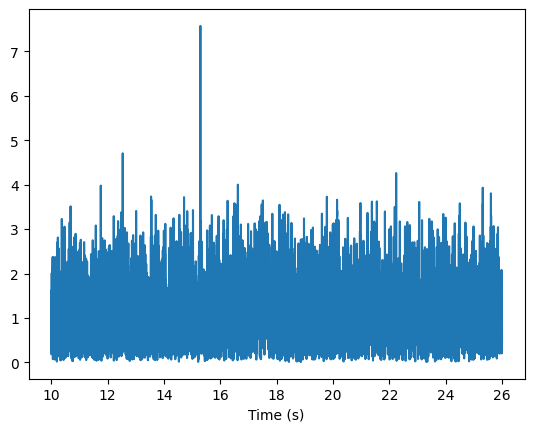

In [214]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [215]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [216]:
data = label_H[13]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190503_185404_H_data.npy', structured_array)

In [217]:
data = np.load('GW190503_185404_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0  6.574092e-22  noise
1  3.625480e-21  noise
2  3.134330e-21  noise
3  5.459517e-21  noise
4  1.491049e-21  noise


In [218]:
#GW190503_185404
#L
strain_L_event = TimeSeries(strain_L_data[19], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 41
m2 = 28
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.28564453125s with SNR 6.119903849346007


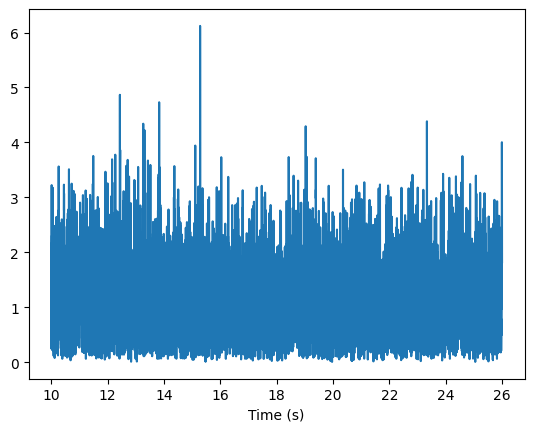

In [219]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [220]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [221]:
data = label_L[14]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190503_185404_L_data.npy', structured_array)

In [222]:
data = np.load('GW190503_185404_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0  2.274926e-21  noise
1 -3.353856e-20  noise
2 -3.648751e-21  noise
3  3.340865e-20  noise
4  3.432366e-21  noise


In [223]:
#GW190503_185404
#V
strain_V_event = TimeSeries(strain_V_data[9], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 41
m2 = 28
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 17.0849609375s with SNR 4.55737920666304


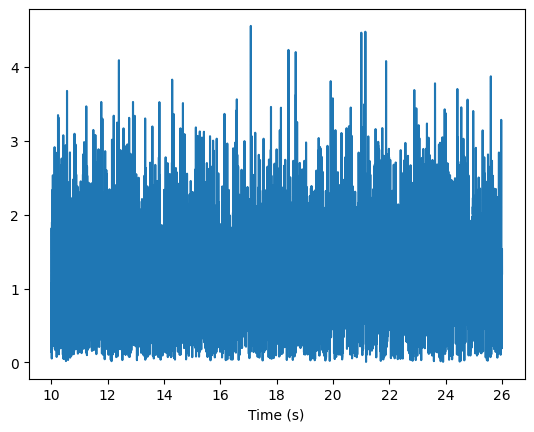

In [224]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [225]:
#GW190512_180714
#H
strain_H_event = TimeSeries(strain_H_data[19], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 23
m2 = 13
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 14.4912109375s with SNR 4.583057998278905


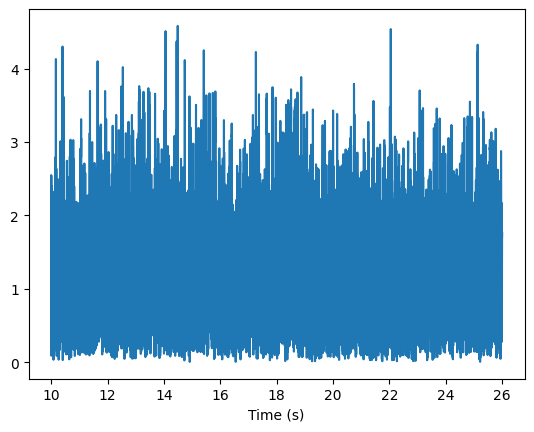

In [226]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Hanford се отфрла.

In [227]:
#GW190512_180714
#L
strain_L_event = TimeSeries(strain_L_data[20], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 23
m2 = 13
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 19.36865234375s with SNR 6.213083288907619


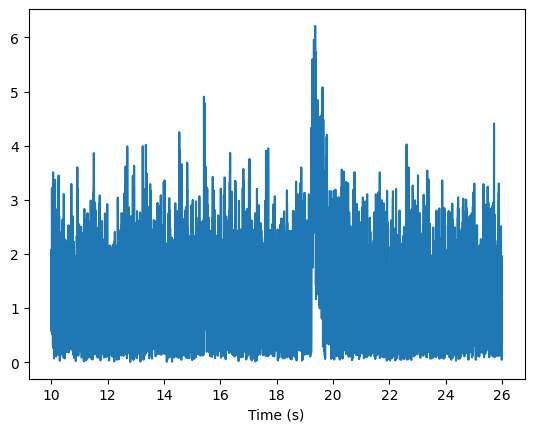

In [228]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Ќе се отфрли и овој сигнал поради „дупката“ која се јавува кај 19-та секунда што прави да има неконзистентни точки означени како шум+сигнал.

In [229]:
#GW190512_180714
#V
strain_V_event = TimeSeries(strain_V_data[10], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 23
m2 = 13
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 24.7392578125s with SNR 4.442332209572048


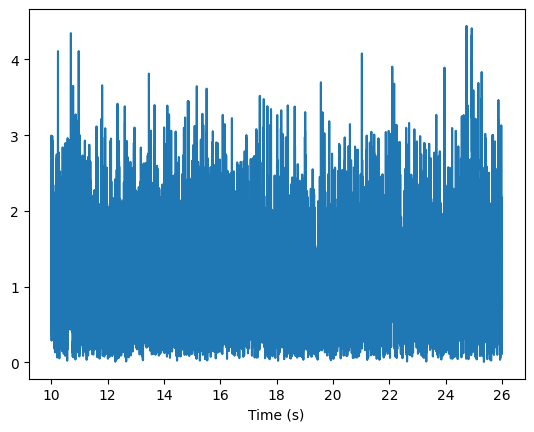

In [230]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

И сигналот од Virgo се отфрла, со што се отфрла целиот настан.

In [231]:
#GW190513_205428
#H
strain_H_event = TimeSeries(strain_H_data[20], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 36
m2 = 18
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.7451171875s with SNR 6.928114754578998


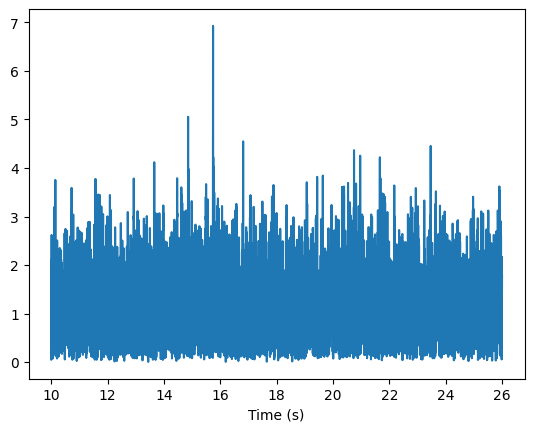

In [232]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [233]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5.5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [234]:
data = label_H[14]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190513_205428_H_data.npy', structured_array)

In [235]:
data = np.load('GW190513_205428_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0 -2.613376e-21  noise
1 -1.353894e-20  noise
2 -9.172300e-22  noise
3 -8.598766e-21  noise
4 -2.779868e-21  noise


In [236]:
#GW190513_205428
#L
strain_L_event = TimeSeries(strain_L_data[21], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 36
m2 = 18
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 10.44482421875s with SNR 5.494188151792214


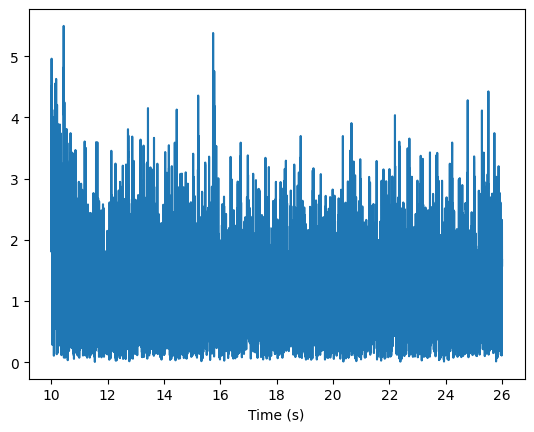

In [237]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Livingston се отфрла.

In [238]:
#GW190513_205428
#V
strain_V_event = TimeSeries(strain_V_data[11], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 36
m2 = 18
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 13.1337890625s with SNR 4.644974865981304


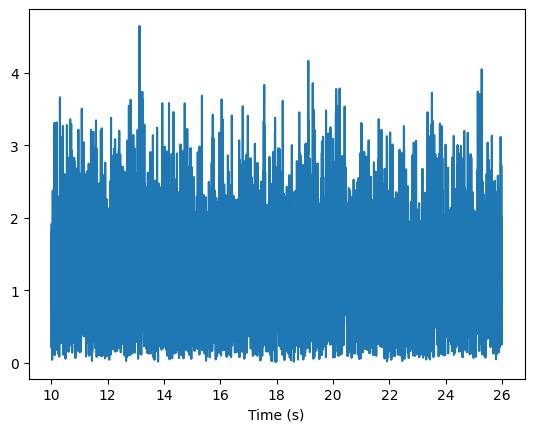

In [239]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [240]:
#GW190514_065416
#H
strain_H_event = TimeSeries(strain_H_data[21], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 41
m2 = 28
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.84716796875s with SNR 4.787483542275722


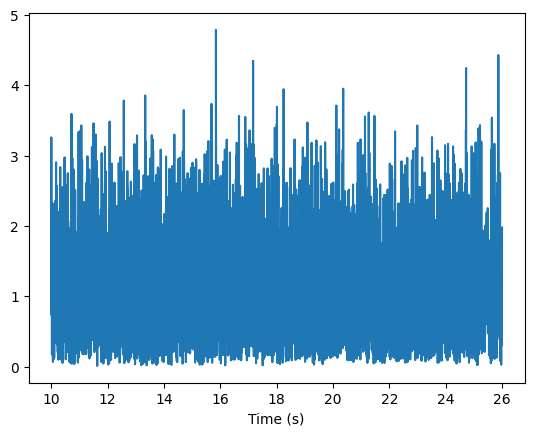

In [241]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Hanford е слаб, се отфрла.

In [242]:
#GW190514_065416
#L
strain_L_event = TimeSeries(strain_L_data[22], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 41
m2 = 28
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 17.02490234375s with SNR 4.8578755086553365


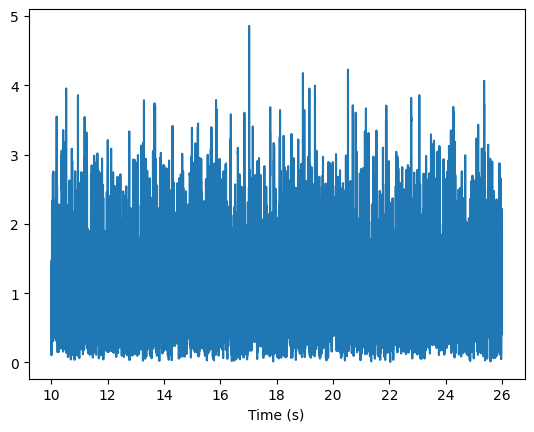

In [243]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [244]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 4.5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [245]:
data = label_L[15]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190514_065416_L_data.npy', structured_array)

In [246]:
data = np.load('GW190514_065416_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -8.070062e-21  noise
1 -3.162905e-21  noise
2 -7.658755e-21  noise
3 -1.051245e-20  noise
4 -6.956414e-21  noise


In [247]:
#GW190517_055101
#H
strain_H_event = TimeSeries(strain_H_data[22], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 39
m2 = 24
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.82421875s with SNR 5.438049905846869


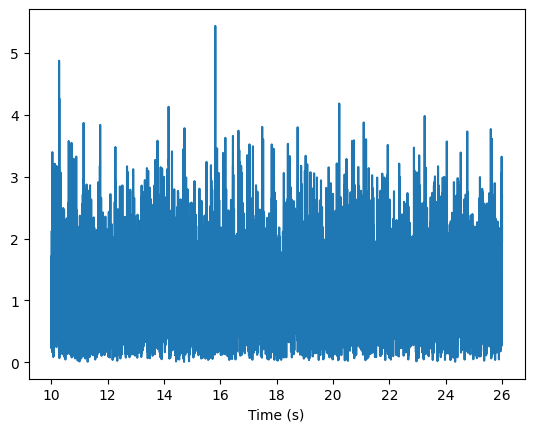

In [248]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [249]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [250]:
data = label_H[15]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190517_055101_H_data.npy', structured_array)

In [251]:
data = np.load('GW190517_055101_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0  2.431933e-19  noise
1  1.068686e-19  noise
2 -1.956579e-19  noise
3 -1.211035e-19  noise
4  2.404120e-19  noise


In [252]:
#GW190517_055101
#L
strain_L_event = TimeSeries(strain_L_data[23], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 39
m2 = 24
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.81982421875s with SNR 6.366755323675924


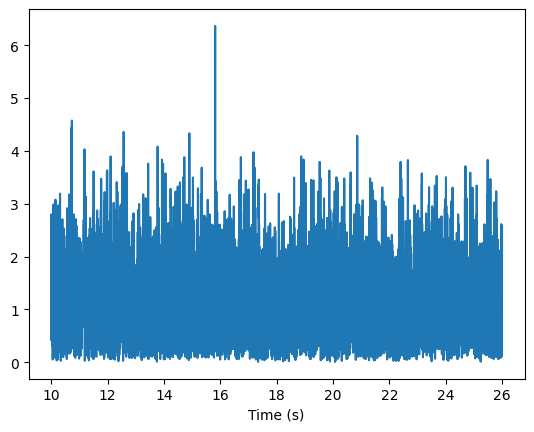

In [253]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [254]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [255]:
data = label_L[16]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190517_055101_L_data.npy', structured_array)

In [256]:
data = np.load('GW190517_055101_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -5.897888e-21  noise
1 -6.768047e-21  noise
2 -8.184578e-21  noise
3 -6.284164e-21  noise
4 -6.160424e-21  noise


In [257]:
#GW190517_055101
#V
strain_V_event = TimeSeries(strain_V_data[12], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 39
m2 = 24
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 15.26953125s with SNR 4.457319073180537


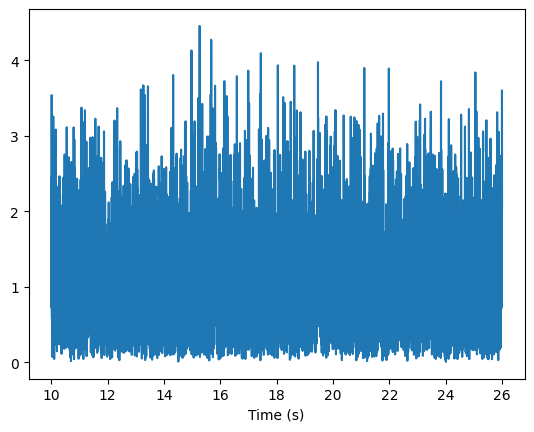

In [258]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [259]:
#GW190519_153544
#H
strain_H_event = TimeSeries(strain_H_data[23], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 65
m2 = 41
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.3837890625s with SNR 7.331425619524766


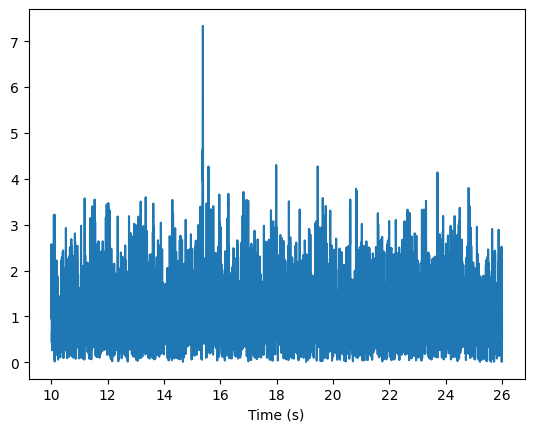

In [260]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [261]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [262]:
data = label_H[16]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190519_153544_H_data.npy', structured_array)

In [263]:
data = np.load('GW190519_153544_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0 -3.016509e-21  noise
1  2.294100e-20  noise
2  2.164039e-21  noise
3  1.834118e-20  noise
4 -4.032406e-22  noise


In [264]:
#GW190519_153544
#L
strain_L_event = TimeSeries(strain_L_data[24], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 65
m2 = 41
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.3857421875s with SNR 9.414948721601087


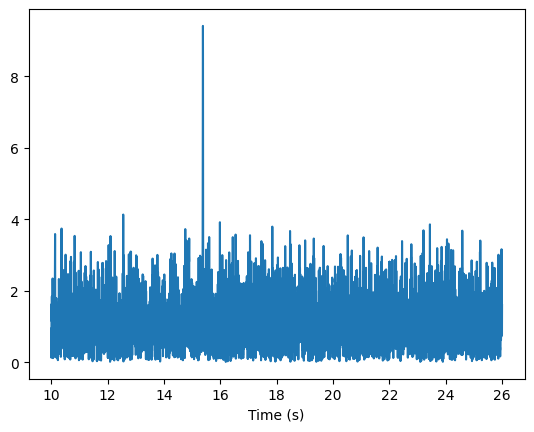

In [265]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [266]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [267]:
data = label_L[17]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190519_153544_L_data.npy', structured_array)

In [268]:
data = np.load('GW190519_153544_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -3.932231e-21  noise
1 -3.604690e-21  noise
2 -3.686779e-21  noise
3 -3.545636e-21  noise
4 -3.782710e-21  noise


In [269]:
#GW190519_153544
#V
strain_V_event = TimeSeries(strain_V_data[13], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 65
m2 = 41
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 10.58740234375s with SNR 4.505503804311795


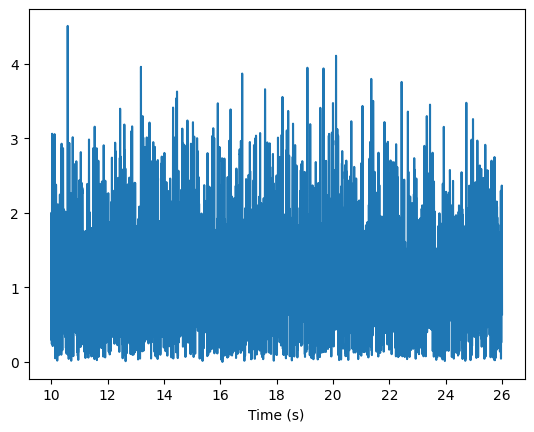

In [270]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [271]:
#GW190521
#H
strain_H_event = TimeSeries(strain_H_data[24], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 98
m2 = 57
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.44921875s with SNR 6.959371310175874


In [272]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [273]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [274]:
data = label_H[17]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190521_H_data.npy', structured_array)

In [275]:
data = np.load('GW190521_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0 -6.271417e-21  noise
1  6.846662e-21  noise
2 -7.419005e-21  noise
3  5.804526e-21  noise
4 -5.439877e-21  noise


In [276]:
#GW190521
#L
strain_L_event = TimeSeries(strain_L_data[25], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 98
m2 = 57
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=10)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.44677734375s with SNR 9.059132178772128


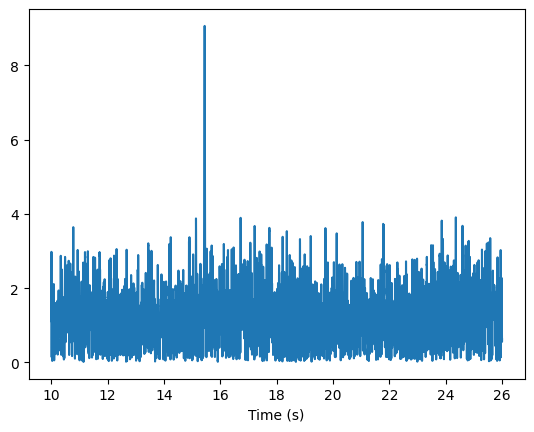

In [277]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [278]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [279]:
data = label_L[18]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190521_L_data.npy', structured_array)

In [280]:
data = np.load('GW190521_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0  3.938474e-22  noise
1  7.568379e-22  noise
2  6.241622e-22  noise
3  2.674904e-22  noise
4  1.289581e-21  noise


In [281]:
#GW190521
#V
strain_V_event = TimeSeries(strain_V_data[14], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 98
m2 = 57
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 12.19921875s with SNR 5.231568290207275


In [282]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [283]:
for value_strain, value_snr in zip(strain_V_event_array, snr_values):
    if value_snr >= 4.5:
        label_V_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_V_values.append((value_strain, "noise"))
label_V.append(label_V_values)

In [284]:
data = label_V[2]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_V', float), ('Label', 'U10')])
np.save('GW190521_V_data.npy', structured_array)

In [285]:
data = np.load('GW190521_V_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_V  Label
0 -1.699455e-22  noise
1 -1.827702e-22  noise
2  4.115498e-21  noise
3  5.095144e-21  noise
4  1.136832e-20  noise


In [286]:
#GW190521_074359
#H
strain_H_event = TimeSeries(strain_H_data[25], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 43
m2 = 33
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.46240234375s with SNR 10.501932957510018


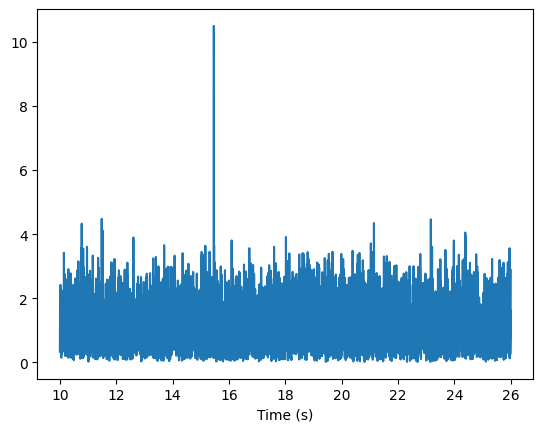

In [287]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [288]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [289]:
data = label_H[18]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190521_074359_H_data.npy', structured_array)

In [290]:
data = np.load('GW190521_074359_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0  1.617185e-22  noise
1  1.565668e-20  noise
2  6.753957e-21  noise
3  1.500565e-20  noise
4  4.010171e-21  noise


In [291]:
#GW190521_074359
#L
strain_L_event = TimeSeries(strain_L_data[26], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 43
m2 = 33
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.4580078125s with SNR 17.586352018949572


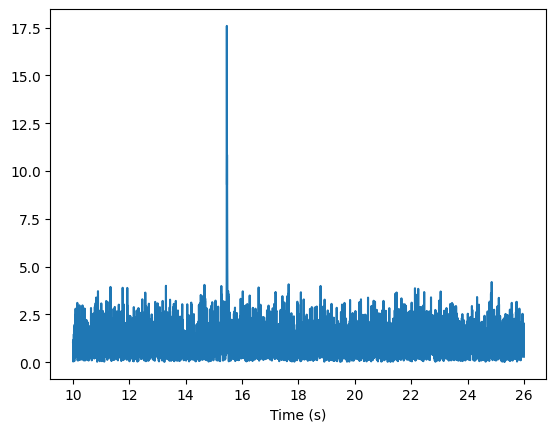

In [292]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [293]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [294]:
data = label_L[19]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190521_074359_L_data.npy', structured_array)

In [295]:
data = np.load('GW190521_074359_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -1.458489e-21  noise
1 -7.368947e-22  noise
2 -6.897321e-22  noise
3 -4.452187e-22  noise
4  3.046236e-22  noise


In [296]:
#GW190527_092055
#H
strain_H_event = TimeSeries(strain_H_data[26], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 36
m2 = 22
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 19.8701171875s with SNR 4.604698334330582


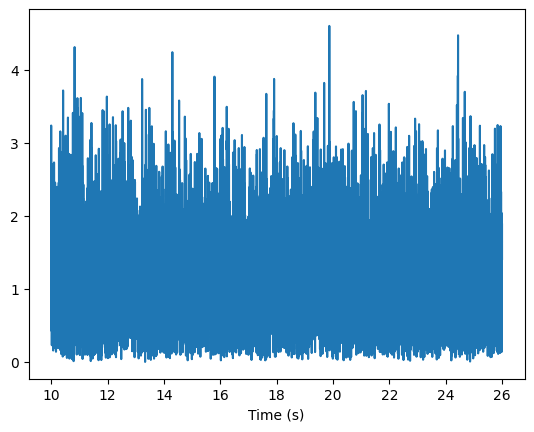

In [297]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Hanford се отфрла.

In [298]:
#GW190527_092055
#L
strain_L_event = TimeSeries(strain_L_data[27], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 36
m2 = 22
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.79541015625s with SNR 5.736774362127068


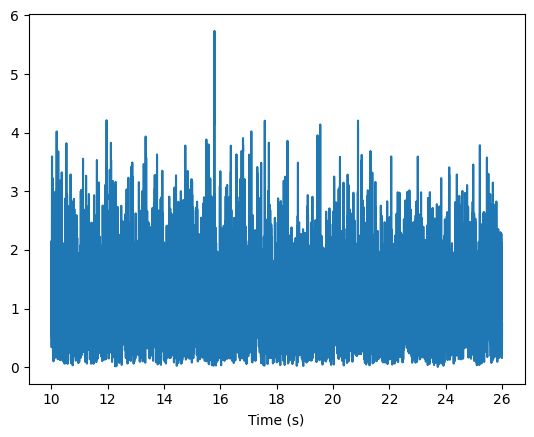

In [299]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [300]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 4.5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [301]:
data = label_L[20]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190527_092055_L_data.npy', structured_array)

In [302]:
data = np.load('GW190527_092055_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -6.937626e-21  noise
1 -5.900921e-21  noise
2 -7.822440e-21  noise
3 -5.107051e-21  noise
4 -6.826086e-21  noise


In [303]:
#GW190602_175927
#H
strain_H_event = TimeSeries(strain_H_data[27], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 72
m2 = 45
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 16.09765625s with SNR 5.574161106031125


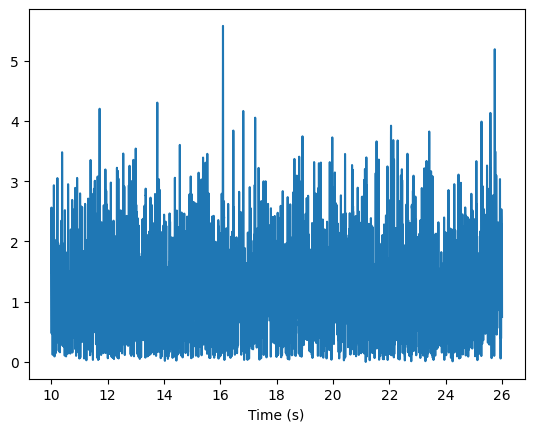

In [304]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Hanford се отфрла.

In [305]:
#GW190602_175927
#L
strain_L_event = TimeSeries(strain_L_data[28], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 72
m2 = 45
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 16.08642578125s with SNR 8.996428952794615


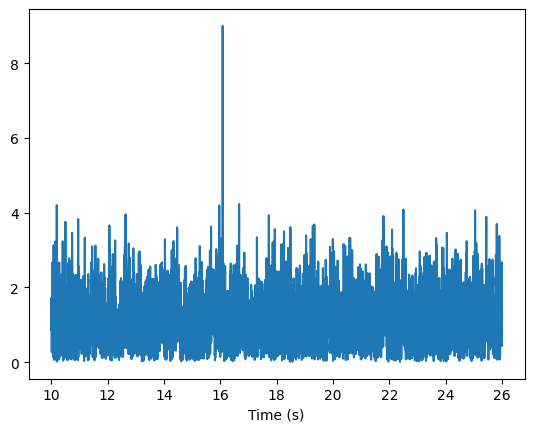

In [306]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [307]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [308]:
data = label_L[21]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190602_175927_L_data.npy', structured_array)

In [309]:
data = np.load('GW190602_175927_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0  1.326764e-20  noise
1 -6.015291e-21  noise
2  1.349084e-20  noise
3 -3.498107e-21  noise
4  1.289650e-20  noise


In [310]:
#GW190602_175927
#V
strain_V_event = TimeSeries(strain_V_data[15], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 72
m2 = 45
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 14.90283203125s with SNR 4.118905529715389


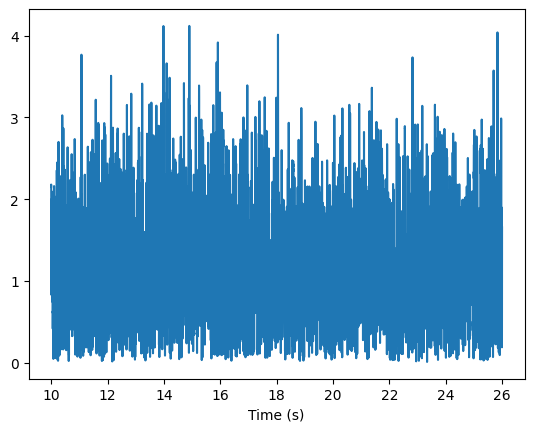

In [311]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [312]:
#GW190620_030421
#L
strain_L_event = TimeSeries(strain_L_data[29], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 58
m2 = 35
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.30615234375s with SNR 9.762859990548371


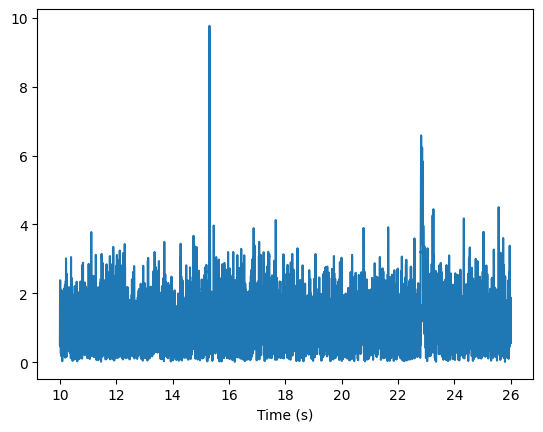

In [313]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [314]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 7:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [315]:
data = label_L[22]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190620_030421_L_data.npy', structured_array)

In [316]:
data = np.load('GW190620_030421_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -1.309442e-20  noise
1 -1.413229e-20  noise
2 -1.300066e-20  noise
3 -1.264901e-20  noise
4 -1.205225e-20  noise


In [317]:
#GW190620_030421
#V
strain_V_event = TimeSeries(strain_V_data[16], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 58
m2 = 35
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 13.93017578125s with SNR 4.279475997573694


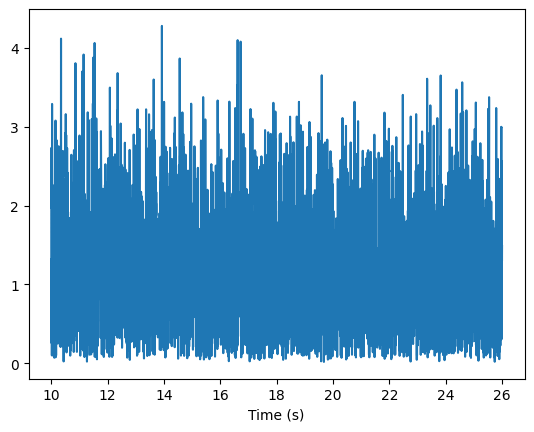

In [318]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [319]:
#GW190630_185205
#L
strain_L_event = TimeSeries(strain_L_data[30], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 35
m2 = 24
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.1767578125s with SNR 10.637654100314242


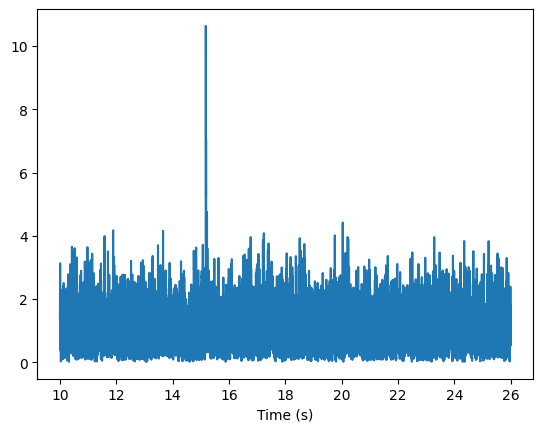

In [320]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [321]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [322]:
data = label_L[23]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190630_185205_L_data.npy', structured_array)

In [323]:
data = np.load('GW190630_185205_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -1.700766e-21  noise
1 -2.220383e-21  noise
2 -1.963367e-21  noise
3 -8.538168e-22  noise
4 -1.009729e-21  noise


In [324]:
#GW190630_185205
#V
strain_V_event = TimeSeries(strain_V_data[17], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 35
m2 = 24
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 16.27099609375s with SNR 4.181040840167666


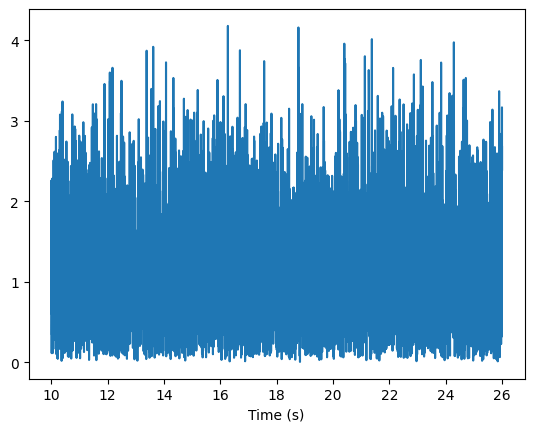

In [325]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [326]:
#GW190701_203306
#H
strain_H_event = TimeSeries(strain_H_data[28], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 54
m2 = 41
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.56884765625s with SNR 4.835025473715209


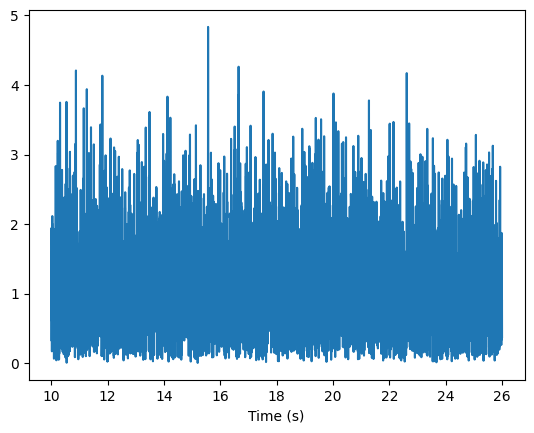

In [327]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [328]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 4.5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [329]:
data = label_H[19]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190701_203306_H_data.npy', structured_array)

In [330]:
data = np.load('GW190701_203306_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0  4.170636e-21  noise
1 -6.471901e-21  noise
2  4.229133e-21  noise
3 -5.469984e-21  noise
4  5.058062e-21  noise


In [331]:
#GW190701_203306
#L
strain_L_event = TimeSeries(strain_L_data[31], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 54
m2 = 41
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.57470703125s with SNR 6.459200502928246


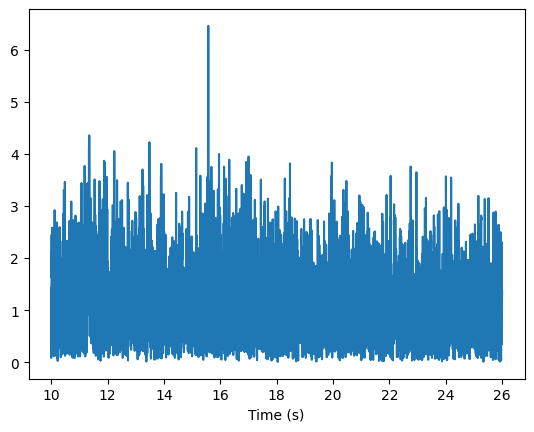

In [332]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [333]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [334]:
data = label_L[24]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190701_203306_L_data.npy', structured_array)

In [335]:
data = np.load('GW190701_203306_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -3.346881e-21  noise
1 -1.649226e-21  noise
2 -8.965518e-22  noise
3 -1.196569e-21  noise
4 -3.138548e-21  noise


In [336]:
#GW190701_203306
#V
strain_V_event = TimeSeries(strain_V_data[18], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 54
m2 = 41
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 21.31396484375s with SNR 4.769679525107235


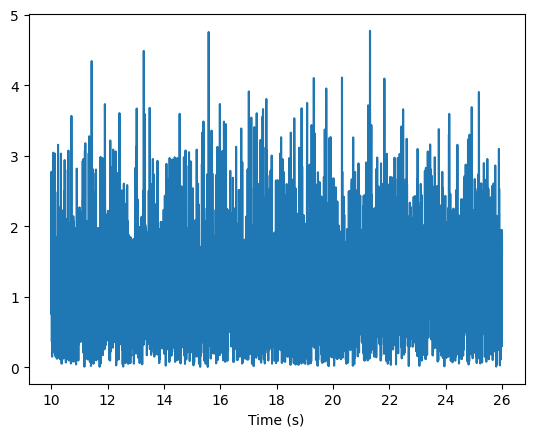

In [337]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [338]:
#GW190706_222641
#H
strain_H_event = TimeSeries(strain_H_data[29], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 74
m2 = 40
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.3251953125s with SNR 8.325400033808299


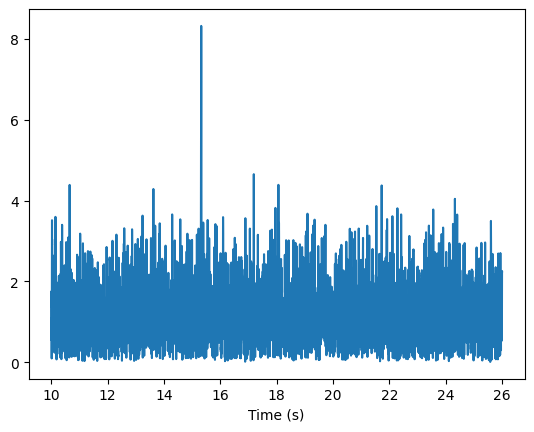

In [339]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [340]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [341]:
data = label_H[20]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190706_222641_H_data.npy', structured_array)

In [342]:
data = np.load('GW190706_222641_H_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_H  Label
0  1.428621e-20  noise
1  1.088187e-20  noise
2  1.399724e-20  noise
3  4.378795e-21  noise
4  1.418384e-20  noise


In [343]:
#GW190706_222641
#L
strain_L_event = TimeSeries(strain_L_data[32], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 74
m2 = 40
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.32373046875s with SNR 8.292644485566862


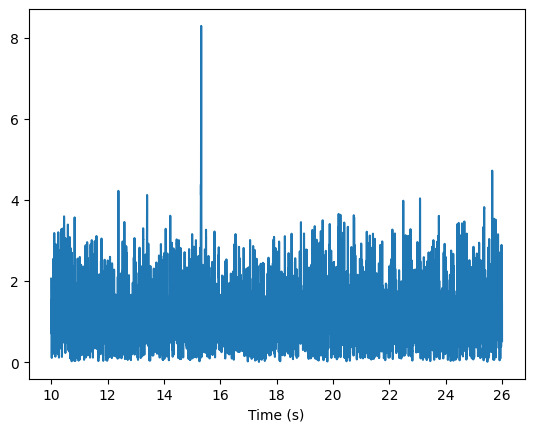

In [344]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [345]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [346]:
data = label_L[25]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190706_222641_L_data.npy', structured_array)

In [347]:
data = np.load('GW190706_222641_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0  7.757912e-21  noise
1 -2.688136e-20  noise
2 -2.754845e-21  noise
3 -3.358522e-20  noise
4  7.035983e-21  noise


In [348]:
#GW190706_222641
#V
strain_V_event = TimeSeries(strain_V_data[19], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 74
m2 = 40
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 16.7685546875s with SNR 4.3157762553395385


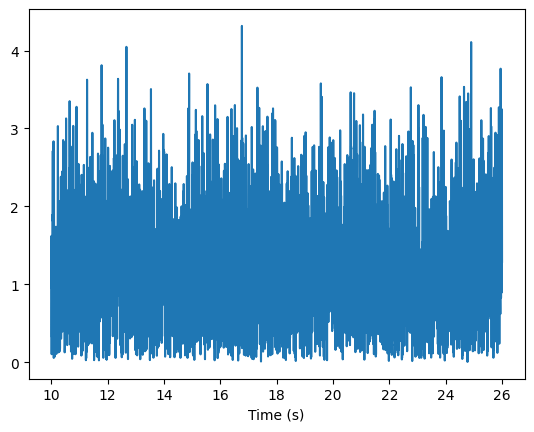

In [349]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [350]:
#GW190707_093326
#H
strain_H_event = TimeSeries(strain_H_data[30], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 12
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=30)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 12.580078125s with SNR 4.659785205894203


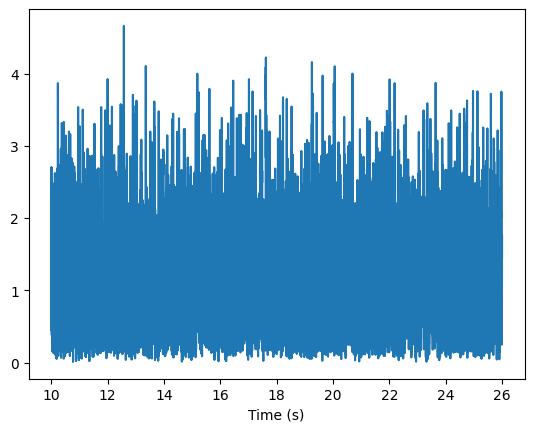

In [351]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Hanford се отфрла.

In [352]:
#GW190707_093326
#L
strain_L_event = TimeSeries(strain_L_data[33], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 12
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=30)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.19873046875s with SNR 4.504403294312994


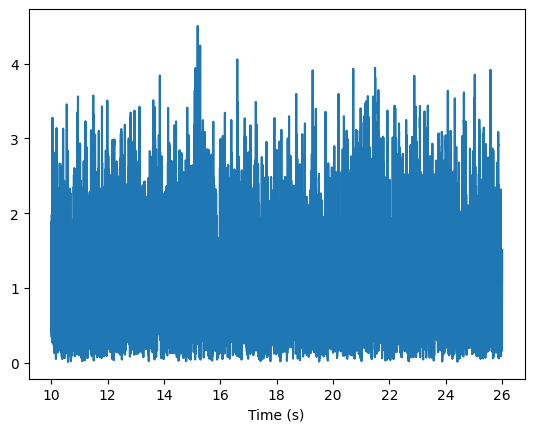

In [353]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла сигналот и од Livingston, со што се отфрла целиот настан.

In [354]:
#GW190708_232457
#L
strain_L_event = TimeSeries(strain_L_data[34], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 20
m2 = 12
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.3828125s with SNR 5.46848886168029


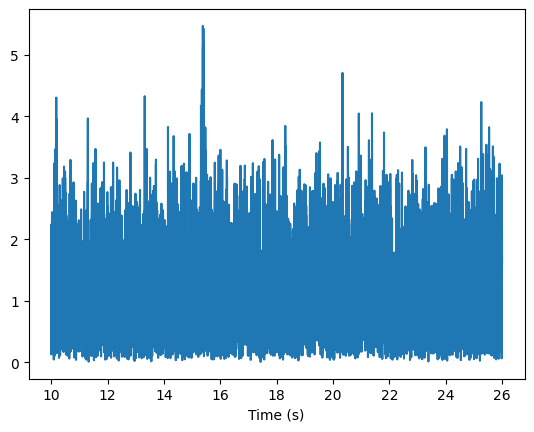

In [355]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [356]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [357]:
for outer_index, label_data in enumerate(label_L):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if outer_index==26 and label == "noise+BBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 26 Inner Index: 11023 Value: -3.149413466551295e-21 Label: noise+BBH
Outer Index: 26 Inner Index: 11024 Value: 4.851583616419411e-21 Label: noise+BBH
Outer Index: 26 Inner Index: 11025 Value: -1.2852876686122893e-20 Label: noise+BBH
Outer Index: 26 Inner Index: 11033 Value: -1.0032934752331185e-20 Label: noise+BBH
Outer Index: 26 Inner Index: 11050 Value: 1.1373560609420099e-20 Label: noise+BBH
Outer Index: 26 Inner Index: 11051 Value: 6.676852675011932e-21 Label: noise+BBH
Outer Index: 26 Inner Index: 11064 Value: 1.6414766554738972e-20 Label: noise+BBH
Outer Index: 26 Inner Index: 11065 Value: -1.361339012736148e-21 Label: noise+BBH
Outer Index: 26 Inner Index: 11066 Value: 1.294484389015012e-20 Label: noise+BBH


In [358]:
data = label_L[26]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190708_232457_L_data.npy', structured_array)

In [359]:
data = np.load('GW190708_232457_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -1.952283e-20  noise
1  1.410685e-20  noise
2 -1.311488e-20  noise
3  5.424908e-21  noise
4 -1.946401e-20  noise


In [360]:
#GW190708_232457
#V
strain_V_event = TimeSeries(strain_V_data[20], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 20
m2 = 12
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 20.869140625s with SNR 4.170810087687383


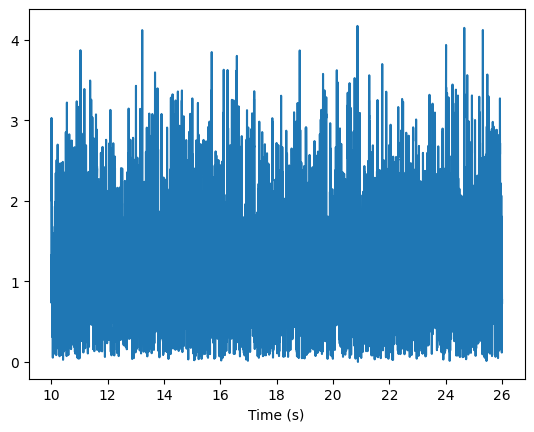

In [361]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [362]:
#GW190719_215514
#H
strain_H_event = TimeSeries(strain_H_data[31], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 37
m2 = 20
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 19.55419921875s with SNR 4.754388771294056


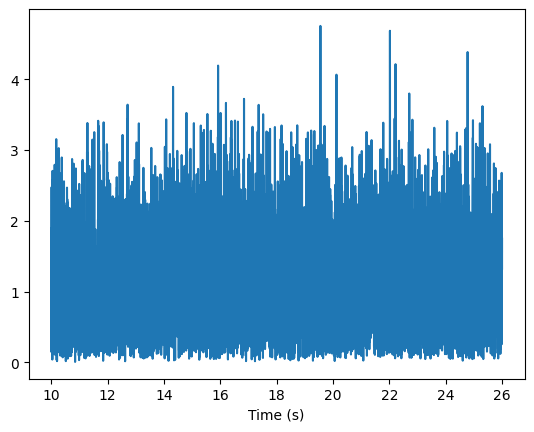

In [363]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Hanford се отфрла.

In [364]:
#GW190719_215514
#L
strain_L_event = TimeSeries(strain_L_data[35], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 37
m2 = 20
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.92431640625s with SNR 5.014690484392782


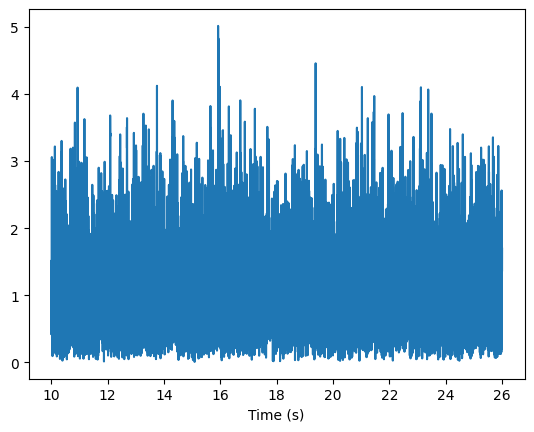

In [365]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [366]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 4.5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [367]:
data = label_L[27]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190719_215514_L_data.npy', structured_array)

In [368]:
data = np.load('GW190719_215514_L_data.npy', allow_pickle=True)
df = pd.DataFrame(data)
print(df.head())

       Strain_L  Label
0 -1.101237e-21  noise
1 -2.021555e-21  noise
2 -5.887449e-21  noise
3  8.949300e-23  noise
4  2.819782e-22  noise


In [369]:
#GW190720_000836
#H
strain_H_event = TimeSeries(strain_H_data[32], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 14
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 14.13525390625s with SNR 4.437323116726542


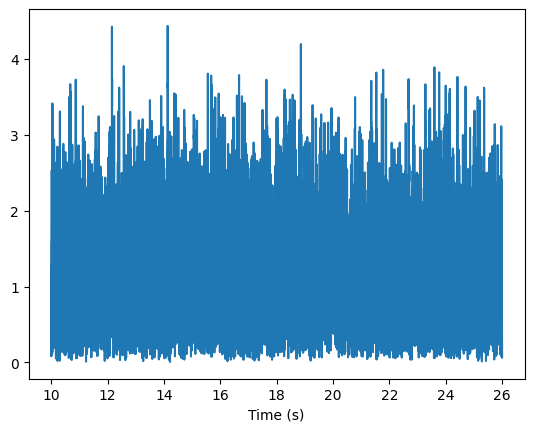

In [370]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла сигналот од Hanford.

In [371]:
#GW190720_000836
#L
strain_L_event = TimeSeries(strain_L_data[36], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 14
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 10.85546875s with SNR 4.748037610987426


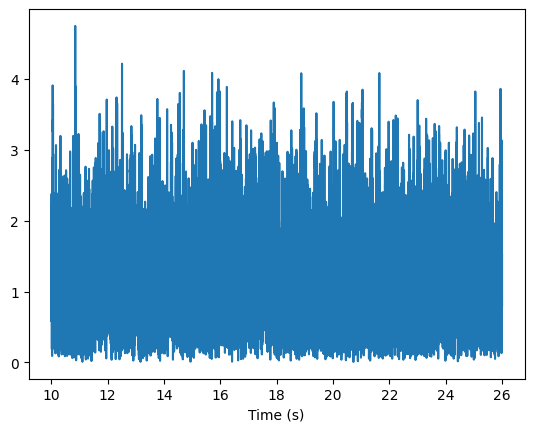

In [372]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [373]:
#GW190720_000836
#V
strain_V_event = TimeSeries(strain_V_data[21], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 14
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 17.767578125s with SNR 4.06844756853587


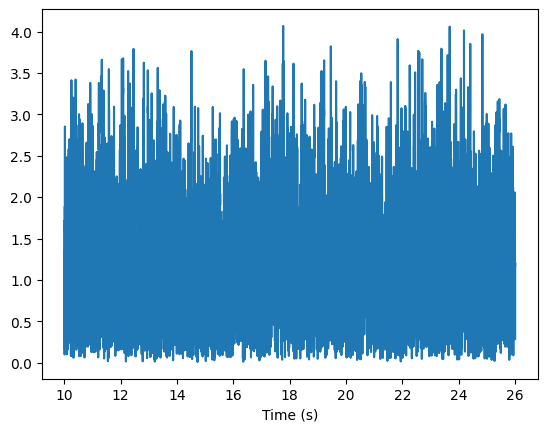

In [374]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Целосно се отфрла настанот.

In [375]:
#GW190725_174728
#H
strain_H_event = TimeSeries(strain_H_data[33], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 12
m2 = 6
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 23.7626953125s with SNR 4.871784068158166


In [376]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [377]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 4.5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [378]:
data = label_H[21]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190725_174728_H_data.npy', structured_array)

In [379]:
#GW190725_174728
#L
strain_L_event = TimeSeries(strain_L_data[37], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 12
m2 = 6
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 22.5478515625s with SNR 4.710960662156718


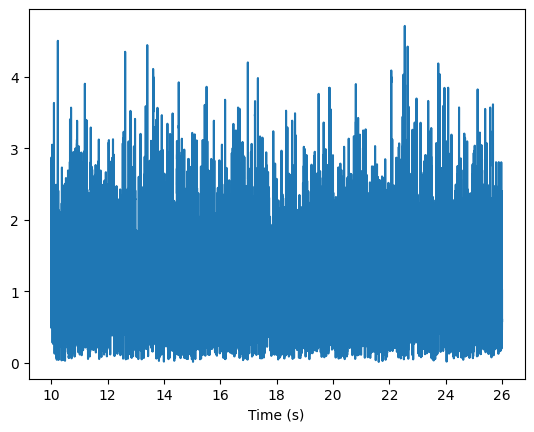

In [380]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Livingston се отфрла.

In [381]:
#GW190725_174728
#V
strain_V_event = TimeSeries(strain_V_data[22], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 12
m2 = 6
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 14.1279296875s with SNR 4.939543052662378


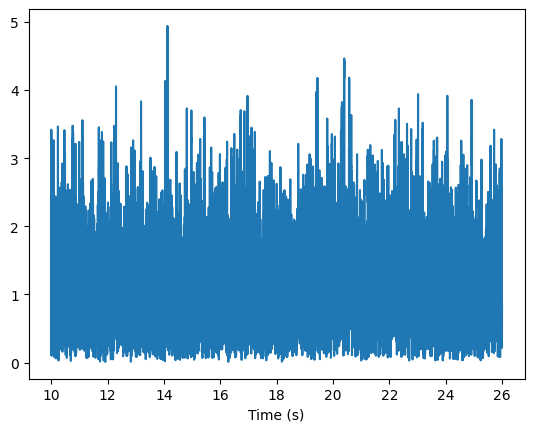

In [382]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се oтфлра од Virgo.

In [383]:
#GW190727_060333
#H
strain_H_event = TimeSeries(strain_H_data[34], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 39
m2 = 30
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.98583984375s with SNR 7.54880383258982


In [384]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [385]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [386]:
data = label_H[22]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190727_060333_H_data.npy', structured_array)

In [387]:
#GW190727_060333
#L
strain_L_event = TimeSeries(strain_L_data[38], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 39
m2 = 30
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.9794921875s with SNR 4.841500606496393


In [388]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла од Livingston.

In [389]:
#GW190727_060333
#V
strain_V_event = TimeSeries(strain_V_data[23], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 39
m2 = 30
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 23.94775390625s with SNR 4.748686998545804


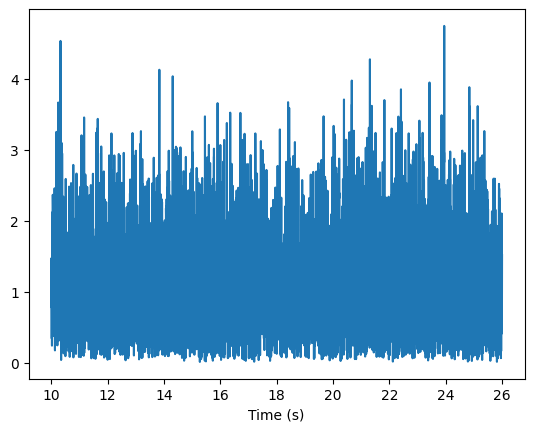

In [390]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла од Virgo.

In [391]:
#GW190728_064510
#H
strain_H_event = TimeSeries(strain_H_data[35], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 13
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 11.63720703125s with SNR 5.017666035792875


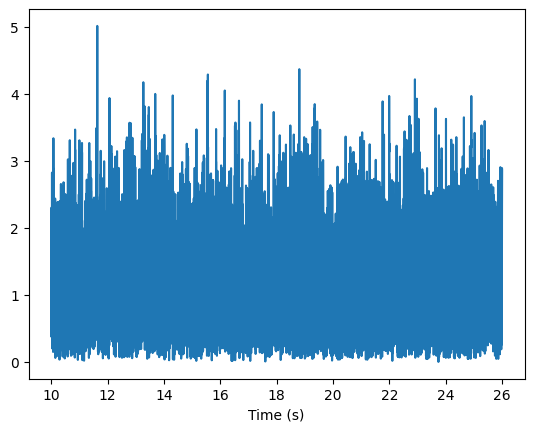

In [392]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла од Hanford.

In [393]:
#GW190728_064510
#L
strain_L_event = TimeSeries(strain_L_data[39], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 13
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.55712890625s with SNR 4.480526397194965


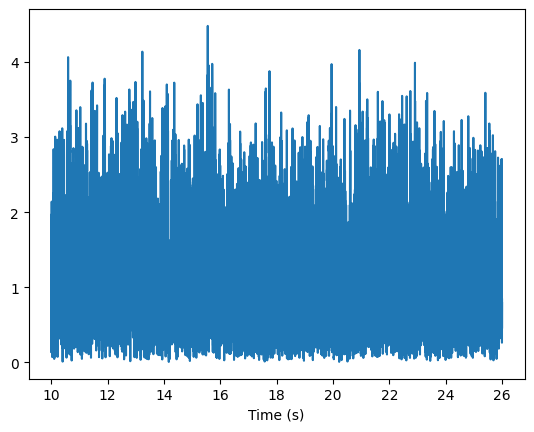

In [394]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [395]:
#GW190728_064510
#V
strain_V_event = TimeSeries(strain_V_data[24], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 13
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 19.23046875s with SNR 4.109838573746282


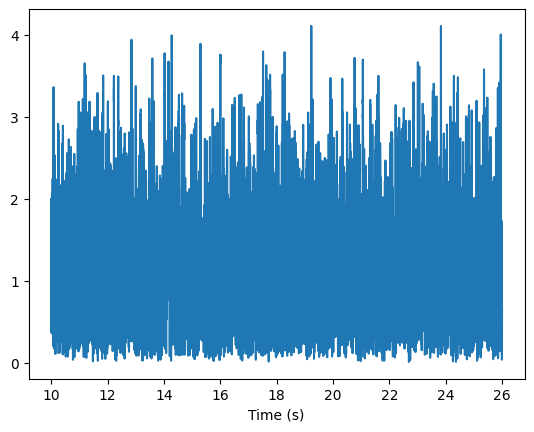

In [396]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла целосно настанот.

In [397]:
#GW190731_140936
#H
strain_H_event = TimeSeries(strain_H_data[36], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 42
m2 = 29
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 23.2177734375s with SNR 4.636572667812704


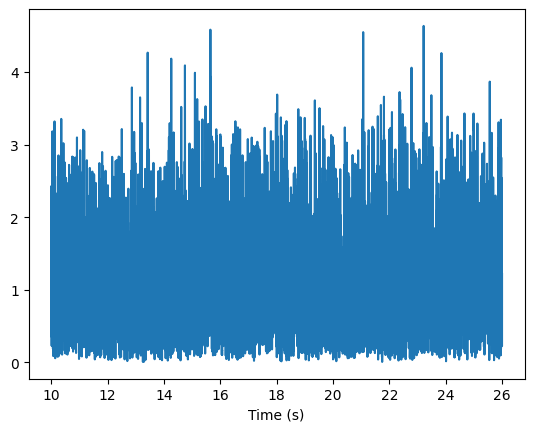

In [398]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Hanford се отфрла.

In [399]:
#GW190731_140936
#L
strain_L_event = TimeSeries(strain_L_data[40], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 42
m2 = 29
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.63232421875s with SNR 5.403484366553194


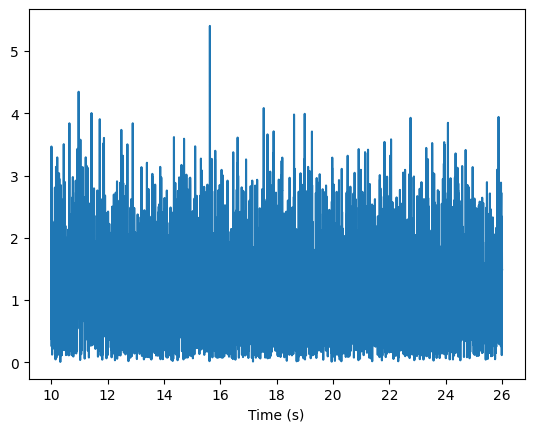

In [400]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [401]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 4.5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [404]:
data = label_L[28]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190731_140936_L_data.npy', structured_array)

In [405]:
#GW190803_022701
#H
strain_H_event = TimeSeries(strain_H_data[37], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 38
m2 = 28
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 14.9921875s with SNR 4.326431890489628


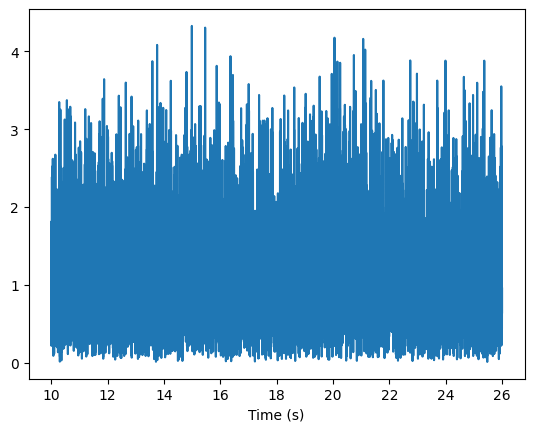

In [406]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла сигналот од Hanford.

In [407]:
#GW190803_022701
#L
strain_L_event = TimeSeries(strain_L_data[41], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 38
m2 = 28
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 18.1640625s with SNR 5.654680033846734


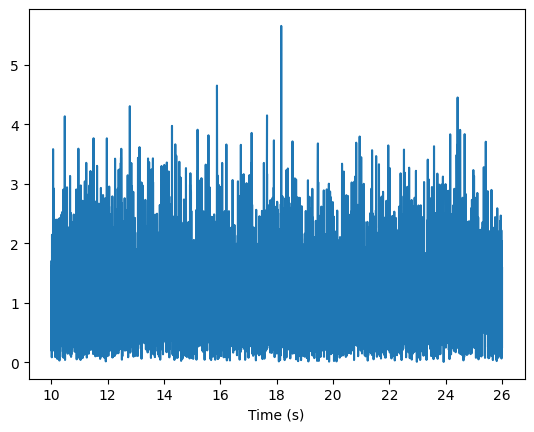

In [408]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [409]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [411]:
data = label_L[29]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190803_022701_L_data.npy', structured_array)

In [412]:
#GW190803_022701
#V
strain_V_event = TimeSeries(strain_V_data[25], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 38
m2 = 28
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 22.58154296875s with SNR 4.44091806646614


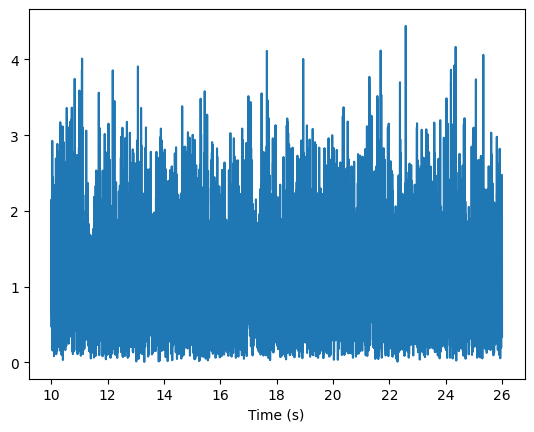

In [413]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла сингалот од Virgo.

In [414]:
#GW190805_211137
#H
strain_H_event = TimeSeries(strain_H_data[38], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 46
m2 = 31
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 25.41552734375s with SNR 4.534727958787079


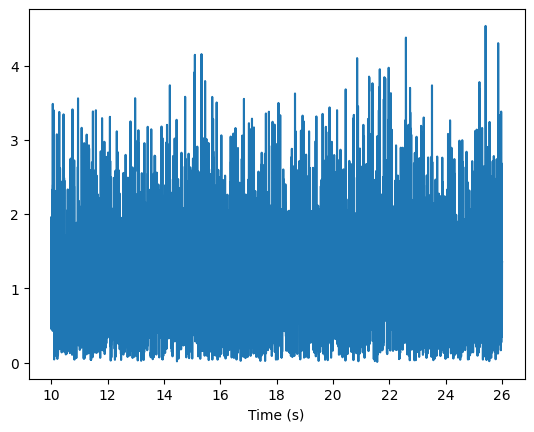

In [415]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Hanford се отфрла.

In [416]:
#GW190805_211137
#L
strain_L_event = TimeSeries(strain_L_data[42], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 46
m2 = 31
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.33935546875s with SNR 4.861163610927711


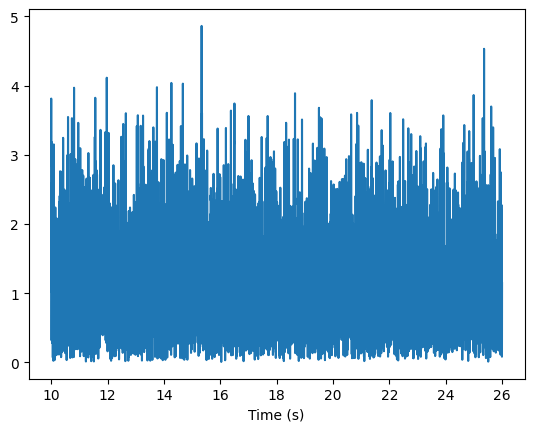

In [417]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [418]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 4.5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [420]:
for outer_index, label_data in enumerate(label_L):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if outer_index==30 and label == "noise+BBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 30 Inner Index: 10932 Value: 2.1750662450302037e-20 Label: noise+BBH
Outer Index: 30 Inner Index: 10933 Value: -1.966968464906012e-21 Label: noise+BBH
Outer Index: 30 Inner Index: 10934 Value: -1.0632140742532243e-20 Label: noise+BBH
Outer Index: 30 Inner Index: 10935 Value: 1.7549406258890068e-20 Label: noise+BBH
Outer Index: 30 Inner Index: 10936 Value: 2.2749375962439134e-20 Label: noise+BBH
Outer Index: 30 Inner Index: 10937 Value: -1.3334932340813895e-21 Label: noise+BBH
Outer Index: 30 Inner Index: 10938 Value: -1.0613420514395723e-20 Label: noise+BBH
Outer Index: 30 Inner Index: 10939 Value: 1.6911238306609578e-20 Label: noise+BBH
Outer Index: 30 Inner Index: 31460 Value: 2.8642770203411176e-20 Label: noise+BBH


In [421]:
data = label_L[30]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190805_211137_L_data.npy', structured_array)

In [441]:
#GW190814
#H
strain_H_event = TimeSeries(strain_H_data[39], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 23
m2 = 2.6
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 10.005859375s with SNR 9.79010507261762


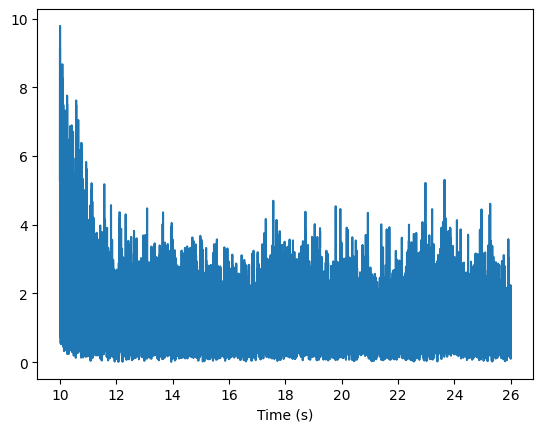

In [442]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [443]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 6:
        label_H_values.append((value_strain, "noise+NSBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [444]:
for outer_index, label_data in enumerate(label_H):
    for inner_index, (value_strain, label) in enumerate(label_data):
        if label == "noise+NSBH":
            print("Outer Index:", outer_index, "Inner Index:", inner_index, "Value:", value_strain, "Label:", label)

Outer Index: 23 Inner Index: 1 Value: -6.7113021494842985e-21 Label: noise+NSBH
Outer Index: 23 Inner Index: 3 Value: -1.0070847971197179e-20 Label: noise+NSBH
Outer Index: 23 Inner Index: 4 Value: -6.061338190139187e-22 Label: noise+NSBH
Outer Index: 23 Inner Index: 5 Value: -8.686147985270607e-21 Label: noise+NSBH
Outer Index: 23 Inner Index: 6 Value: 2.1202682840627892e-21 Label: noise+NSBH
Outer Index: 23 Inner Index: 8 Value: -5.367105712508742e-21 Label: noise+NSBH
Outer Index: 23 Inner Index: 10 Value: -1.8989132014129155e-21 Label: noise+NSBH
Outer Index: 23 Inner Index: 12 Value: -8.866300239444874e-21 Label: noise+NSBH
Outer Index: 23 Inner Index: 14 Value: -5.6321028324121146e-21 Label: noise+NSBH
Outer Index: 23 Inner Index: 19 Value: -1.0253326763398203e-20 Label: noise+NSBH
Outer Index: 23 Inner Index: 75 Value: 4.737147661731659e-21 Label: noise+NSBH
Outer Index: 23 Inner Index: 79 Value: 4.15876928129566e-21 Label: noise+NSBH
Outer Index: 23 Inner Index: 83 Value: 3.218

In [445]:
data = label_H[23]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190814_H_data.npy', structured_array)

In [449]:
#GW190814
#L
strain_L_event = TimeSeries(strain_L_data[43], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 23
m2 = 2.6
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 23.72705078125s with SNR 5.49044641751577


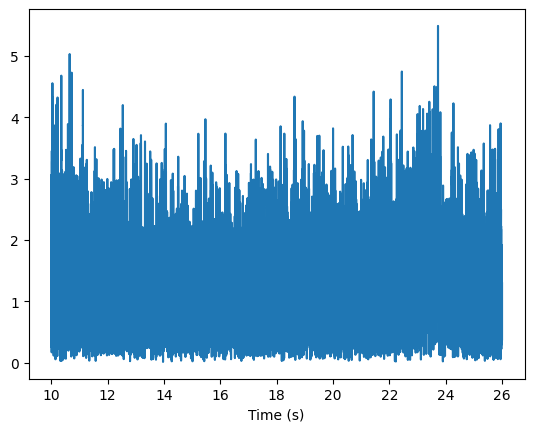

In [450]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Livinston е слаб, се отфрла.

In [453]:
#GW190814
#V
strain_V_event = TimeSeries(strain_V_data[26], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 23
m2 = 2.6
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 10.16064453125s with SNR 6.172979465491533


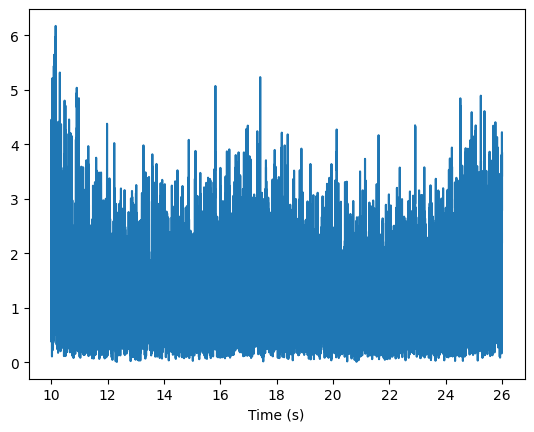

In [454]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла и сигналот од Virgo.

In [460]:
#GW190828_063405
#H
strain_H_event = TimeSeries(strain_H_data[40], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 32
m2 = 26
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.75537109375s with SNR 8.239292990136953


In [461]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [462]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [464]:
data = label_H[24]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190828_063405_H_data.npy', structured_array)

In [465]:
#GW190828_063405
#L
strain_L_event = TimeSeries(strain_L_data[44], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 32
m2 = 26
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.75439453125s with SNR 7.27849024939552


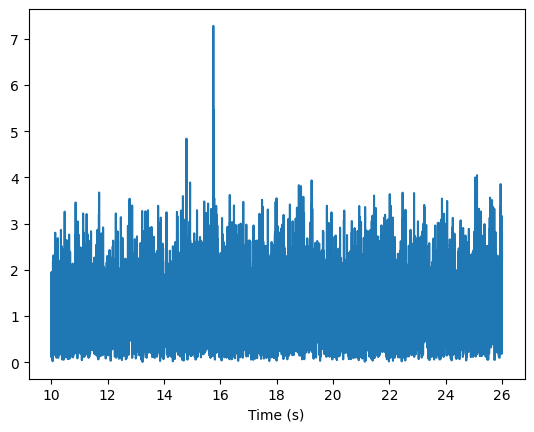

In [466]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [467]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [469]:
data = label_L[31]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190828_063405_L_data.npy', structured_array)

In [470]:
#GW190828_063405
#V
strain_V_event = TimeSeries(strain_V_data[27], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 32
m2 = 26
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 21.37353515625s with SNR 4.179444068885164


In [471]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [474]:
#GW190828_065509
#H
strain_H_event = TimeSeries(strain_H_data[41], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 24
m2 = 10
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 13.337890625s with SNR 4.704677251188261


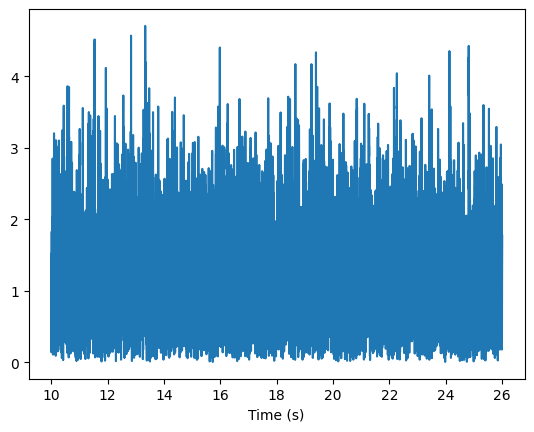

In [475]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Hanford е слаб, се отфрла.

In [476]:
#GW190828_065509
#L
strain_L_event = TimeSeries(strain_L_data[45], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 24
m2 = 10
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 13.42724609375s with SNR 5.340076128190797


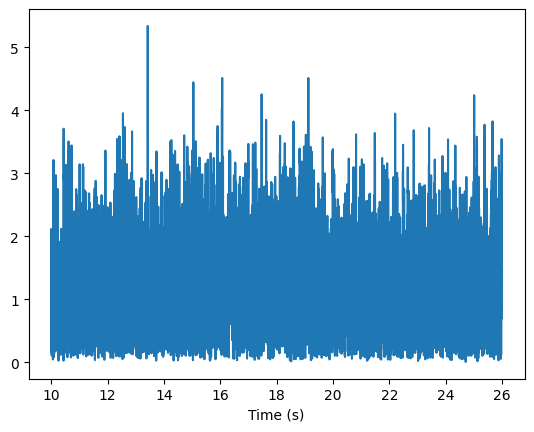

In [477]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [482]:
#GW190828_065509
#V
strain_V_event = TimeSeries(strain_V_data[28], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 24
m2 = 10
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 18.943359375s with SNR 4.852902056746536


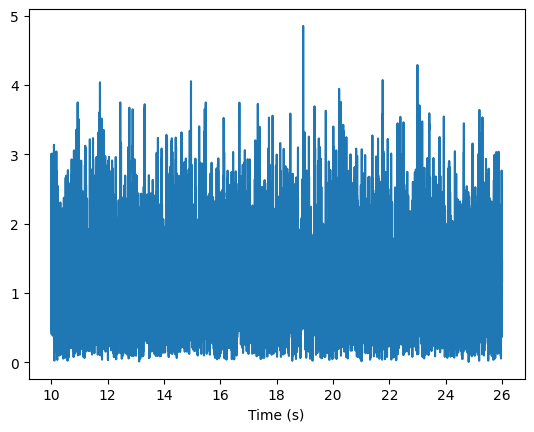

In [483]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла целиот настан.

In [484]:
#GW190910_112807
#L
strain_L_event = TimeSeries(strain_L_data[46], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 44
m2 = 34
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.3203125s with SNR 9.751945158001535


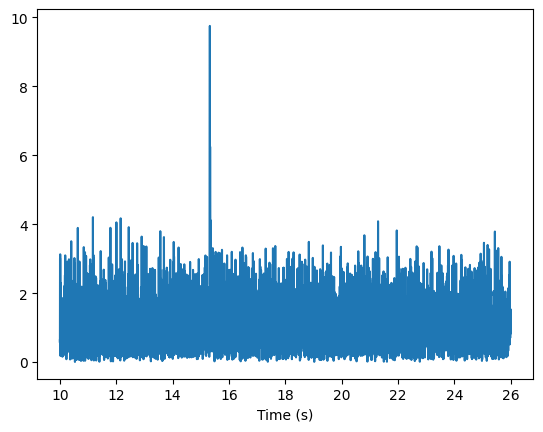

In [485]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [486]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [488]:
data = label_L[32]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190910_112807_L_data.npy', structured_array)

In [489]:
#GW190910_112807
#V
strain_V_event = TimeSeries(strain_V_data[29], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 44
m2 = 34
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 15.12548828125s with SNR 5.078462257291186


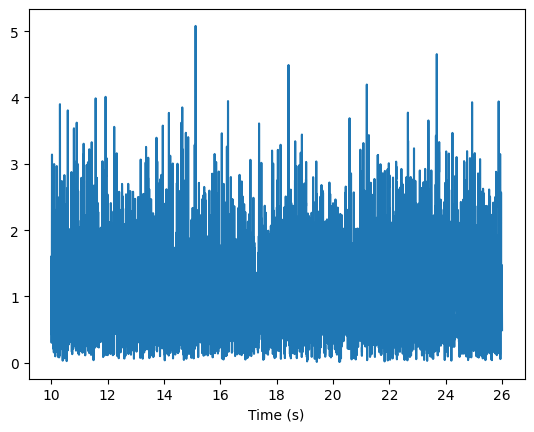

In [490]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [491]:
#GW190915_235702
#H
strain_H_event = TimeSeries(strain_H_data[42], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 33
m2 = 25
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.6884765625s with SNR 7.4541537876823885


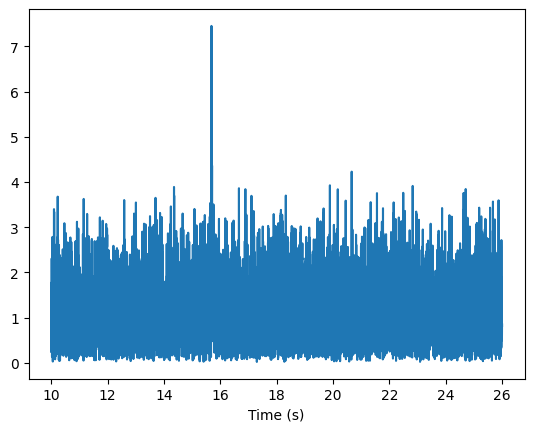

In [492]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [493]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [495]:
data = label_H[25]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190915_235702_H_data.npy', structured_array)

In [496]:
#GW190915_235702
#L
strain_L_event = TimeSeries(strain_L_data[47], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 33
m2 = 25
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.6953125s with SNR 5.901346785008576


In [497]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [498]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [500]:
data = label_L[33]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190915_235702_L_data.npy', structured_array)

In [501]:
#GW190915_235702
#V
strain_V_event = TimeSeries(strain_V_data[30], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 33
m2 = 25
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 14.4521484375s with SNR 4.3017440518484396


In [502]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Сигналот од Virgo се отфрла.

In [503]:
#GW190916_200658
#H
strain_H_event = TimeSeries(strain_H_data[43], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 44
m2 = 23
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 17.78125s with SNR 4.080786479023831


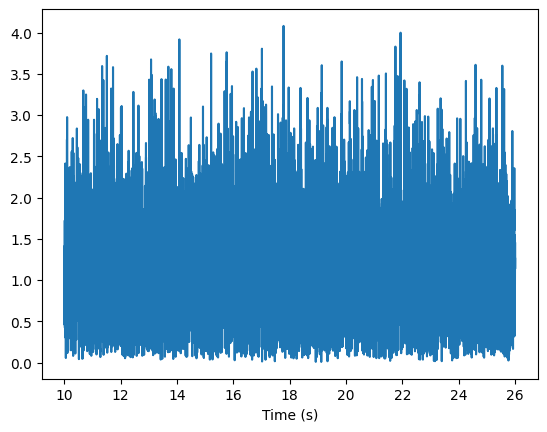

In [504]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [505]:
#GW190916_200658
#L
strain_L_event = TimeSeries(strain_L_data[48], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 44
m2 = 23
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.90380859375s with SNR 5.868465914971319


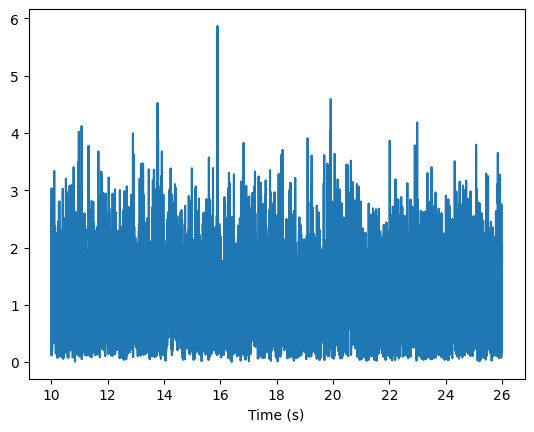

In [506]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [507]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [509]:
data = label_L[34]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190916_200658_L_data.npy', structured_array)

In [510]:
#GW190916_200658
#V
strain_V_event = TimeSeries(strain_V_data[31], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 44
m2 = 23
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 23.087890625s with SNR 4.814230025223514


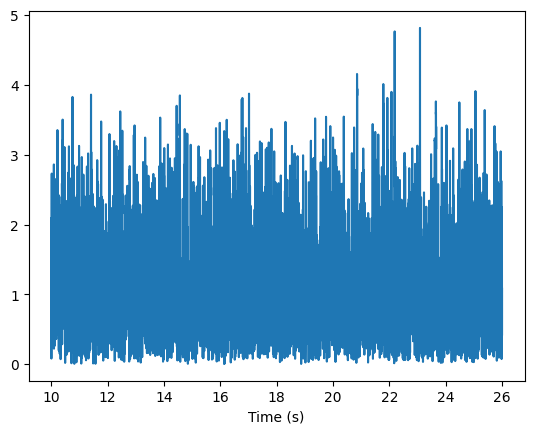

In [511]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [514]:
#GW190917_114630
#H
strain_H_event = TimeSeries(strain_H_data[44], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 10
m2 = 2.1
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 10.06982421875s with SNR 12.983933009851286


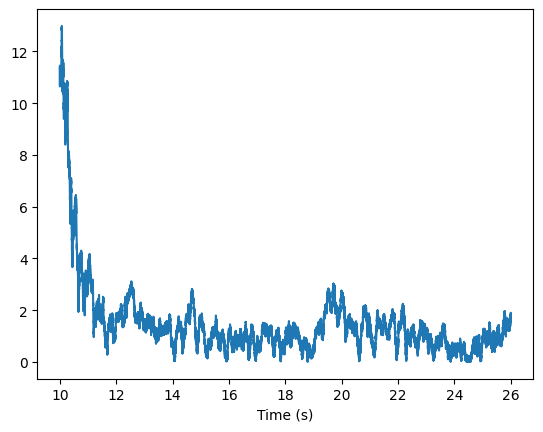

In [515]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [516]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 6:
        label_H_values.append((value_strain, "noise+NSBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [518]:
data = label_H[26]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190917_114630_H_data.npy', structured_array)

In [521]:
#GW190917_114630
#L
strain_L_event = TimeSeries(strain_L_data[49], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 10
m2 = 2.1
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 10.00048828125s with SNR 5.793046097485748


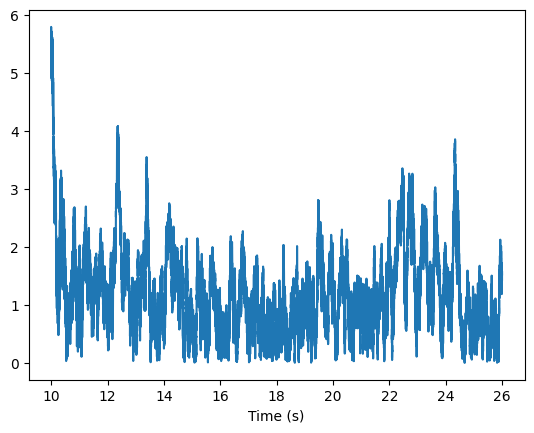

In [522]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [523]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 4.5:
        label_L_values.append((value_strain, "noise+NSBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [525]:
data = label_L[35]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190917_114630_L_data.npy', structured_array)

In [526]:
#GW190917_114630
#V
strain_V_event = TimeSeries(strain_V_data[32], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 10
m2 = 2.1
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 16.57763671875s with SNR 3.9066111124899208


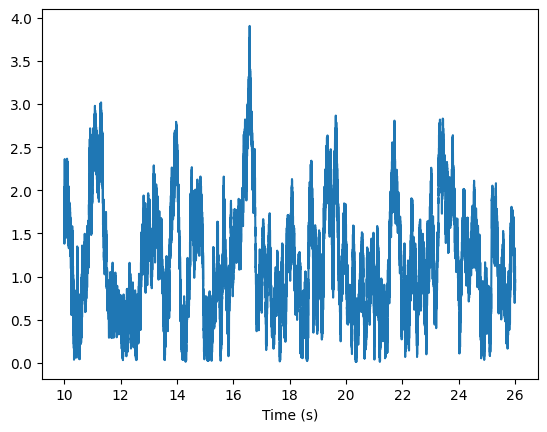

In [527]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [528]:
for value_strain, value_snr in zip(strain_V_event_array, snr_values):
    if value_snr >= 3.5:
        label_V_values.append((value_strain, "noise+NSBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_V_values.append((value_strain, "noise"))
label_V.append(label_V_values)

In [530]:
data = label_V[3]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_V', float), ('Label', 'U10')])
np.save('GW190917_114630_V_data.npy', structured_array)

In [533]:
#GW190924_021846
#H
strain_H_event = TimeSeries(strain_H_data[45], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 9
m2 = 5
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 12.49267578125s with SNR 4.267623997644817


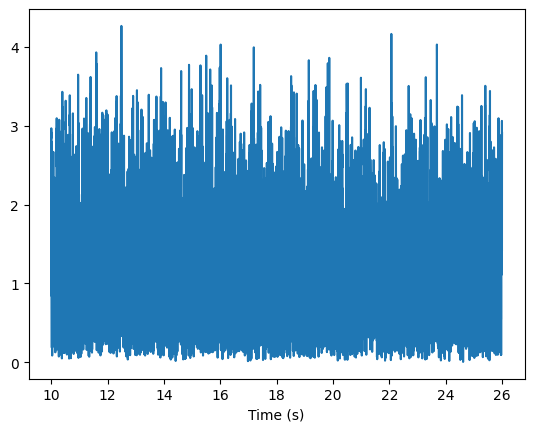

In [534]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [535]:
#GW190924_021846
#L
strain_L_event = TimeSeries(strain_L_data[50], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 9
m2 = 5
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 12.80419921875s with SNR 5.922599697808607


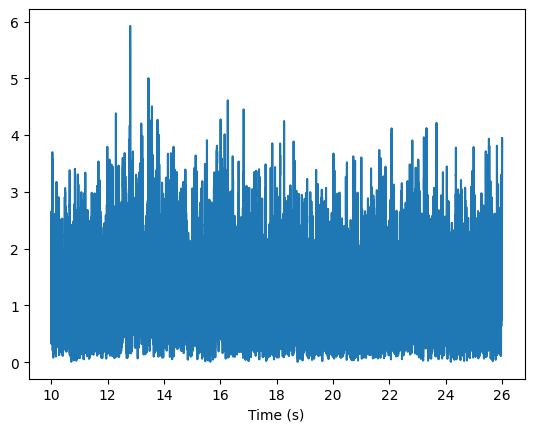

In [536]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [537]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [539]:
data = label_L[36]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW190924_021846_L_data.npy', structured_array)

In [540]:
#GW190924_021846
#V
strain_V_event = TimeSeries(strain_V_data[33], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 9
m2 = 5
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 21.14501953125s with SNR 4.936854424112587


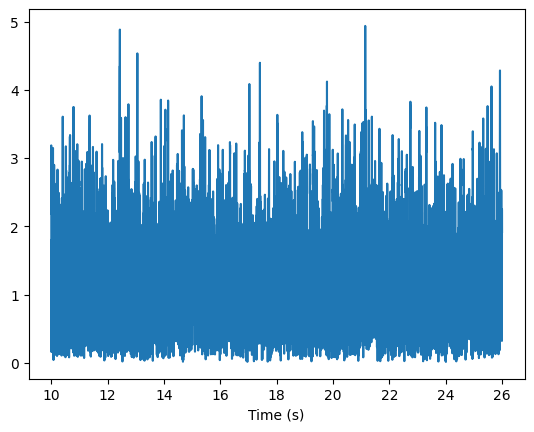

In [541]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [542]:
#GW190925_232845
#H
strain_H_event = TimeSeries(strain_H_data[46], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 21
m2 = 16
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.11181640625s with SNR 5.89127742082361


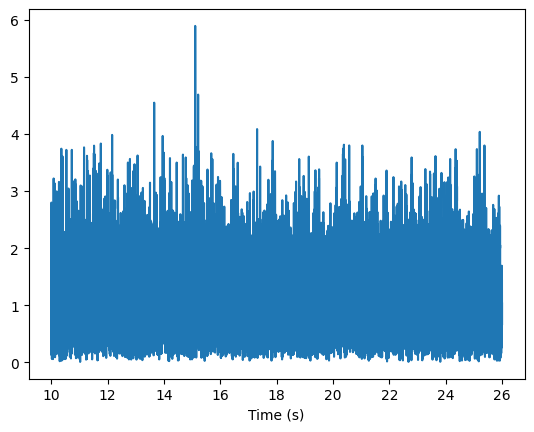

In [543]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [544]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [546]:
data = label_H[27]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190925_232845_H_data.npy', structured_array)

In [547]:
#GW190925_232845
#V
strain_V_event = TimeSeries(strain_V_data[34], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 21
m2 = 16
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 14.16357421875s with SNR 4.441220301468375


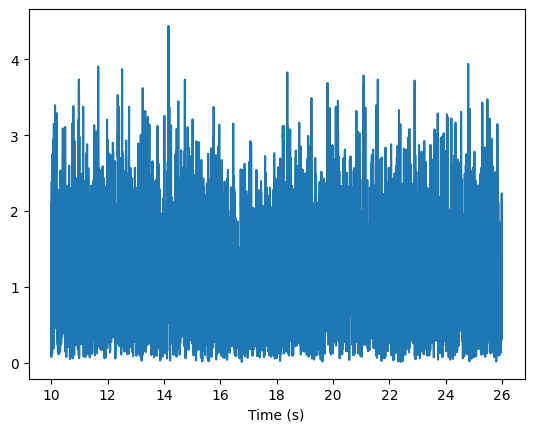

In [548]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [549]:
for value_strain, value_snr in zip(strain_V_event_array, snr_values):
    if value_snr >= 4:
        label_V_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_V_values.append((value_strain, "noise"))
label_V.append(label_V_values)

In [551]:
data = label_V[4]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_V', float), ('Label', 'U10')])
np.save('GW190925_232845_V_data.npy', structured_array)

In [552]:
#GW190926_050336
#H
strain_H_event = TimeSeries(strain_H_data[47], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 41
m2 = 20
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.17138671875s with SNR 4.427839968043495


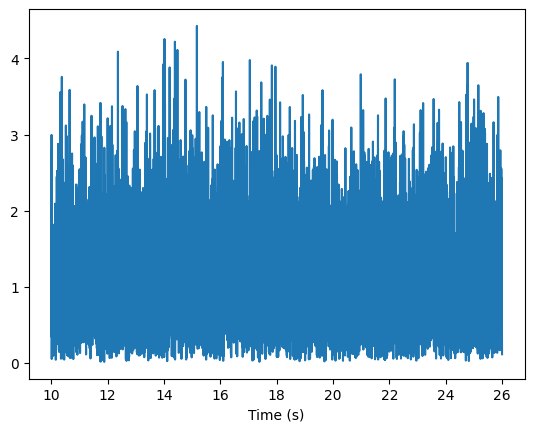

In [553]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [554]:
#GW190926_050336
#L
strain_L_event = TimeSeries(strain_L_data[51], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 41
m2 = 20
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 19.56103515625s with SNR 4.549331872150448


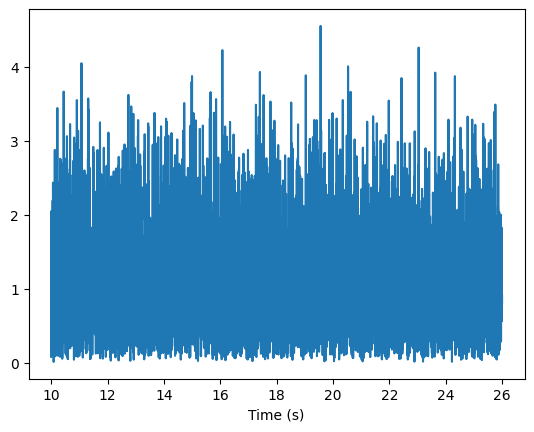

In [555]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [556]:
#GW190926_050336
#V
strain_V_event = TimeSeries(strain_V_data[35], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 41
m2 = 20
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 20.6201171875s with SNR 4.701379057011017


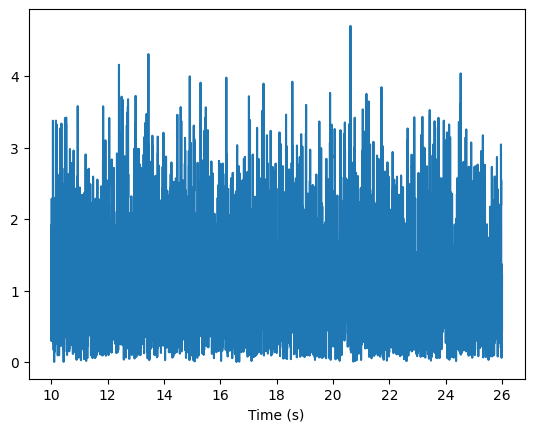

In [557]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла целиот настан.

In [558]:
#GW190929_012149
#H
strain_H_event = TimeSeries(strain_H_data[48], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 66
m2 = 27
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.501953125s with SNR 5.148352771954885


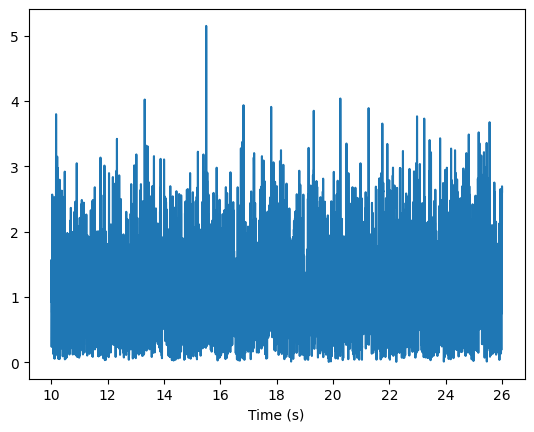

In [559]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [560]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 4.5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [562]:
data = label_H[28]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW190929_012149_H_data.npy', structured_array)

In [563]:
#GW190929_012149
#L
strain_L_event = TimeSeries(strain_L_data[52], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 66
m2 = 27
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 18.55615234375s with SNR 5.1043657623987695


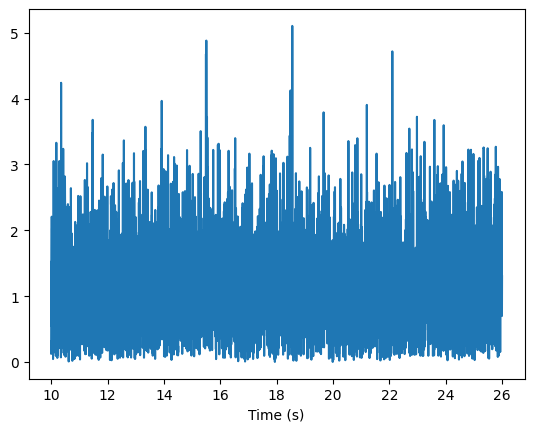

In [564]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [565]:
#GW190929_012149
#V
strain_V_event = TimeSeries(strain_V_data[36], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 66
m2 = 27
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 24.32080078125s with SNR 4.385219843066371


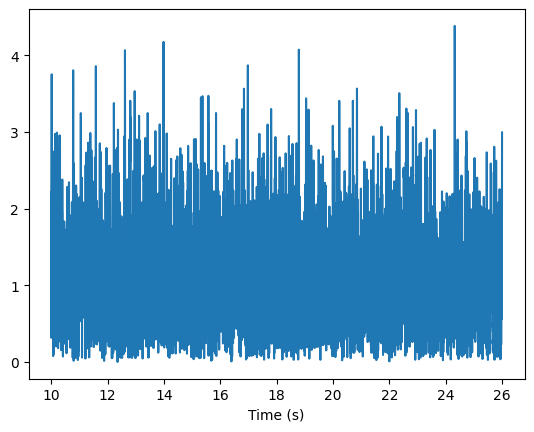

In [566]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [567]:
#GW190930_133541
#H
strain_H_event = TimeSeries(strain_H_data[49], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 14
m2 = 7
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 14.1533203125s with SNR 4.401369672502503


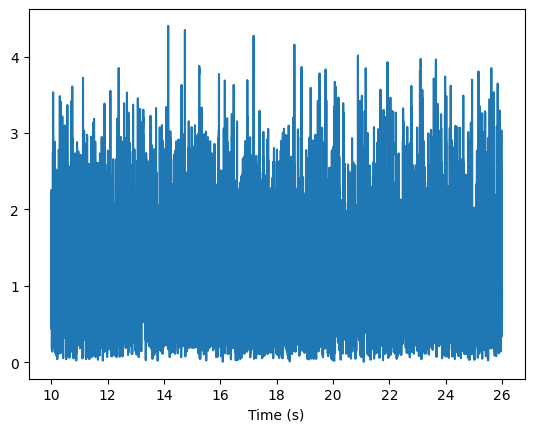

In [568]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [569]:
#GW190930_133541
#L
strain_L_event = TimeSeries(strain_L_data[53], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 14
m2 = 7
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.28515625s with SNR 4.565779315528328


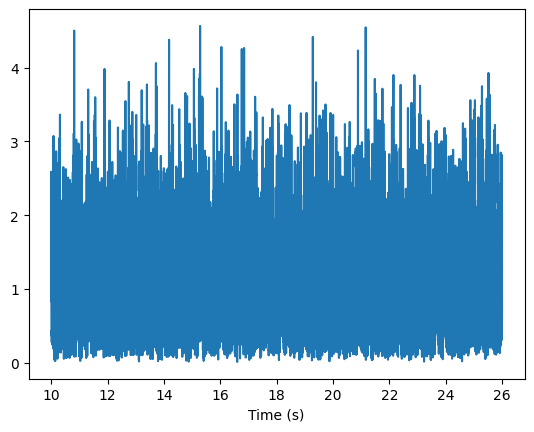

In [570]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла настанот.

In [571]:
#GW191103_012549
#H
strain_H_event = TimeSeries(strain_H_data[50], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 12
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 14.330078125s with SNR 4.504906120310266


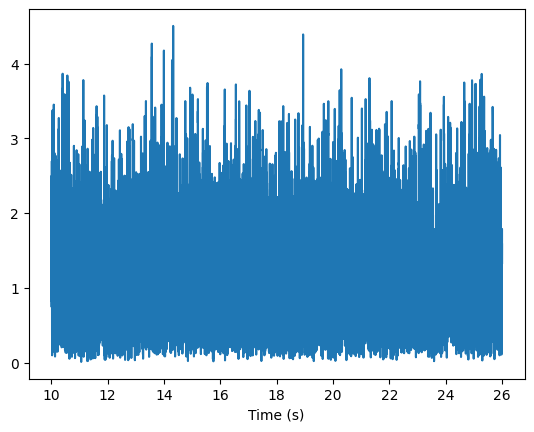

In [572]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [573]:
#GW191103_012549
#L
strain_L_event = TimeSeries(strain_L_data[54], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 12
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 21.20654296875s with SNR 5.183509275470449


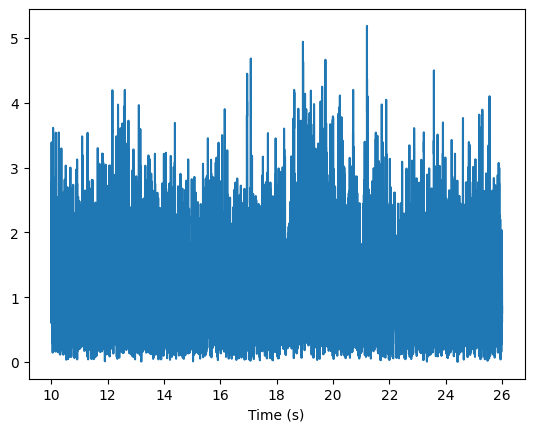

In [574]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла настанот.

In [575]:
#GW191105_143521
#H
strain_H_event = TimeSeries(strain_H_data[51], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 11
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 21.4521484375s with SNR 4.63798967520647


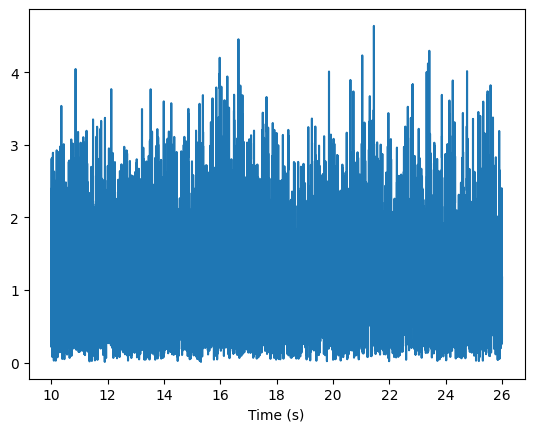

In [576]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [577]:
#GW191105_143521
#L
strain_L_event = TimeSeries(strain_L_data[55], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 11
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.96923828125s with SNR 4.592370135753087


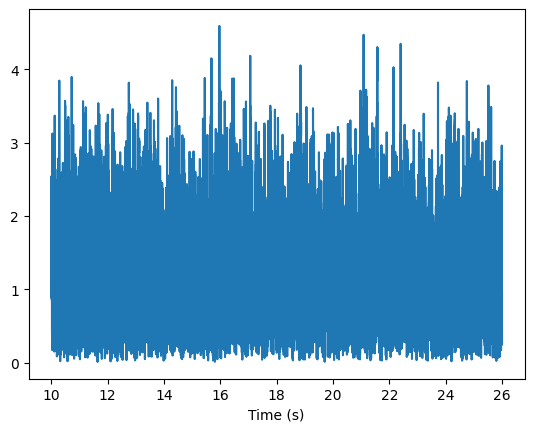

In [578]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [579]:
#GW191105_143521
#V
strain_V_event = TimeSeries(strain_V_data[37], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 11
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 17.33984375s with SNR 4.947243532408893


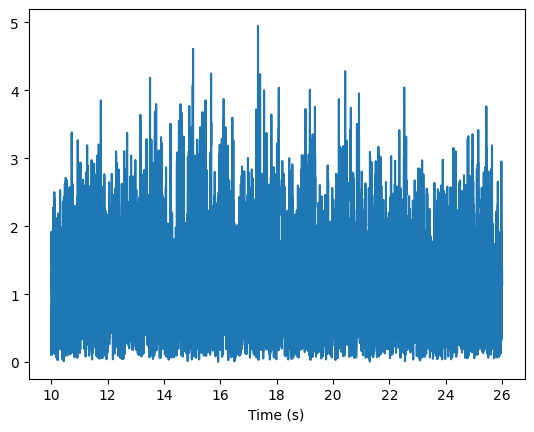

In [580]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла настанот.

In [583]:
#GW191109_010717
#H
strain_H_event = TimeSeries(strain_H_data[52], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 65
m2 = 47
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.208984375s with SNR 8.395614998871656


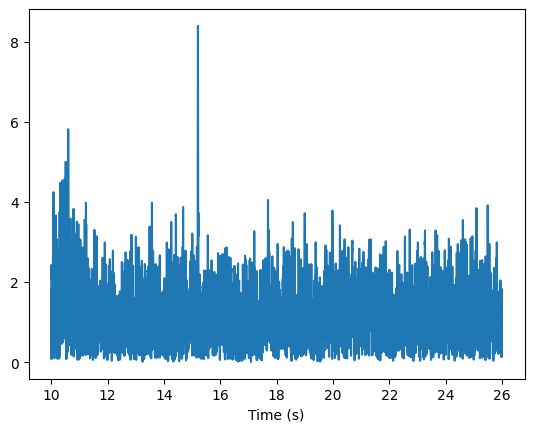

In [584]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [585]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 6:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [587]:
data = label_H[29]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW191109_010717_H_data.npy', structured_array)

In [588]:
#GW191109_010717
#L
strain_L_event = TimeSeries(strain_L_data[56], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 65
m2 = 47
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=10)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.2138671875s with SNR 10.92247179029888


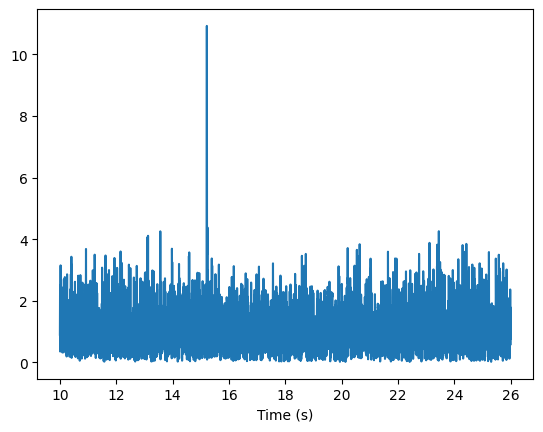

In [589]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [590]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [592]:
data = label_L[37]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW191109_010717_L_data.npy', structured_array)

In [596]:
#GW191113_071753
#H
strain_H_event = TimeSeries(strain_H_data[53], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 29
m2 = 6
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.84912109375s with SNR 4.6675258106726485


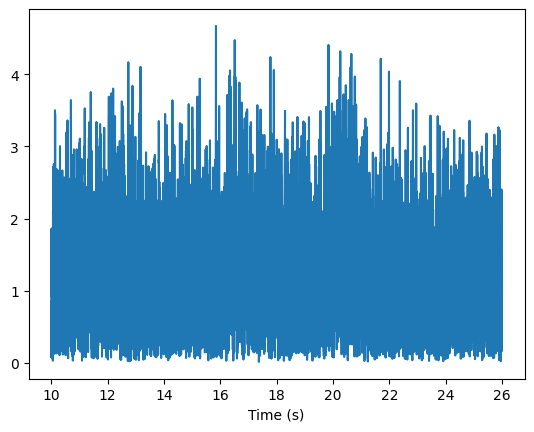

In [597]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [608]:
#GW191113_071753
#L
strain_L_event = TimeSeries(strain_L_data[57], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 29
m2 = 6
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 21.9091796875s with SNR 4.732757571450428


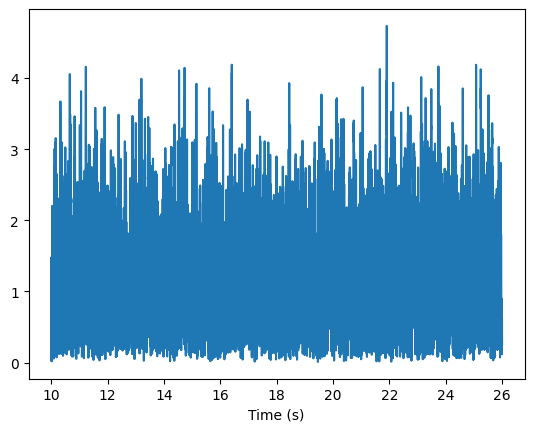

In [609]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [612]:
#GW191113_071753
#V
strain_V_event = TimeSeries(strain_V_data[38], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 29
m2 = 6
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 11.2265625s with SNR 4.30807383178498


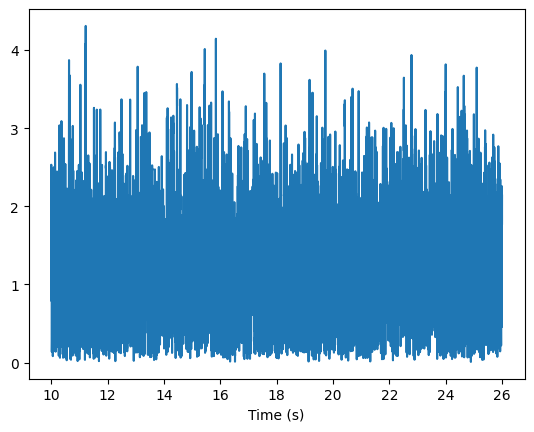

In [613]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла настанот.

In [616]:
#GW191126_115259
#H
strain_H_event = TimeSeries(strain_H_data[54], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 12
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.8095703125s with SNR 4.8272554770310006


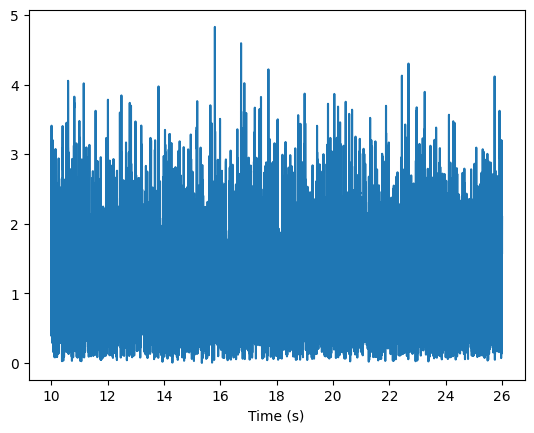

In [617]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [618]:
#GW191126_115259
#L
strain_L_event = TimeSeries(strain_L_data[58], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 12
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 25.9072265625s with SNR 4.503532018570029


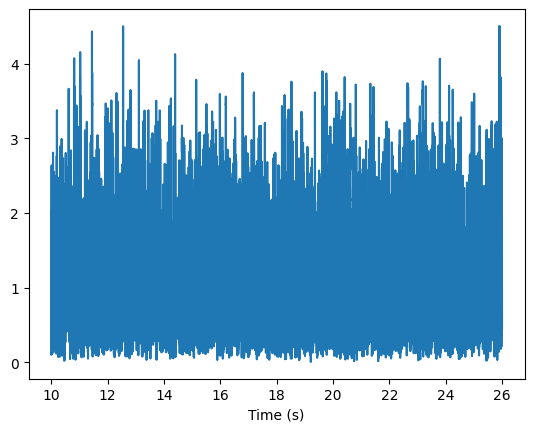

In [619]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла настанот.

In [622]:
#GW191127_050227
#H
strain_H_event = TimeSeries(strain_H_data[55], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 53
m2 = 24
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.55517578125s with SNR 5.9494690214555295


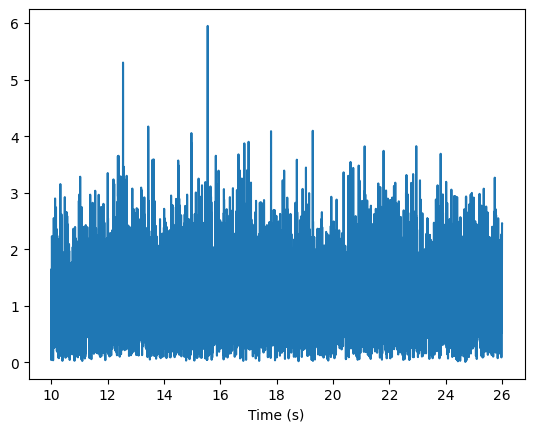

In [623]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [624]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [626]:
data = label_H[30]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW191127_050227_H_data.npy', structured_array)

In [627]:
#GW191127_050227
#L
strain_L_event = TimeSeries(strain_L_data[59], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 53
m2 = 24
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.55419921875s with SNR 5.896668343914997


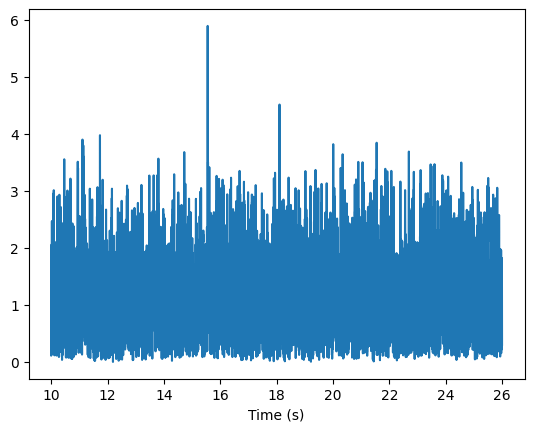

In [628]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [629]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [631]:
data = label_L[38]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW191127_050227_L_data.npy', structured_array)

In [632]:
#GW191127_050227
#V
strain_V_event = TimeSeries(strain_V_data[39], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 53
m2 = 24
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 12.33154296875s with SNR 4.22885893008807


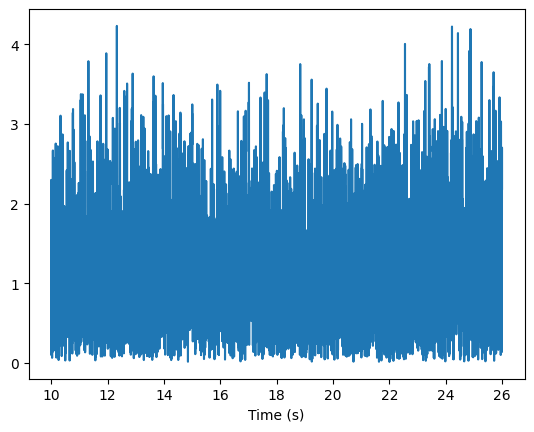

In [633]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [634]:
#GW191129_134029
#H
strain_H_event = TimeSeries(strain_H_data[56], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 11
m2 = 7
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 18.720703125s with SNR 5.231098764249173


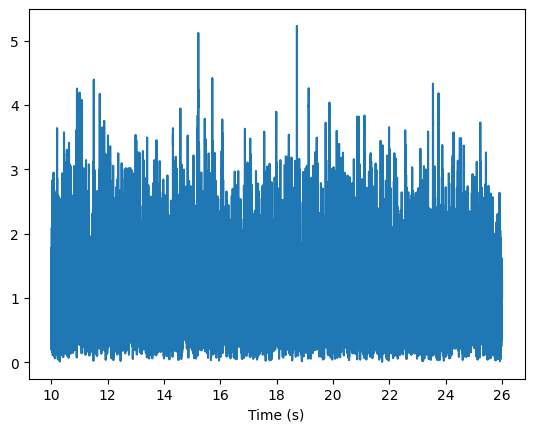

In [635]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [636]:
#GW191129_134029
#L
strain_L_event = TimeSeries(strain_L_data[60], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 11
m2 = 7
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 10.76123046875s with SNR 4.655012851265895


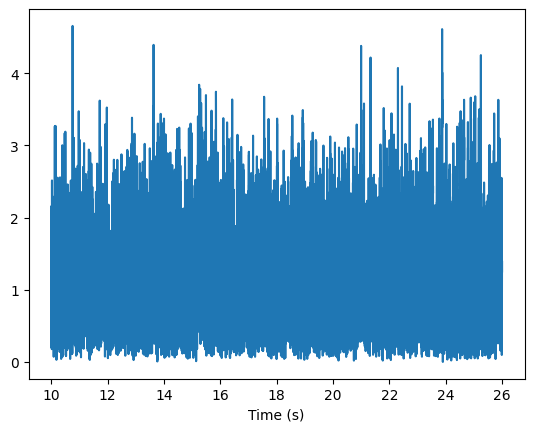

In [637]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла настанот.

In [639]:
#GW191204_110529
#H
strain_H_event = TimeSeries(strain_H_data[57], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 27
m2 = 19
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 20.72802734375s with SNR 4.45323513326983


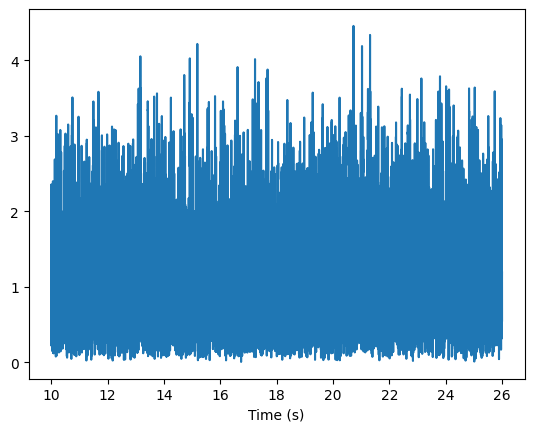

In [640]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [641]:
#GW191204_110529
#L
strain_L_event = TimeSeries(strain_L_data[61], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 27
m2 = 19
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.556640625s with SNR 5.128551726364042


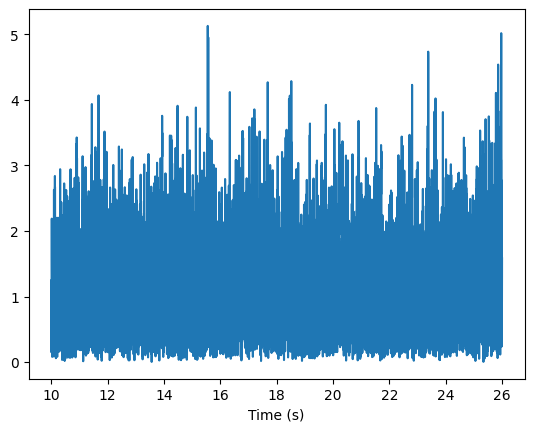

In [642]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла настанот.

In [654]:
#GW191204_171526
#H
strain_H_event = TimeSeries(strain_H_data[58], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 12
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=30)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 10.0693359375s with SNR 4.5208319470100955


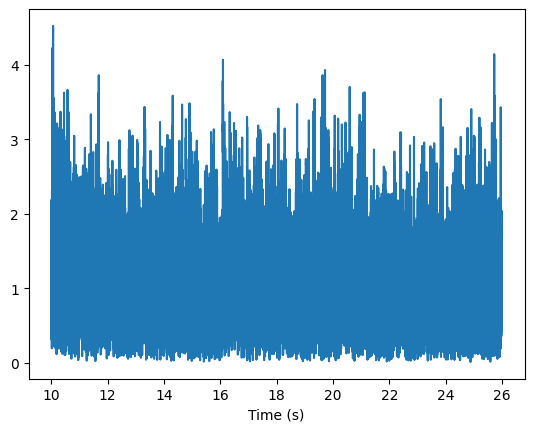

In [655]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [656]:
#GW191204_171526
#L
strain_L_event = TimeSeries(strain_L_data[62], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 12
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 16.125s with SNR 5.876947164118524


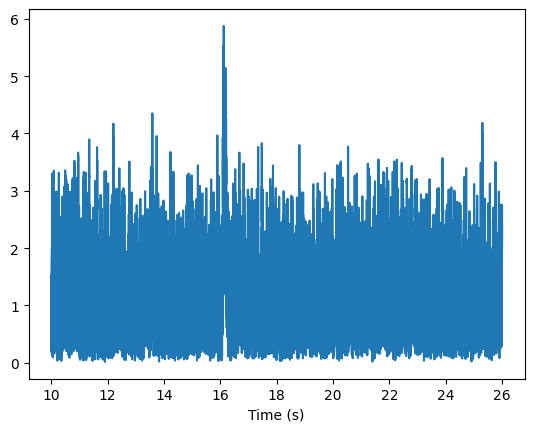

In [657]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [658]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [660]:
data = label_L[39]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW191204_171526_L_data.npy', structured_array)

In [662]:
#GW191215_223052
#H
strain_H_event = TimeSeries(strain_H_data[59], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 25
m2 = 18
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 25.31103515625s with SNR 4.9402244298617735


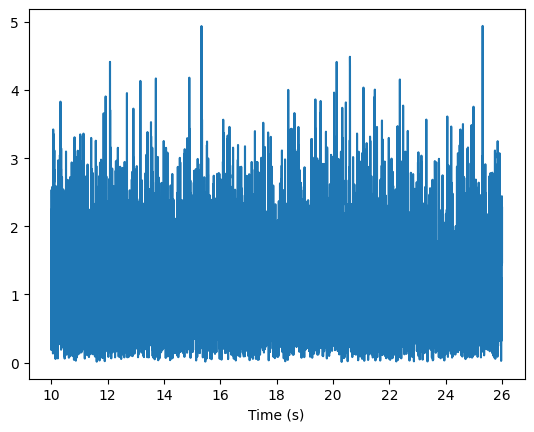

In [663]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [665]:
#GW191215_223052
#L
strain_L_event = TimeSeries(strain_L_data[63], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 25
m2 = 18
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 21.3349609375s with SNR 4.8768840076173126


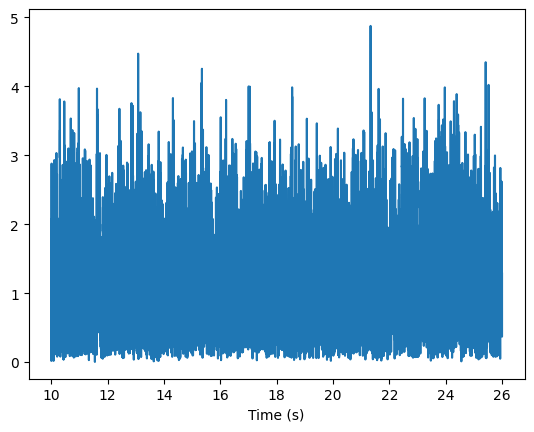

In [666]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [672]:
#GW191215_223052
#V
strain_V_event = TimeSeries(strain_V_data[40], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 25
m2 = 18
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 22.04345703125s with SNR 4.580645136400774


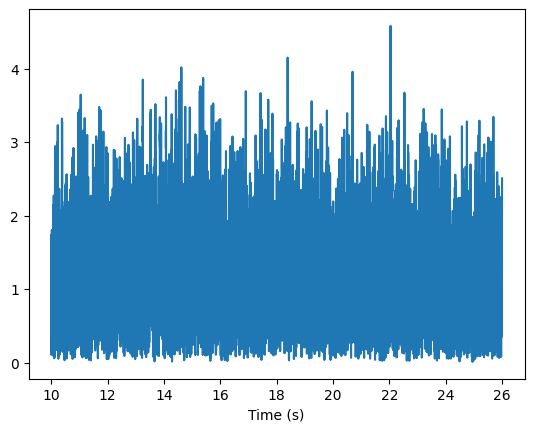

In [673]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

Се отфрла настанот.

In [675]:
#GW191216_213338
#H
strain_H_event = TimeSeries(strain_H_data[60], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 12
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.4716796875s with SNR 11.22731627182657


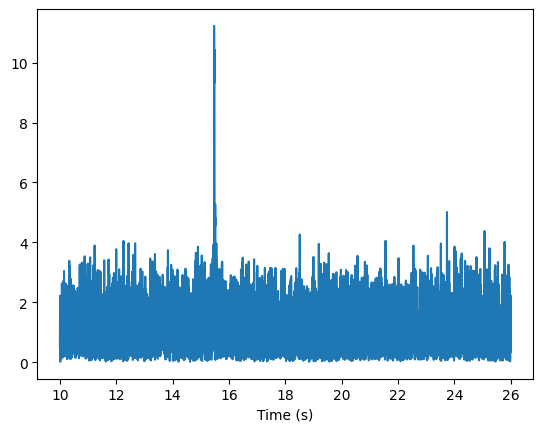

In [676]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [677]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 6:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [679]:
data = label_H[31]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW191216_213338_H_data.npy', structured_array)

In [680]:
#GW191216_213338
#V
strain_V_event = TimeSeries(strain_V_data[41], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 12
m2 = 8
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 17.16259765625s with SNR 4.888437571447899


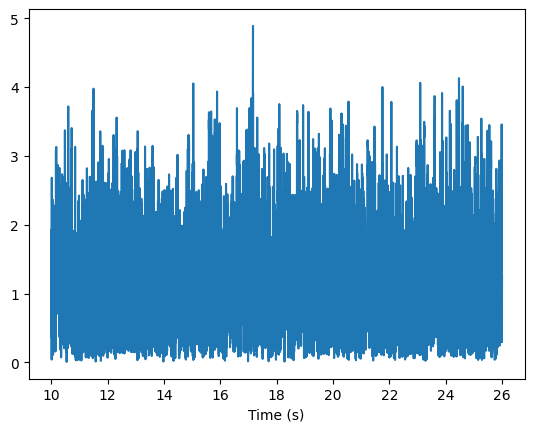

In [681]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [693]:
#GW191219_163120
#H
strain_H_event = TimeSeries(strain_H_data[61], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 31
m2 = 1.2
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=60)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 10.0419921875s with SNR 11.801796947700552


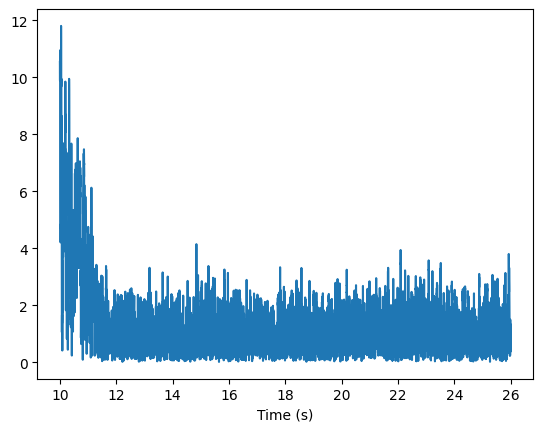

In [694]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [695]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 6:
        label_H_values.append((value_strain, "noise+NSBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [697]:
data = label_H[32]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW191219_163120_H_data.npy', structured_array)

In [700]:
#GW191219_163120
#L
strain_L_event = TimeSeries(strain_L_data[64], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 31
m2 = 1.2
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 10.05078125s with SNR 8.232328890441243


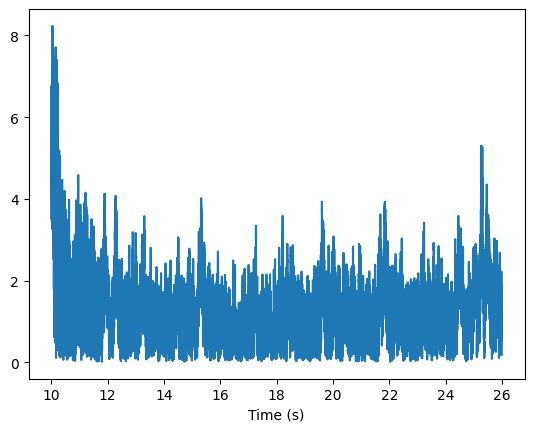

In [701]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [702]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 6:
        label_L_values.append((value_strain, "noise+NSBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [704]:
data = label_L[40]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW191219_163120_L_data.npy', structured_array)

In [707]:
#GW191219_163120
#V
strain_V_event = TimeSeries(strain_V_data[42], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 31
m2 = 1.2
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 11.95751953125s with SNR 4.286819504151402


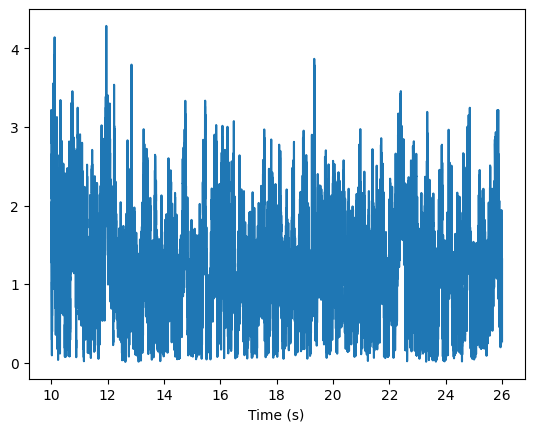

In [708]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [709]:
#GW191222_033537
#H
strain_H_event = TimeSeries(strain_H_data[62], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 45
m2 = 35
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.12353515625s with SNR 6.972080415400092


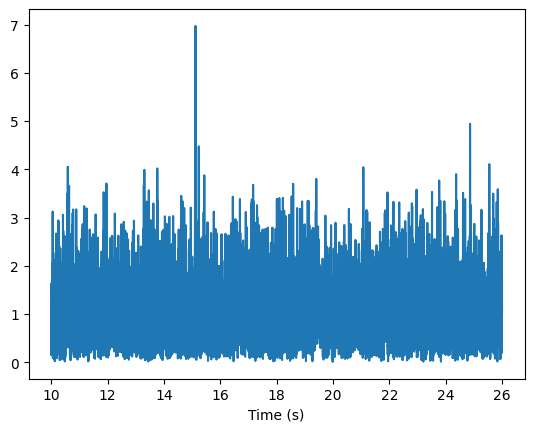

In [710]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [711]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [713]:
data = label_H[33]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW191222_033537_H_data.npy', structured_array)

In [714]:
#GW191222_033537
#L
strain_L_event = TimeSeries(strain_L_data[65], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 45
m2 = 35
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.12255859375s with SNR 6.363576872701342


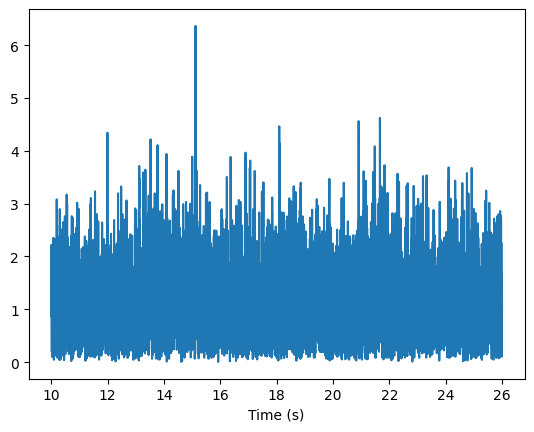

In [715]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [716]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [718]:
data = label_L[41]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW191222_033537_L_data.npy', structured_array)

In [720]:
#GW191230_180458
#H
strain_H_event = TimeSeries(strain_H_data[63], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 49
m2 = 37
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.40185546875s with SNR 5.766910965668333


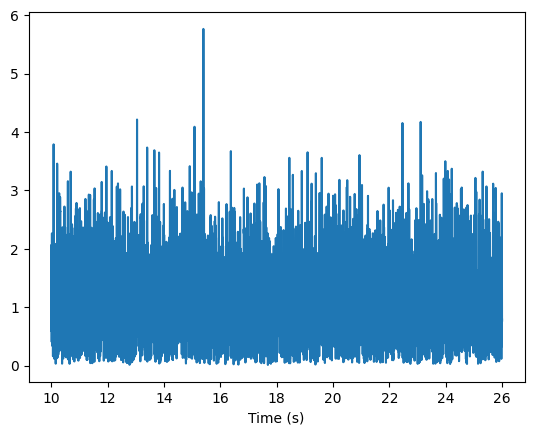

In [721]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [722]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 4.5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [724]:
data = label_H[34]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW191230_180458_H_data.npy', structured_array)

In [725]:
#GW191230_180458
#L
strain_L_event = TimeSeries(strain_L_data[66], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 49
m2 = 37
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.40234375s with SNR 5.2404087545622335


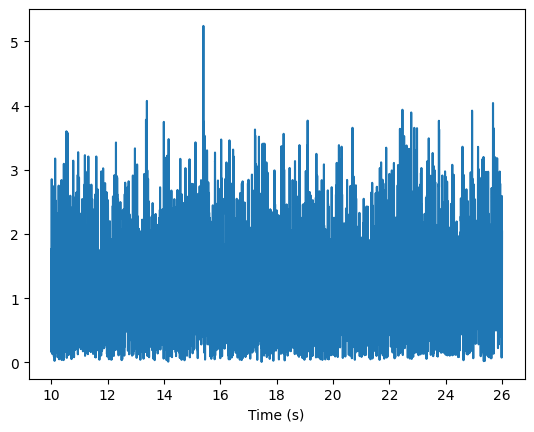

In [726]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [727]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 4.5:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [729]:
data = label_L[42]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW191230_180458_L_data.npy', structured_array)

In [730]:
#GW191230_180458
#V
strain_V_event = TimeSeries(strain_V_data[43], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 49
m2 = 37
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 11.3447265625s with SNR 4.06338120908475


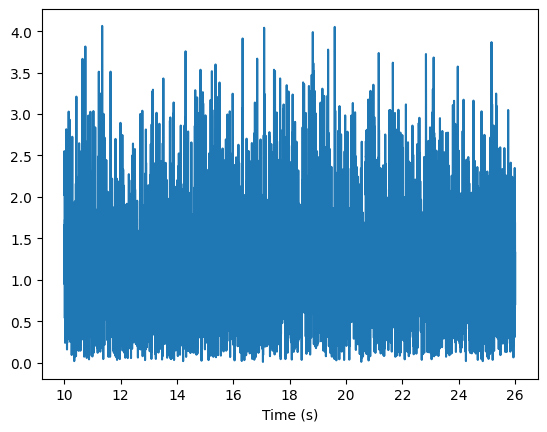

In [731]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [732]:
#GW200112_155838
#L
strain_L_event = TimeSeries(strain_L_data[67], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 36
m2 = 28
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 16.08935546875s with SNR 13.705370332265911


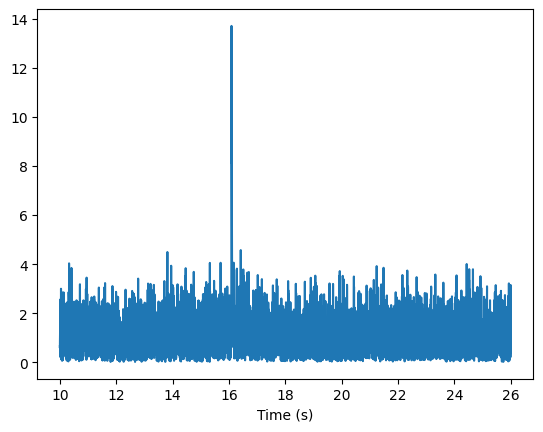

In [733]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [734]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 6:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [736]:
data = label_L[43]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW200112_155838_L_data.npy', structured_array)

In [737]:
#GW200112_155838
#V
strain_V_event = TimeSeries(strain_V_data[44], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 36
m2 = 28
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 16.76953125s with SNR 4.695184556863716


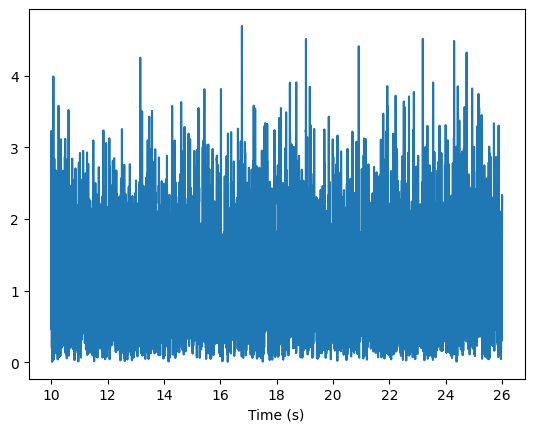

In [738]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [739]:
#GW200115_042309
#H
strain_H_event = TimeSeries(strain_H_data[64], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 6
m2 = 1.44
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 10.677734375s with SNR 8.219718615714262


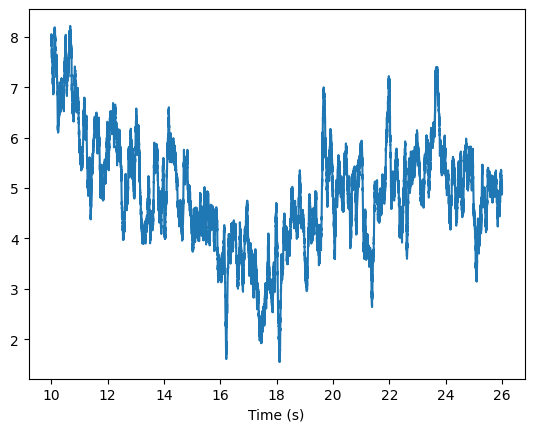

In [740]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [741]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 6:
        label_H_values.append((value_strain, "noise+NSBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [743]:
data = label_H[35]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW200115_042309_H_data.npy', structured_array)

In [745]:
#GW200115_042309
#L
strain_L_event = TimeSeries(strain_L_data[68], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 6
m2 = 1.44
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 10.0s with SNR 10.468207691053959


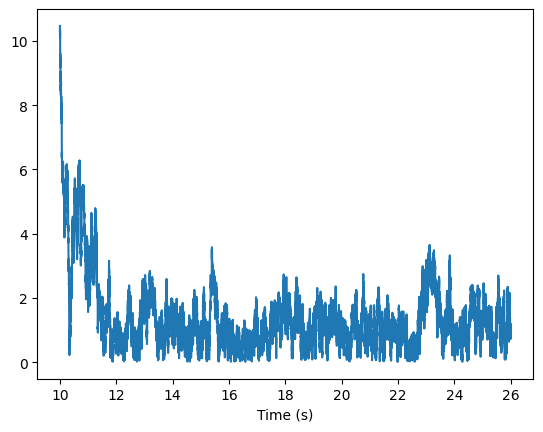

In [746]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [747]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 6:
        label_L_values.append((value_strain, "noise+NSBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [749]:
data = label_L[44]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW200115_042309_L_data.npy', structured_array)

In [751]:
#GW200115_042309
#V
strain_V_event = TimeSeries(strain_V_data[45], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 6
m2 = 1.44
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 23.6787109375s with SNR 3.689443779163605


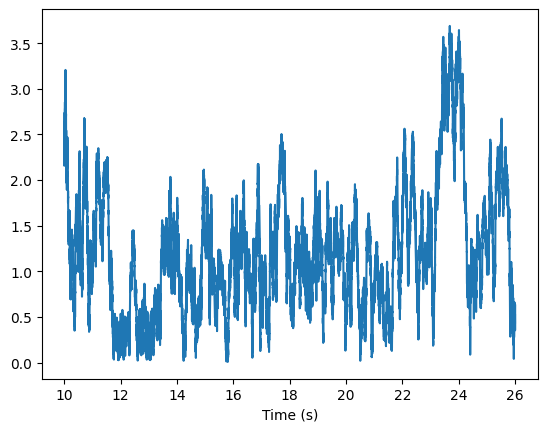

In [752]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [753]:
#GW200128_022011
#H
strain_H_event = TimeSeries(strain_H_data[65], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 42
m2 = 33
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.8984375s with SNR 5.603965355519537


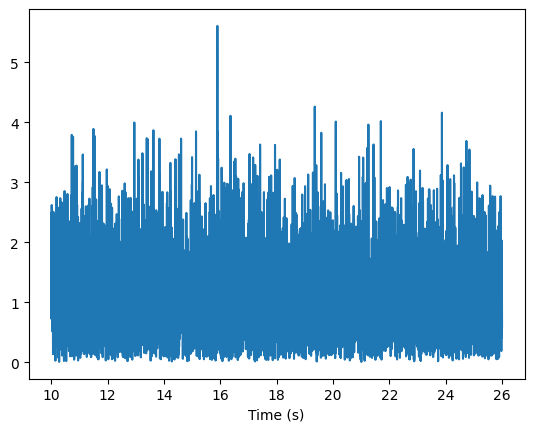

In [754]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [755]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 4.5:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [757]:
data = label_H[36]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW200128_022011_H2_data.npy', structured_array)

In [758]:
#GW200128_022011
#L
strain_L_event = TimeSeries(strain_L_data[69], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 42
m2 = 33
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.8984375s with SNR 4.87763938442988


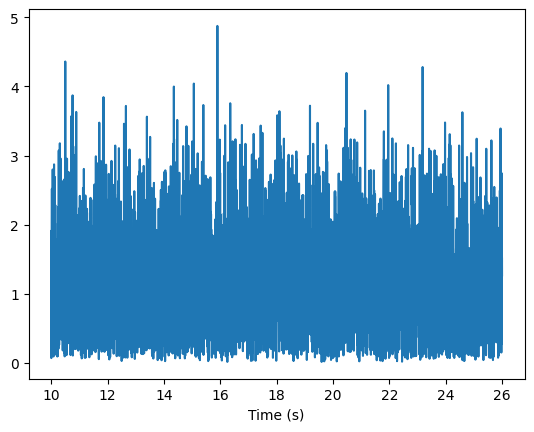

In [759]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [760]:
#GW200129_065458
#H
strain_H_event = TimeSeries(strain_H_data[66], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 35
m2 = 29
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 15.42333984375s with SNR 12.932404789107277


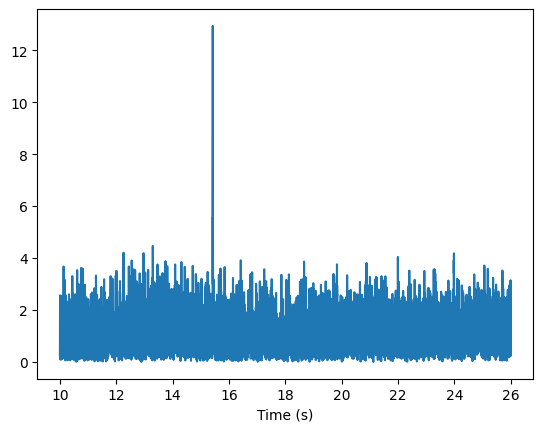

In [761]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [762]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 6:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [764]:
data = label_H[37]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW200129_065458_H_data.npy', structured_array)

In [765]:
#GW200129_065458
#L
strain_L_event = TimeSeries(strain_L_data[70], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 35
m2 = 29
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 15.4287109375s with SNR 17.487845564587086


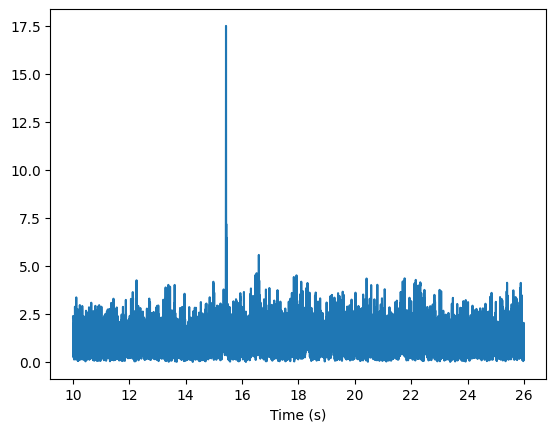

In [766]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [767]:
for value_strain, value_snr in zip(strain_L_event_array, snr_values):
    if value_snr >= 6:
        label_L_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_L_values.append((value_strain, "noise"))
label_L.append(label_L_values)

In [769]:
data = label_L[45]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_L', float), ('Label', 'U10')])
np.save('GW200129_065458_L_data.npy', structured_array)

In [770]:
#GW200129_065458
#V
strain_V_event = TimeSeries(strain_V_data[46], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 35
m2 = 29
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 13.3134765625s with SNR 4.485346547731407


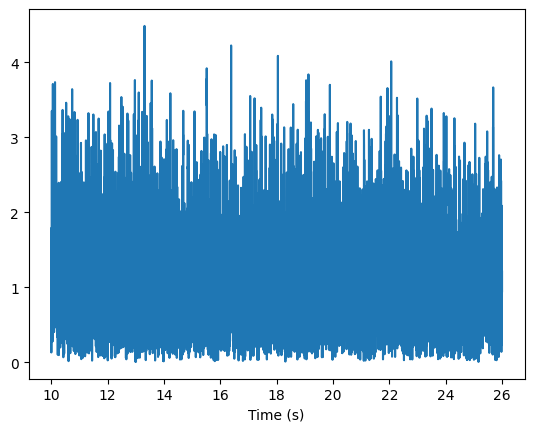

In [771]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [772]:
#GW200202_154313
#H
strain_H_event = TimeSeries(strain_H_data[67], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 10
m2 = 7
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 25.28466796875s with SNR 4.5690467391682965


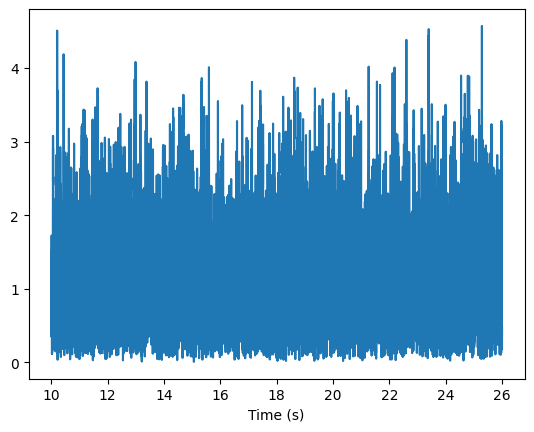

In [773]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [775]:
#GW200202_154313
#L
strain_L_event = TimeSeries(strain_L_data[71], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 10
m2 = 7
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 13.53466796875s with SNR 4.72544005238692


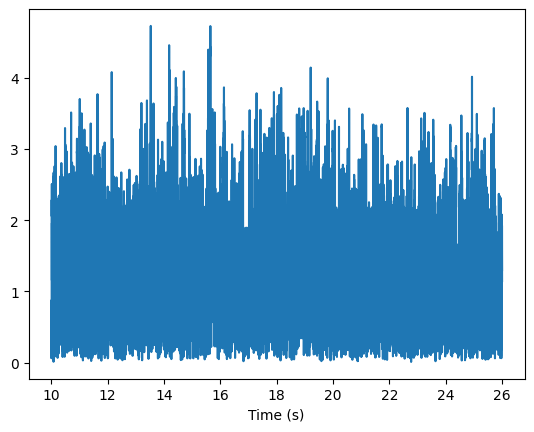

In [776]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [777]:
#GW200202_154313
#V
strain_V_event = TimeSeries(strain_V_data[47], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 10
m2 = 7
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 17.3544921875s with SNR 4.446288568498382


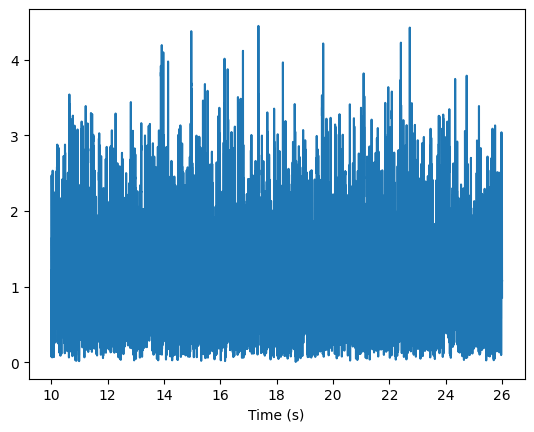

In [778]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [779]:
#GW200208_130117
#H
strain_H_event = TimeSeries(strain_H_data[68], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 38
m2 = 27
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_H_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_H_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_H_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_H_event.start_time
subtracted = strain_H_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_H_values = []
strain_H_event_array = np.array(strain_H_event)


A signal was found at 20.8037109375s with SNR 13.152329609643937


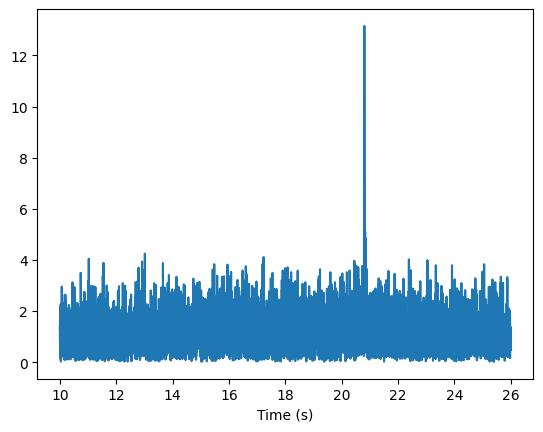

In [780]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [781]:
for value_strain, value_snr in zip(strain_H_event_array, snr_values):
    if value_snr >= 6:
        label_H_values.append((value_strain, "noise+BBH")) #se oznachuvaat kako shum+signal samo onie strain vrednosti so snr nad 5
    else: 
        label_H_values.append((value_strain, "noise"))
label_H.append(label_H_values)

In [783]:
data = label_H[38]
strain_values = [item[0] for item in data]
labels = [item[1] for item in data]
structured_array = np.array(list(zip(strain_values, labels)), dtype=[('Strain_H', float), ('Label', 'U10')])
np.save('GW200208_130117_H_data.npy', structured_array)

In [784]:
#GW200208_130117
#L
strain_L_event = TimeSeries(strain_L_data[72], delta_t=1.0/2048)
strain_L_event = strain_L_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_L_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_L_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_L_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 38
m2 = 27
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_L_event.delta_t,
                     f_lower=20)
hp.resize(len(strain_L_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_L_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_L_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_L_event.start_time
subtracted = strain_L_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_L_values = []
strain_L_event_array = np.array(strain_L_event)

A signal was found at 19.1171875s with SNR 4.1773943980137025


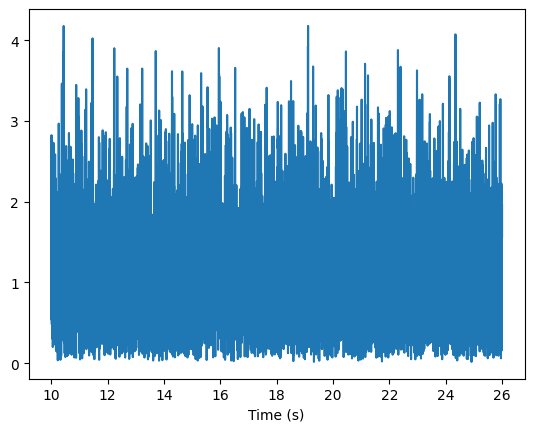

In [785]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()

In [786]:
#GW200208_130117
#V
strain_V_event = TimeSeries(strain_V_data[48], delta_t=1.0/2048)
strain_V_event = strain_V_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_V_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_V_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_V_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template za matched-filtering
m1 = 38
m2 = 27
hp, hc = get_td_waveform(approximant="SEOBNRv3",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_V_event.delta_t,
                     f_lower=15)
hp.resize(len(strain_V_event)) #se pravi resize za da ima match so data
template = hp.cyclic_time_shift(hp.start_time) #se pomestuva vremenski template za da bide vo ona vreme kade se sluchuva potencijalniot nastan
snr = matched_filter(template, strain_V_event, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4) #se ostranuvaat po 4s na pochetok i kraj poradi diskont. od template i PSD filterot i dopolnitelni 4s na pochetokot za da se zeme vo predvid template length, za BNS signali bi trebalo povekje
snr_values = abs(snr).numpy()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("A signal was found at {}s with SNR {}".format(time, abs(snrp)))
dt = time - strain_V_event.start_time #se pomestuva template na peak time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0) #se skalira template da ima SNR 1
#se skaliraat template amplitudata i fazata kon peak vrednosta
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries() 
aligned.start_time = strain_V_event.start_time
subtracted = strain_V_event - aligned #se izdvojuva samo shumot
#zachuvuanje vo label_H
label_V_values = []
strain_V_event_array = np.array(strain_V_event)


A signal was found at 24.03662109375s with SNR 4.084603839511139


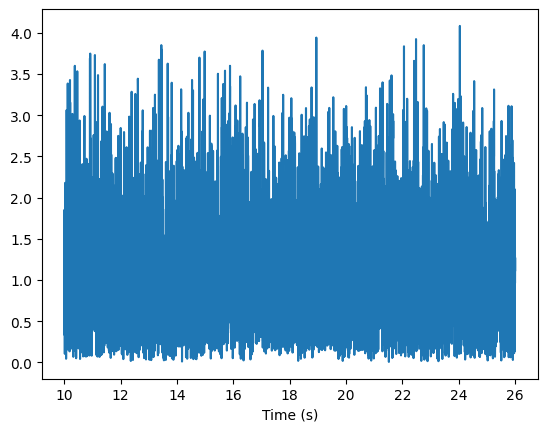

In [787]:
pylab.plot(abs(snr).sample_times, abs(snr))
pylab.xlabel('Time (s)')
pylab.show()